# Chapter 11 - God Spiked the Integers

Generalized Linear Models are quite a bit more complicated than the standard linear model - it can be hard to figure out exactly how the parameters will affect the prediction.

Most common GLMs are for counts. The basic issue is that the scale of the parameters (continuous, linear, &c.) is not the same as the scale of the output (discrete).

In this chapter we'll look at two kinds of GLMs:
1. Binomial regression consists of a family of related models for binary classification (right / wrong, left / right, accept / reject, &c.) for which the total is known
1. Poisson regression is a GLM for modelling a count with an unknown maximum (e.g. number of elephants in Kenya)

At the end of the chapter we'll look at some other related count models.

## Binomial Regression

Think back to the globe tossing model of the **Earlier chapter**. The model was binomial - it counted the number of water samples when tossing the globe. It wasn't a GLM because there were no predictor variables.

There are two different GLMs that use a binomial probability function, and really they are the same model, just organizing the data differently.
1. Logistic Regression is used when the data are organized into single-trial cases, such that the outcome variable can only take the values of 0 or 1
1. Aggregated Binomial Regression are used when the individual trials with the same covariate values are grouped together, so the outcome can take the value 0 - $n$, the number of trials.

Both use the **logit link** and so are sometimes both called logistic regression.

### Logistic regression: Prosocial chimpanzees

The data for this example come from a study of the prosocial behaviour of chimpanzees (*Pan troglodytes*).

We will test to see if there is a connection between the option to deliver two pieces of food and the presence of another chimp.

In [1]:
library(rethinking)
library(ggplot2)
options(repr.plot.width=16, repr.plot.height=8)
library(dagitty)

Loading required package: cmdstanr



This is cmdstanr version 0.7.0.9000

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/ericr/.cmdstan/cmdstan-2.33.1

- CmdStan version: 2.33.1


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

Loading required package: posterior

This is posterior version 1.5.0


Attaching package: ‘posterior’


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match


Loading required package: parallel

rethinking (Version 2.40)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent




In [ ]:
data(chimpanzees)
d <- chimpanzees

In [2]:
head(d)
summary(d)

actor recipient condition block trial prosoc_left chose_prosoc pulled_left
1 1     NA        0         1      2    0           1            0          
2 1     NA        0         1      4    0           0            1          
3 1     NA        0         1      6    1           0            0          
4 1     NA        0         1      8    0           1            0          
5 1     NA        0         1     10    1           1            1          
6 1     NA        0         1     12    1           1            1

     actor     recipient     condition       block         trial      
 Min.   :1   Min.   :2     Min.   :0.0   Min.   :1.0   Min.   : 1.00  
 1st Qu.:2   1st Qu.:3     1st Qu.:0.0   1st Qu.:2.0   1st Qu.:18.75  
 Median :4   Median :5     Median :0.5   Median :3.5   Median :36.50  
 Mean   :4   Mean   :5     Mean   :0.5   Mean   :3.5   Mean   :36.50  
 3rd Qu.:6   3rd Qu.:7     3rd Qu.:1.0   3rd Qu.:5.0   3rd Qu.:54.25  
 Max.   :7   Max.   :8     Max.   :1.0   Max.   :6.0   Max.   :72.00  
             NA's   :252                                              
  prosoc_left   chose_prosoc     pulled_left    
 Min.   :0.0   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.5   Median :1.0000   Median :1.0000  
 Mean   :0.5   Mean   :0.5675   Mean   :0.5794  
 3rd Qu.:1.0   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :1.0   Max.   :1.0000   Max.   :1.0000  
                                                

In [3]:
?chimpanzees

chimpanzees             package:rethinking             R Documentation

_C_h_i_m_p_a_n_z_e_e _p_r_o_s_o_c_i_a_l_t_y _e_x_p_e_r_i_m_e_n_t _d_a_t_a

_D_e_s_c_r_i_p_t_i_o_n:

     Data from behavior trials in a captive group of chimpanzees,
     housed in Lousiana. From Silk et al. 2005. Nature 437:1357-1359.

_U_s_a_g_e:

     data(chimpanzees)
     
_F_o_r_m_a_t:

       1. actor : name of actor

       2. recipient : name of recipient (NA for partner absent
          condition)

       3. condition : partner absent (0), partner present (1)

       4. block : block of trials (each actor x each recipient 1 time)

       5. trial : trial number (by chimp = ordinal sequence of trials
          for each chimp, ranges from 1-72; partner present trials were
          interspersed with partner absent trials)

       6. prosocial_left : 1 if prosocial (1/1) option was on left

       7. chose_prosoc : choice chimp made (0 = 1/0 option, 1 

Variables to focus on:
- `pulled_left` as the outcome - this is whether they pulled the left hand lever (0 / 1)
- `prosoc_left` as a predictor - this is whether the left lever was attached to the option to deliver two pieces of food (0 / 1)
- `condition` as a predictor - this is whether there was a second chimp there (0 - no, 1 - yes)

We especially want to consider the four options:
1. `prosoc_left=0` and `condition=0`: two food items on the right and no partner
1. `prosoc_left=1` and `condition=0`: two food items on the left and no partner
1. `prosoc_left=0` and `condition=1`: two food items on the right and partner present
1. `prosoc_left=1` and `condition=1`: two food items on the right and partner present

The conventional thing is to use dummy variables to model these four conditions, but we won't do that because that makes it difficult to construct our priors. Instead, we'll build an index variable that encodes the different possibilities above.

In [4]:
d$treatment <- 1 + d$prosoc_left + 2 * d$condition

In [5]:
# verify using crosstabs (honestly not sure what this means)
xtabs(~ treatment + prosoc_left + condition, d)

, , condition = 0

         prosoc_left
treatment   0   1
        1 126   0
        2   0 126
        3   0   0
        4   0   0

, , condition = 1

         prosoc_left
treatment   0   1
        1   0   0
        2   0   0
        3 126   0
        4   0 126


The model implied by the research question is

$$
\begin{align*}
L_i &\sim \text{Binomial}(1, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{ACTOR}[i]} + \beta_{\text{TREATMENT}[i]} \\
\alpha_j &\sim \text{to be determined} \\
\beta_j &\sim \text{to be determined} \\
\end{align*}
$$

Here $L_i$ indicates the 0/1 variable `pulled_left`. Since there is just the one outcome, we could also use $L_i \sim \text{Bernoulli}(p)$; it doesn't make a difference.

The model implies 7 different $\alpha$s (one for each of the chimpanzees) and 4 different $\beta$s, one for each of the four different treatment options. In principle we could also have each of the 7 chimps have their own $\beta$ value, but we'll do that in a later chapter; for now this is probably fine.

Now we need to determine that value of the priors. Let's consider a much simpler model

$$
\begin{align*}
L_i &\sim \text{Binomial(1, p)} \\
\text{logit}(p) &= \alpha \\
\alpha &\sim \text{Normal}(0, \omega)
\end{align*}
$$

As a very bad initla guess, let's start with something very flat like $\omega = 10$.

In [6]:
m11.1 <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm(0, 10)
    ),
    data=d
)

In [7]:
set.seed(1999)
prior <- extract.prior(m11.1)

Now we need to convert the parameter to the outcome scale. This will require using the **logistic function** (inverse logit).

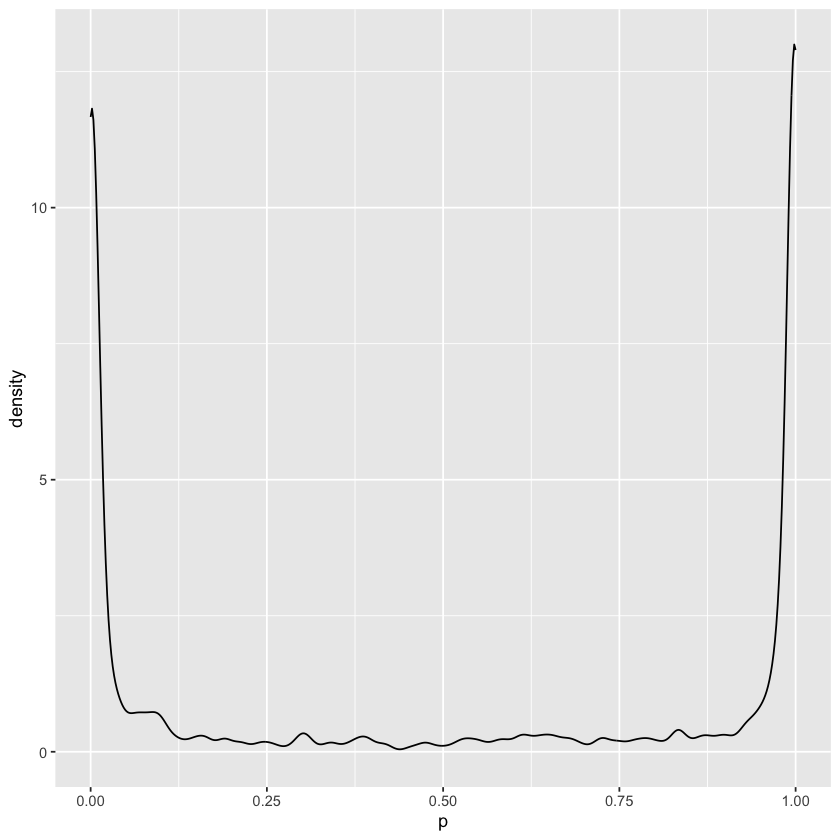

In [8]:
p <- inv_logit(prior$a)
ggplot(data.frame(p=p), aes(p)) +
    geom_density(adjust=0.1)

This is not what we expected (or wanted) - the model thinks that chimpanzees either never or always pull the lever! A flat outcome in logit space *is not* the same as a flat outcome in probability space. Let's try this again but with $\omega = 1.5$.

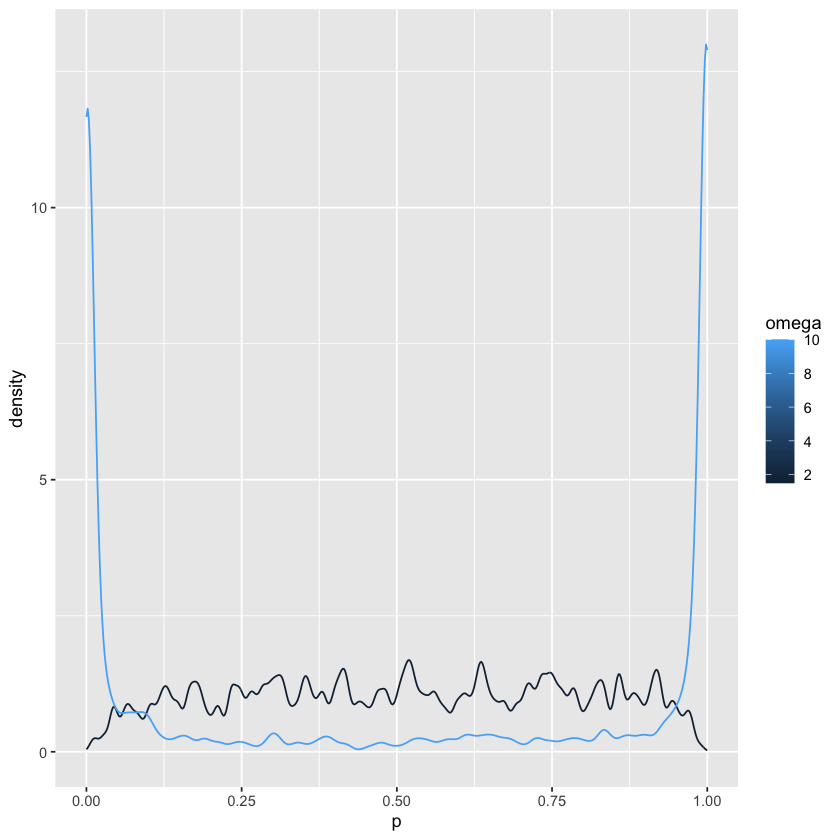

In [9]:
m11.1_revised <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm(0, 1.5)
    ),
    data=d
)
set.seed(1999)
prior_revised <- extract.prior(m11.1_revised)
p_revised <- inv_logit(prior_revised$a)
plot_df <- data.frame(p=c(p, p_revised), omega=rep(c(10, 1.5), each=length(p)))
ggplot(plot_df, aes(x = p, group = omega, colour = omega)) +
    geom_density(adjust=0.1)

This seems far more plausible, with values in the middle being approximately flat but ones at the end being unlikely.

Now we need the priors for the $\beta$ s. Again, let's see what happens with conventional flat priors:

In [10]:
m11.2 <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a + b[treatment],
        a ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 10)
    ),
    data=d
)

set.seed(1999)

prior <- extract.prior(m11.2, n=1e4)
p <- sapply(1:4, function(k) inv_logit(prior$a + prior$b[, k]))

In [11]:
head(prior)

$a
    [1]  1.0990087330 -0.0567445655  1.8045137052  2.2047030382  0.2005354435
    [6]  0.7797408687 -0.8240730386 -1.7784119339 -1.7209196278  1.7411129976
   [11] -0.0163285359  0.8180834630 -1.9198503559 -0.1636205253 -0.3826783901
   [16]  0.9404644400 -0.2448545079  1.0119884381  2.3038692568 -0.3534557813
   [21]  0.2072271311  0.5379076975 -0.5883773596 -0.6122597285  1.8833664592
   [26] -2.1888963645 -0.1653589743  0.0364893107 -0.2113855394 -0.7701301932
   [31] -1.9272168441  2.1736657769 -2.6757353479  2.5567751427  0.0665395178
   [36]  2.5156377006 -0.4382465026 -1.9348825375  3.6565926958 -0.5660589659
   [41] -0.4733491458  1.0740008298  0.3938350120  0.1103336219  1.3108424169
   [46] -0.7756726343  0.1932331856  0.2407155007 -2.7820147164 -0.9099855617
   [51]  2.6485087152 -0.2973571881  1.1060398150  1.3104965186 -0.3771457128
   [56]  0.0220739088 -1.4008226371  2.1175010131  0.7265819010  1.5575258828
   [61]  1.1748069048  1.1207886073  0.9964332932  1.8173184493  0.8730868070
   [66] -0.1250489181 -0.3963460061 -1.2368508276  0.2423533655  0.9721781533
   [71] -1.5259290402  1.9930212767 -2.9366242849  1.5570955081 -0.0725051911
   [76] -0.0504279518 -0.3007864547 -1.1505612248 -2.3957109805  0.9920652589
   [81] -1.3055997429  0.9462983579  2.2806647766 -1.1982573218 -0.4953794586
   [86]  2.7893206238  0.3842756660  1.8864554372  3.2808671004  0.1784399979
   [91] -2.0353806331  0.2993172647  0.2359253135  0.4916699074 -3.4851531508
   [96] -0.4048906807 -1.0342840019 -0.2403449597 -0.8087634964 -0.6159406390
  [101]  0.0671462732 -0.2456133825 -2.6530325179 -1.1932366946  0.2391725421
  [106] -0.1762738311 -0.9120433315 -0.6061418929  0.9991812508 -0.1996382677
  [111] -2.4421898421  2.4101587858  0.3138139965  3.0955367892 -0.0960977934
  [116] -1.9338367539  0.2804812513  1.2182601328 -1.1231096156  0.5904018108
  [121] -1.1620823263 -0.4749876325 -0.4893647549 -0.3401652035  0.6466282638
  [126]  0.5689695105 -0.3560303970  0.4412200582  0.4504328775  0.0454152294
  [131]  0.6681260539 -2.3772981442 -0.3664685971  1.6925885051  2.4519881627
  [136]  0.6354310086 -1.2281192186  0.7399555412  1.1588602433  1.1327784401
  [141]  1.6253926157 -0.0743181194  1.2605096735 -0.6687640848 -1.3177840078
  [146]  0.5143163106  0.2190129131 -0.4093304588  1.2793740391 -0.0745910481
  [151] -1.7611461229  0.7936980343  0.9120105662 -1.1493395125 -0.5795948992
  [156]  2.8369625605 -0.3625861733 -1.2665397680  0.7566665290 -1.1462058239
  [161]  1.5461221828 -1.6376413240  2.4185405650  1.5330038975 -0.7730437728
  [166] -0.5520135654  1.0278264257 -1.5065523408  1.0997810871  2.2006444523
  [171] -0.6677014483 -1.8357044309  2.2479449778 -1.3818642238  0.4627735734
  [176]  1.4128110770  3.1031482976 -0.3082847141  1.1520173722 -0.8196176326
  [181] -0.1427608841 -1.1823567083  0.8509920976  1.0591496947  0.2412549622
  [186] -1.5501024668 -2.2506929199 -0.2767501901  1.9156315953  0.5754413694
  [191]  2.0959775057  1.9814907350  1.2747930289  2.4557800204  1.0029748712
  [196] -0.5718329102 -1.1244779671 -1.0253192637  1.8410197953  0.4881063720
  [201]  1.2847565082  2.8550464619 -2.5434671204 -3.0952725139 -0.3380332357
  [206]  2.9040203280  0.5629001560  0.1449975891 -0.0289066253  0.2850711461
  [211]  1.6826370274  1.0364005496  1.7409691428  0.6753414854 -0.8592367775
  [216] -1.6127922449  1.7900946005 -0.0795234636 -0.0825703993  1.5937759879
  [221]  2.3635685833 -1.1823176199 -2.1244537313 -2.2624879486  0.2433503608
  [226] -1.1233873336  0.2724793982  1.0813808086 -0.7940830751  2.7370040583
  [231] -0.6569907282  2.3284348914  1.8225708105 -0.1248221141  1.2810071460
  [236]  2.0454991229  0.4341417892 -1.0012332962  0.0420586171  0.8056887838
  [241]  0.3952669771 -0.4770303947 -0.8178540035  0.4306774194 -0.1196698760
  [246] -0.4822577206  0.8706539406 -0.3713825515  0.4707151647  1.5244121081
  [251] -0.9274628788 -0.9551814902  0.5267642732 -1.1079553880 -1.5642774567
  [256]  1.43237171

This gives us the prior probability of the probability of pulling the left lever, but actually what we're interested in is the *difference* among the treatments.

In [12]:
head(p)

[,1]         [,2]         [,3]         [,4]       
[1,] 9.690297e-01 9.994335e-01 0.0685573765 0.953717371
[2,] 1.001611e-05 1.000000e+00 0.9673426413 0.999999011
[3,] 9.982354e-01 9.999173e-01 0.0003428955 0.006234222
[4,] 9.999999e-01 4.793453e-10 0.9999744279 0.999998531
[5,] 1.552106e-04 9.187013e-01 0.6764428282 0.999388593
[6,] 9.999978e-01 1.005783e-04 0.3118792593 0.820964713

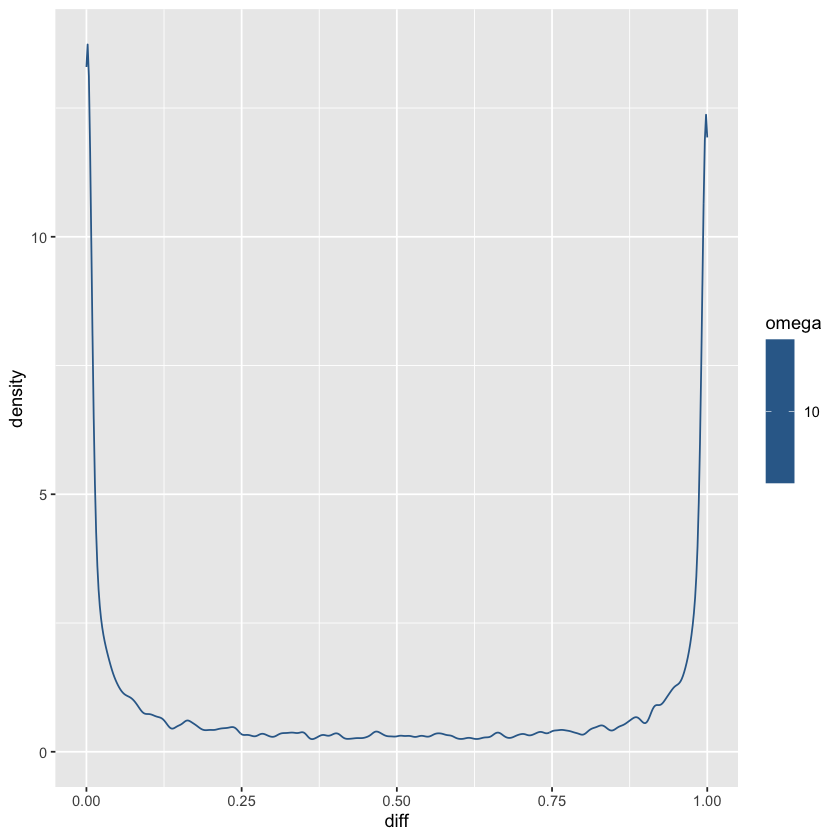

In [13]:
# here we are interested in the absolute difference for some reason?
difference_plot_df <- data.frame(
    diff = abs(p[, 1] - p[, 2]),
    omega = 10
)

ggplot(difference_plot_df, aes(diff, group = omega, colour = omega)) +
    geom_density(adjust=0.1)

Again, this seems unlikely. We want more skeptical priors. Let's see what happens if we use a $\text{Normal}(0, 0.5)$ prior instead.

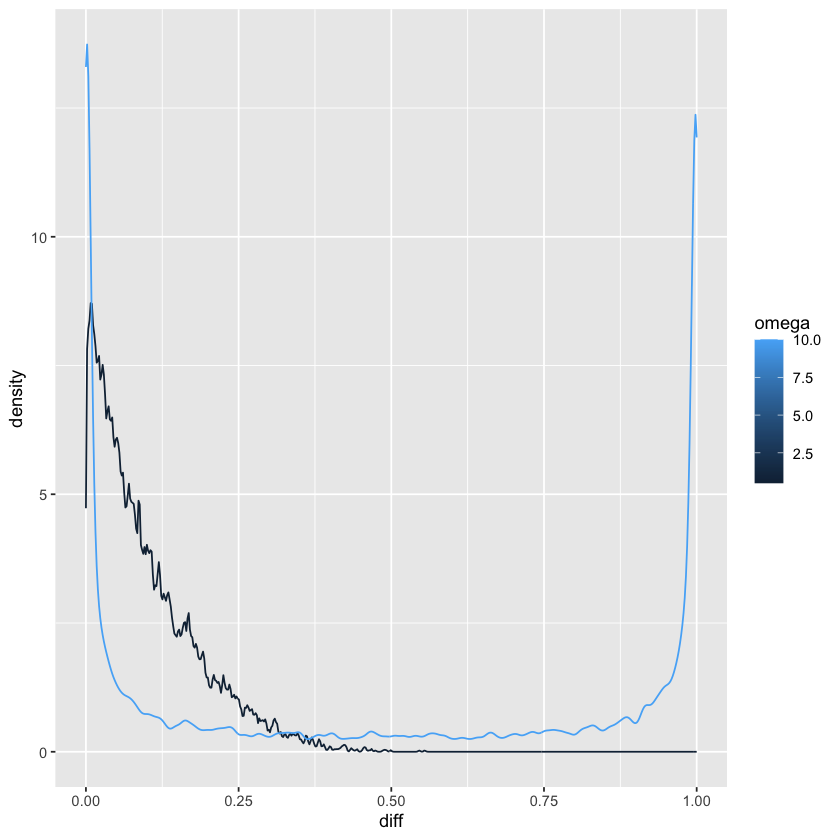

In [14]:
m11.2_revised <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a + b[treatment],
        a ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data=d
)

set.seed(1999)

prior_revised <- extract.prior(m11.2_revised, n=1e4)
p_revised <- sapply(1:4, function(k) inv_logit(prior_revised$a + prior_revised$b[, k]))

difference_plot_df <- rbind(difference_plot_df, data.frame(
    diff = abs(p_revised[, 1] - p_revised[, 2]),
    omega = 0.5
))

ggplot(difference_plot_df, aes(diff, group = omega, colour = omega)) +
    geom_density(adjust=0.1)

Now the probability is concentrated on low effect sizes, which is what we expect. We can also compute the mean effect size.

In [15]:
m11.3 <- quap(
    alist(
        pulled_left <- dbinom(1, p),
        logit(p) <- a + b[treatment],
        a ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = d
)

set.seed(1999)

prior <- extract.prior(m11.3, n=1e4)
p <- sapply(1:4, function(k) inv_logit(prior$a + prior$b[, k]))
mean(abs(p[, 1] - p[, 2]))

[1] 0.09838663

So the difference is roughly 10% (before we see the data).

Now lets analyze the model using **HMC**. The `quap` function will actually do OK, but only because of the regularizing priors.

In [16]:
# trimmed data list
dat_list <- list(
    pulled_left = d$pulled_left,
    actor = d$actor,
    treatment = as.integer(d$treatment)
)

In [17]:
m11.4 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = dat_list,
    chains = 4,
    log_lik = TRUE
)

precis(m11.4, depth = 2)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.4 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

mean        sd        5.5%        94.5%       rhat     ess_bulk 
a[1] -0.44428874 0.3273410 -0.97968236  0.06898334 1.003193  698.7231
a[2]  3.91111090 0.7448156  2.78077110  5.18344610 1.002924 1418.6434
a[3] -0.75459323 0.3290882 -1.29314530 -0.23659085 1.002498  715.8554
a[4] -0.75528052 0.3292270 -1.29220150 -0.23818057 1.006137  701.6992
a[5] -0.45348305 0.3246345 -0.96770977  0.08359580 1.003737  774.5869
a[6]  0.46699897 0.3351792 -0.06458849  0.99162481 1.005012  792.3203
a[7]  1.95783006 0.4138242  1.28397515  2.64307420 1.002946  917.9482
b[1] -0.03779445 0.2851385 -0.49886337  0.43130246 1.002709  675.4844
b[2]  0.48622780 0.2909519  0.02550242  0.96139139 1.003433  685.0708
b[3] -0.38302442 0.2900145 -0.84469238  0.08773202 1.003173  698.6702
b[4]  0.37542829 0.2860251 -0.08431510  0.82723556 1.003776  713.4152

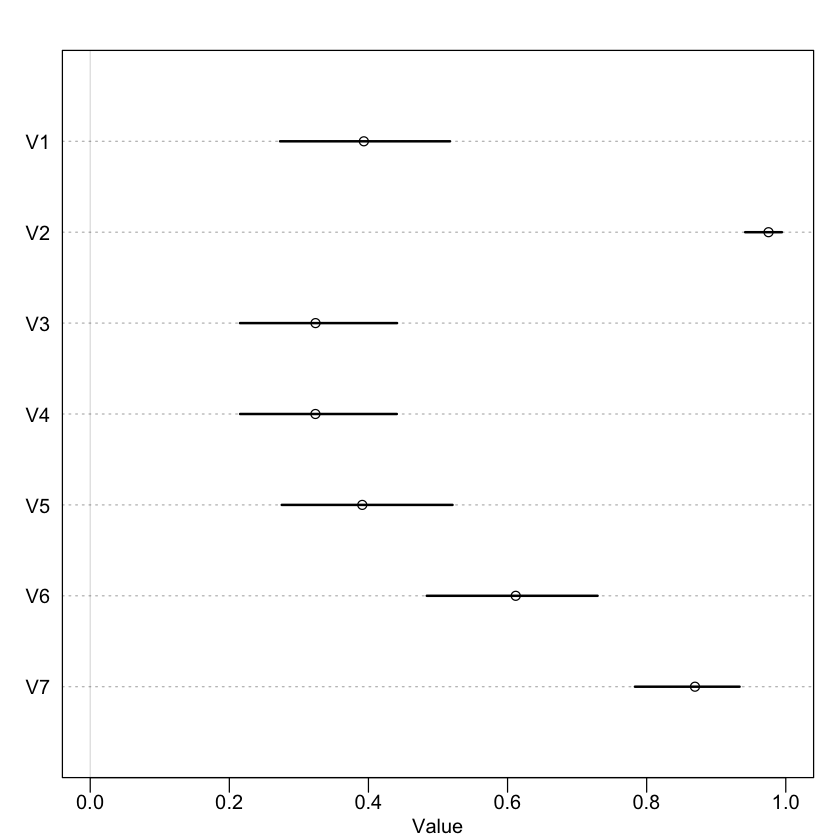

In [18]:
par(bg = 'white')
post <- extract.samples(m11.4)
p_left <- inv_logit(post$a)
plot(precis(as.data.frame(p_left)), xlim=c(0, 1))

These are the values for the individual chimpanzees. Note that four of the chimps have a preference for the left lever, and the rest have the opposite preference. Chimp 2 only ever pulled the left lever. This is a crazy amount of variation in individual preferences, but apparently quite normal in behavioural experiments.

Now let's look at the sidedness preferences

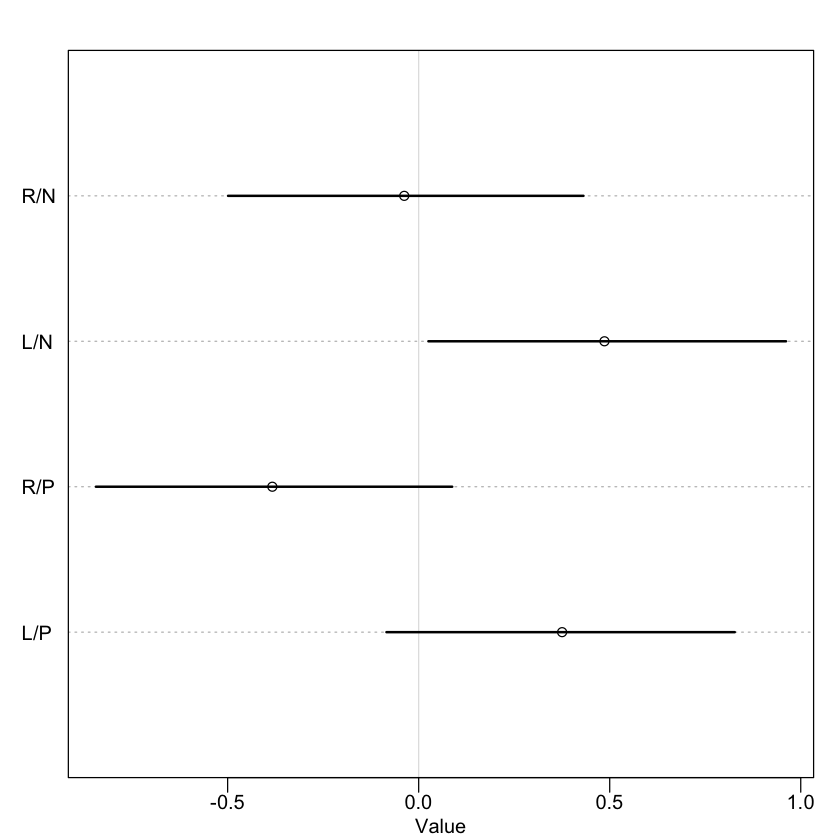

In [19]:
par(bg = 'white')
labs <- c("R/N", "L/N", "R/P", "L/P")
plot(precis(m11.4, depth=2, pars="b"), labels=labs)

In order to interpret this, we should consider what we expect. We are hoping to see more of the prosocial behaviour when there is a partner present, so we should compare the first / third rows and the second / fourth rows. Just from eyeballing it, it doesn't look like there is much of a difference. Let's compare the differences directly.

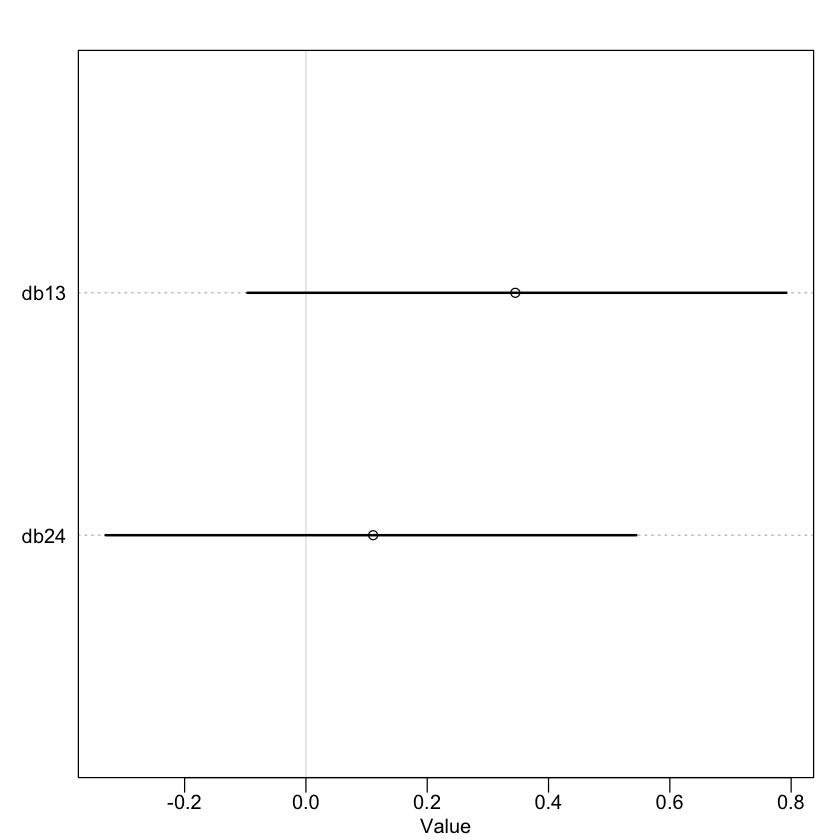

In [20]:
par(bg = 'white')
diffs <- list(
    db13 = post$b[, 1] - post$b[, 3],
    db24 = post$b[, 2] - post$b[, 4]
)
plot(precis(diffs))

The first one is comparing the behaviour when the prosocial option was on the right. In that case, we expect to see a *positive* difference as the chimp pulls the lever on the right more. The second one is comparing when the prosocial option was on the left. In that case, we expect to see a *negative* difference. From the above, there is some evidence for the right, but I am unconvinced when the option is on the left.

Now let's do a posterior predictive check. We'll summarize the proportions of left pulls for each actor in each treatment and then plot against the posterior predictions.

In [21]:
pl <- by(d$pulled_left, list(d$actor, d$treatment), mean)
pl

: 1
: 1
[1] 0.3333333
------------------------------------------------------------ 
: 2
: 1
[1] 1
------------------------------------------------------------ 
: 3
: 1
[1] 0.2777778
------------------------------------------------------------ 
: 4
: 1
[1] 0.3333333
------------------------------------------------------------ 
: 5
: 1
[1] 0.3333333
------------------------------------------------------------ 
: 6
: 1
[1] 0.7777778
------------------------------------------------------------ 
: 7
: 1
[1] 0.7777778
------------------------------------------------------------ 
: 1
: 2
[1] 0.5
------------------------------------------------------------ 
: 2
: 2
[1] 1
------------------------------------------------------------ 
: 3
: 2
[1] 0.6111111
------------------------------------------------------------ 
: 4
: 2
[1] 0.5
------------------------------------------------------------ 
: 5
: 2
[1] 0.5555556
------------------------------------------------------------ 
: 6
: 2
[1] 0.611111

`pl` is a matrix with 7 rows and 4 columns. Each row is a chimp, and each column is one of the treatment conditions. Each cell is the proportion of left pulls for that chimp and the specified treatment condition.

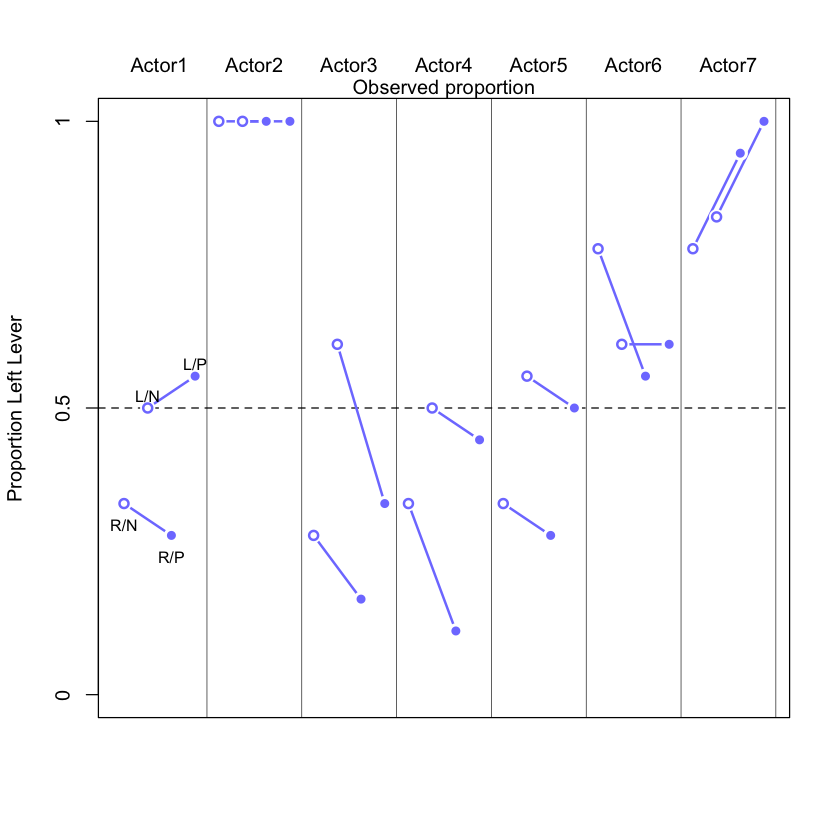

In [22]:
par(bg = 'white')
plot(NULL, xlim=c(1, 28), ylim=c(0, 1), xlab="", ylab="Proportion Left Lever", xaxt="n", yaxt="n")
axis(2, at=c(0, 0.5, 1), labels=c(0, 0.5, 1))
abline(h=0.5, lty=2)
for (j in 1:7) abline(v=(j-1) * 4 + 4.5, lwd=0.5) # draw the vertical lines
for (j in 1:7) text((j-1) * 4 + 2.5, 1.1, concat("Actor", j), xpd=TRUE) # label each grid segment
for (j in 1:7[-2]) {
    lines( (j-1)*4 + c(1, 3), pl[j, c(1, 3)], lwd=2, col=rangi2) # prosocial on the right
    lines( (j-1)*4 + c(2, 4), pl[j, c(2, 4)], lwd=2, col=rangi2) # prosocial on the left
}

# adding in the filled and hollow points
points(1:28, t(pl), pch=16, col="white", cex=1.7) 
points(1:28, t(pl), pch=c(1, 1, 16, 16), col=rangi2, lwd=2)

yoff <- 0.01
text(1, pl[1,1] - yoff, "R/N", pos=1, cex=0.8)
text(2, pl[1,2] - yoff, "L/N", pos=3, cex=0.8)
text(3, pl[1,3] - yoff, "R/P", pos=1, cex=0.8)
text(4, pl[1,4] - yoff, "L/P", pos=3, cex=0.8)
mtext("Observed proportion")

In [23]:
# getting the posterior predictions
dat <- list(actor=rep(1:7, each=4), treatment=rep(1:4, times=7))
p_post <- link(m11.4, data=dat)
p_mu <- apply(p_post, 2, mean)
p_ci <- apply(p_post, 2, PI)

In theory I could plot this, but...

Basically, the model shows almost no expected change when adding a partner. Most of the variation seems to come from the actors themselves, rather than from the presence or absence of a partner.

Interestingly, it seems that the chimps have different levels of susceptibility to the presence / absence of a partner. It might be interesting to allow each chimp to have their own parameters, but we'll do that when we talk about mutilevel models.

We haven't considered a model that splits into separate index variables the location of the prosocial option and the presence of a partner. This is because the hypothesis that we're working under is that there is an interaction effect going on - the prosocial choice will happen more often *when there is a partner present*. We could also build a model without the interaction and use WAIC or PSIS to compare them.

From the above, we can guess that the simpler model (no interaction) will do just fine; there doesn't seem to be much of an effect anyway.

In [24]:
d$side <- d$prosoc_left + 1 # right 1, left 2
d$cond <- d$condition + 1 # no partner 1, partner 2

# the model. We add the log_lik so we can compare the models
data_list2 <- list(
    pulled_left = d$pulled_left,
    actor = d$actor,
    side = d$side,
    cond = d$cond
)

m11.5 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + bs[side] + bc[cond],
        a[actor] ~ dnorm(0, 1.5),
        bs[side] ~ dnorm(0, 0.5),
        bc[cond] ~ dnorm(0, 0.5)
    ),
    data=data_list2,
    chains=4,
    log_lik=TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.7 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

In [25]:
compare(m11.5, m11.4, func = PSIS)

PSIS     SE       dPSIS    dSE      pPSIS    weight   
m11.5 530.4549 19.10183 0.000000       NA 7.626884 0.6220271
m11.4 531.4513 18.94224 0.996322 1.279907 8.152326 0.3779729

The PSIS scores are basically identical and well within the standard error.

### Relative shark and absolute deer

Earlier we were focused on the absolute difference in the outcome scale - how much does the probability change? With logistic regressions it is common to instead compare the *relative effects* - that is, instead of looking at the absolute change in the probability, focus on the *relative change* - i.e. did the odds double?

We can calculate the proportional odds by exponentiating the parameters.

In [26]:
# relative odds of switching from treatment 2 to treatment 4 (adding a partner)
post <- extract.samples(m11.4)
mean(exp(post$b[, 4] - post$b[, 2]))

[1] 0.9291585

This tells us that on average, adding a partner multiplies the odds by 92% (a reduction of 8%).

The risk of using relative odds is that it isn't enough to tell whether the variable is important or not. If the other parameters make the outcome unlikely, then even a very large change in the proportional odds doesn't mean much.

Of course, sometimes the relative risk is very important (for instance, when everything else is being held constant). Analogy: absolute risk of dying by deer is much higher than being attacked by a shark. However, when you're swimming in the ocean you care about the relative risk of shark attacks; conditional on being in the ocean, sharks are much more dangerous than deer.

### Aggregated binomial: Chimpanzees again, condensed

In the chimpanzee data, the models all calculated the likelihood of observing either 0 or 1 pulls; this was convenient because that's how the data were organized. We could just as easily have calculated the total count of left pulls for each condition.

In [27]:
data(chimpanzees)
d <- chimpanzees
d$treatment <- 1 + d$prosoc_left + 2 * d$condition
d$side <- d$prosoc_left + 1 # right 1, left 2
d$cond <- d$condition + 1 # no partner 1, partner 2

d_aggregated <- aggregate(
    d$pulled_left,
    list(
        treatment = d$treatment,
        actor = d$actor,
        side = d$side,
        cond = d$cond
    ),
    sum
)
colnames(d_aggregated)[5] <- "left_pulls"
head(d_aggregated)

treatment actor side cond left_pulls
1 1         1     1    1     6        
2 1         2     1    1    18        
3 1         3     1    1     5        
4 1         4     1    1     6        
5 1         5     1    1     6        
6 1         6     1    1    14

Now we can get the same kind of model, but using the aggregated counts.

In [28]:
dat <- with(d_aggregated, list(
    left_pulls = left_pulls,
    treatment = treatment,
    actor = actor,
    side = side,
    cond = cond
))

m11.6 <- ulam(
    alist(
        left_pulls ~ dbinom(18, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

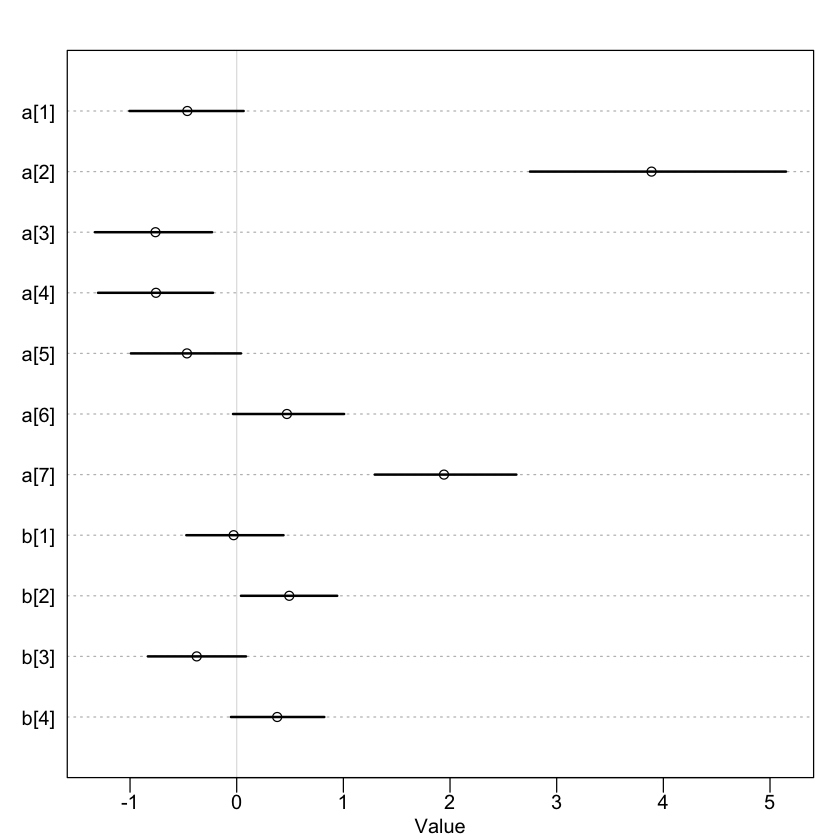

In [29]:
par(bg = 'white')
plot(precis(m11.6, depth = 2))

In [30]:
compare(m11.6, m11.4, func=PSIS)

Warning message in compare(m11.6, m11.4, func = PSIS):
“Different numbers of observations found for at least two models.
Model comparison is valid only for models fit to exactly the same observations.
Number of observations for each model:
m11.6 28 
m11.4 504 
”
Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



PSIS     SE        dPSIS    dSE      pPSIS    weight      
m11.6 114.2045  8.529007   0.0000       NA 8.417584 1.000000e+00
m11.4 531.4513 18.942245 417.2468 9.531782 8.152326 2.488911e-91

First issue is that the PSIS scores are different. This is purely a result of how we organized the data (the aggregation process). If we see 6 successes in 9 trials, the probability of that happening is 

$$
\frac{6!}{9!(9-6)!}p^6 (1-p)^{9-6}
$$

whereas if we take the actual six successes we got, that would not have the term out front

$$
p^6 (1-p)^{9-6}
$$

basically, the extra uncertainty from the fact that we are throwing away information about the order is causing that.

Also, since we trained the models on different data, we can't really compare them anyway.

The warning about the Pareto-$k$ value is due to the fact that since we are aggregating the data, each time we leave out one piece of the data we are really leaving out 18 pieces of data - all of the trials for one of the chimpanzees. This makes the remaining points more influential.

Bottom line: if you want to compare models using PSIS, you shouldn't aggregate the counts.

### Aggregated binomial: Graduate-school admissions

In the above example, all of the chimpanzees had the same number of trials. That is often not the case. Let's see how to deal with that by taking a look at some graduate school admissions data. These are the graduate school applications for UC Berkley graduate programs.

In [31]:
data(UCBadmit)
d <- UCBadmit
d

dept applicant.gender admit reject applications
1  A    male             512   313    825         
2  A    female            89    19    108         
3  B    male             353   207    560         
4  B    female            17     8     25         
5  C    male             120   205    325         
6  C    female           202   391    593         
7  D    male             138   279    417         
8  D    female           131   244    375         
9  E    male              53   138    191         
10 E    female            94   299    393         
11 F    male              22   351    373         
12 F    female            24   317    341

We're going to look to see if we can find a gender bias here; that is, model probability of admittance as a function of gender.

$$
\begin{align*}
A_i &\sim \text{Binomial}(N_i, p) \\
\text{logit}(p) &= \alpha_{ \text{GID}[i] } \\
\alpha_j &\sim \text{Normal}(0, 1.5)
\end{align*}
$$

Here, $N_i$ is the number of applicants to that program / department and GID is the indexed gender (1 -> male, 2 -> female).

In [32]:
dat_list <- list(
    admit = d$admit,
    applications = d$applications,
    gid = ifelse(d$applicant.gender == "male", 1, 2)
)

m11.7 <- ulam(
    alist(
        admit ~ dbinom(applications, p),
        logit(p) <- a[gid],
        a[gid] ~ dnorm(0, 1.5)
    ),
    data = dat_list,
    chains = 4
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

mean       sd         5.5%       94.5%      rhat      ess_bulk
a[1] -0.2215393 0.03767883 -0.2809970 -0.1655059 0.9999707 1506.931
a[2] -0.8297312 0.05121146 -0.9115474 -0.7478981 1.0031896 1396.420

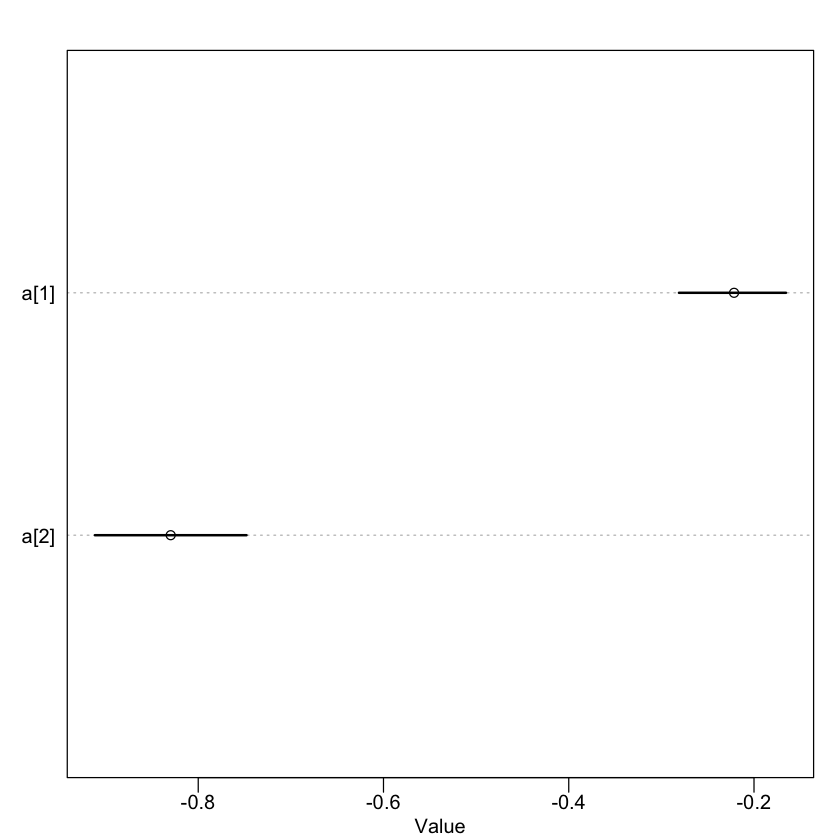

In [33]:
par(bg = 'white')
precis(m11.7, depth = 2)
plot(precis(m11.7, depth = 2))

So the mean for males is higher than for females (on the logit scale). Let's see how much higher relatively (shark) and absolutely (relative deer).

In [34]:
post <- extract.samples(m11.7)
diff_a <- post$a[, 1] - post$a[, 2]
diff_p <- inv_logit(post$a[, 1]) - inv_logit(post$a[, 2])
precis(list(diff_a=diff_a, diff_p=diff_p))

mean      sd         5.5%      94.5%     histogram   
diff_a 0.6081919 0.06430635 0.5035140 0.7125553 ▁▁▁▁▃▇▇▃▂▁▁ 
diff_p 0.1410493 0.01443811 0.1175834 0.1645494 ▁▁▁▁▂▃▇▇▃▂▁▁

So the probability for males is definitely higher - about 12% - 16% higher.

Let's speculate as to the cause of this. Plot the posterior predictions.

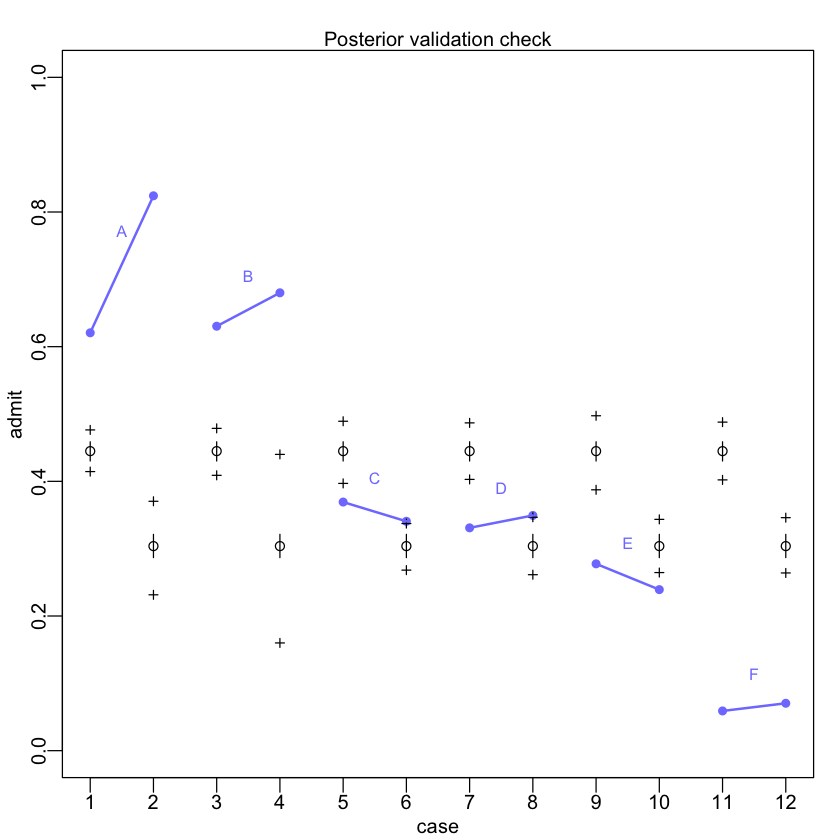

In [35]:
par(bg = 'white')
postcheck(m11.7)

# connect the points from the same department
for (i in 1:6) {
    x <- 1 + 2 * (i - 1)
    y1 <- d$admit[x] / d$applications[x]
    y2 <- d$admit[x + 1] / d$applications[x + 1]
    lines(c(x, x+1), c(y1, y2), col = rangi2, lwd = 2)
    text(x + 0.5, (y1 + y2) / 2 + 0.05, d$dept[x], cex = 0.8, col = rangi2)
}

These predictions are pretty awful; only two departments had a lower rate of admission than men, yet the model predicts that the rate for women should be 14% lower.

This is an example of Simpson's Paradox.

Basically, the model is answering the question that we gave it - across *all departments*, what is the difference in admission rates for men and women? But women did not apply equally to all departments, and we are seeing the effect of this. In general, women tended not to apply to departments (A & B) with high aceptance rates and instead applied to ones with low acceptance rates (E & F).

We probably want to ask "What is the average difference in probability of admission between women and men within the same department?". We need to estimate the admission rate within the different departments.

$$
\begin{align*}
A_i &\sim \text{Binomial}(N_i, p_i) \\
\text{logi}(p) &= \alpha_{\text{GID}[i]} + \delta_{\text{DEPT}[i]} \\
\alpha_j &\sim \text{Normal}(0, 1.5) \\
\delta_k &\sim \text{Normal}(0, 1.5)
\end{align*}
$$

So this model has a universal male / female adjustment ($\alpha$) along with a department-specific adjustment ($\delta$).

In [36]:
# adding in the departmental index
dat_list$dept_id <- rep(1:6, each = 2)

m11.8 <- ulam(
    alist(
        admit ~ dbinom(applications, p),
        logit(p) <- a[gid] + delta[dept_id],
        a[gid] ~ dnorm(0, 1.5),
        delta[dept_id] ~ dnorm(0, 1.5)
    ),
    data = dat_list,
    chains = 4,
    iter = 4000
)


Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:    1 / 4000 [  0%]  (Warmup) 
Chain 1 Iteration:  100 / 4000 [  2%]  (Warmup) 
Chain 1 Iteration:  200 / 4000 [  5%]  (Warmup) 
Chain 1 Iteration:  300 / 4000 [  7%]  (Warmup) 
Chain 1 Iteration:  400 / 4000 [ 10%]  (Warmup) 
Chain 1 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 1 Iteration:  600 / 4000 [ 15%]  (Warmup) 
Chain 1 Iteration:  700 / 4000 [ 17%]  (Warmup) 
Chain 1 Iteration:  800 / 4000 [ 20%]  (Warmup) 
Chain 1 Iteration:  900 / 4000 [ 22%]  (Warmup) 
Chain 1 Iteration: 1000 / 4000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1100 / 4000 [ 27%]  (Warmup) 
Chain 1 Iteration: 1200 / 4000 [ 30%]  (Warmup) 
Chain 1 Iteration: 1300 / 4000 [ 32%]  (Warmup) 
Chain 1 Iteration: 1400 / 4000 [ 35%]  (Warmup) 
Chain 1 Iteration: 1500 / 4000 [ 37%]  (Warmup) 
Chain 1 Iteration: 1600 / 4000 [ 40%]  (Warmup) 
Chain 1 Iteration: 1700 / 4000 [ 42%]  (Warmup) 
Chain 1 Iteration: 1800 / 4000 [ 45%]  (Warmup) 

In [37]:
precis(m11.8, depth = 2)

mean       sd        5.5%       94.5%      rhat     ess_bulk
a[1]     -0.4801877 0.5067051 -1.2899245  0.3076754 1.004776 672.8404
a[2]     -0.3831281 0.5084475 -1.1874711  0.4301130 1.004671 675.2622
delta[1]  1.0608367 0.5091776  0.2648316  1.8738063 1.004677 679.6456
delta[2]  1.0173590 0.5111328  0.2165706  1.8404276 1.004617 689.0876
delta[3] -0.1991197 0.5098759 -1.0096185  0.6074035 1.004674 676.4325
delta[4] -0.2309150 0.5104545 -1.0402016  0.5863615 1.004494 682.3512
delta[5] -0.6735520 0.5125380 -1.4800344  0.1476060 1.004700 683.3706
delta[6] -2.2300758 0.5208330 -3.0608653 -1.3996685 1.005397 697.3947

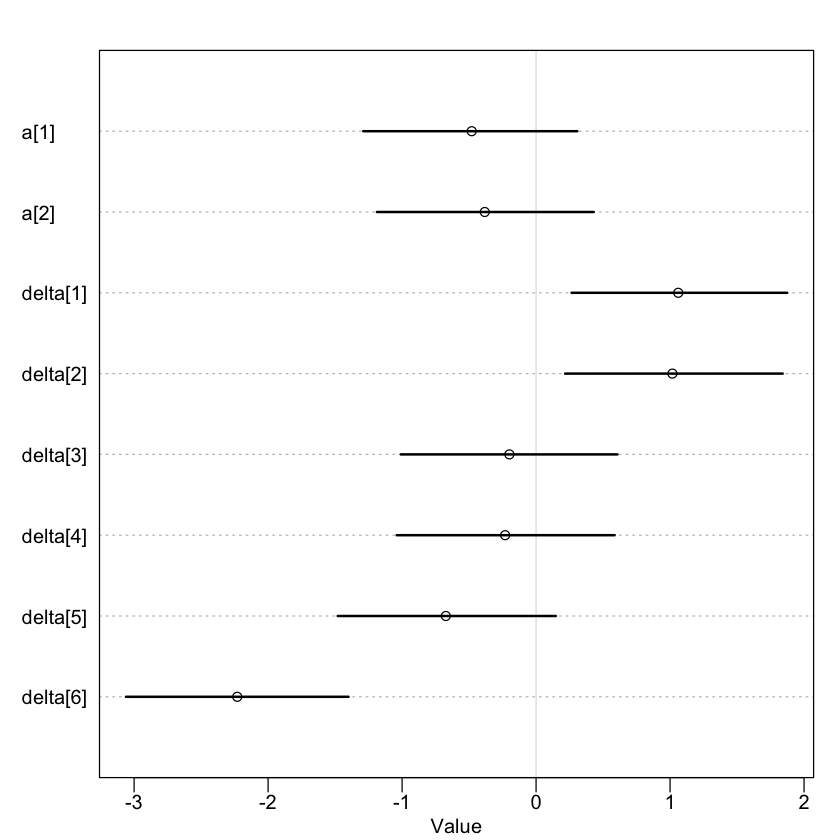

In [38]:
par(bg = 'white')
plot(precis(m11.8, depth = 2))

The intercept for male applicants is now a little smaller than for female ones. Let's calculate the contrasts again.

In [39]:
post <- extract.samples(m11.8)
diff_a <- post$a[, 1] - post$a[, 2]
diff_p <- inv_logit(post$a[, 1]) - inv_logit(post$a[, 2])
precis(list(diff_a=diff_a, diff_p=diff_p))

mean        sd        5.5%        94.5%      histogram    
diff_a -0.09705960 0.0813917 -0.22777864 0.03307494 ▁▁▁▂▅▇▇▅▂▁▁▁▁
diff_p -0.02201809 0.0187732 -0.05237983 0.00762094 ▁▁▂▇▇▂▁▁

Why did adding the department in make such a change, where now the male admission rate is about 2% lower than the female one? Again, the departments had wildly varying admission rates. Let's take a look.

In [40]:
pg <- with(dat_list,
    sapply(1:6, function(k) {
        applications[dept_id == k]/sum(applications[dept_id == k])
    })
)
rownames(pg) <- c("Male", "Female")
colnames(pg) <- unique(d$dept)
round(pg, 2)

A    B    C    D    E    F   
Male   0.88 0.96 0.35 0.53 0.33 0.52
Female 0.12 0.04 0.65 0.47 0.67 0.48

These are the proportions of applications from men / women across the departments. As you can see, there is quite the wide range!

The department is probably a confound, in that it misleads us about the direct causal effect. However, it *isn't* a confound in the sense that it is probably a genuine causal path. In DAG form:

Plot coordinates for graph not supplied! Generating coordinates, see ?coordinates for how to set your own.



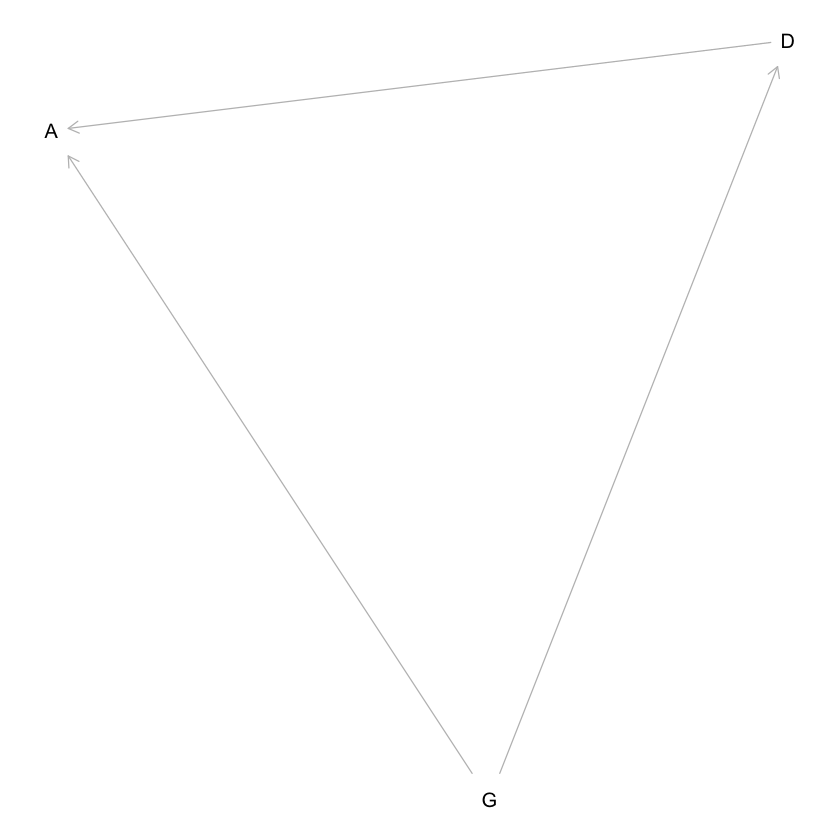

In [41]:
library(dagitty)

par(bg = 'white')
dag <- dagitty("dag{G -> D -> A; G -> A}")
plot(dag)

where here $G$ is the gender, $D$ is the department, and $A$ is the acceptance rate.

In addition to the direct effect of $G$ on $A$, there is an indirect causal path through the department $D$. In order to find $G \to A$, we need to close that path by conditioning on $D$. Model `m11.8` does this.

This is an example of **Mediation Analysis**.

However, we shouldn't stop there. Our DAG might be wrong. What if there is another unobserved confound that is affecting both the department and the admissions rate?

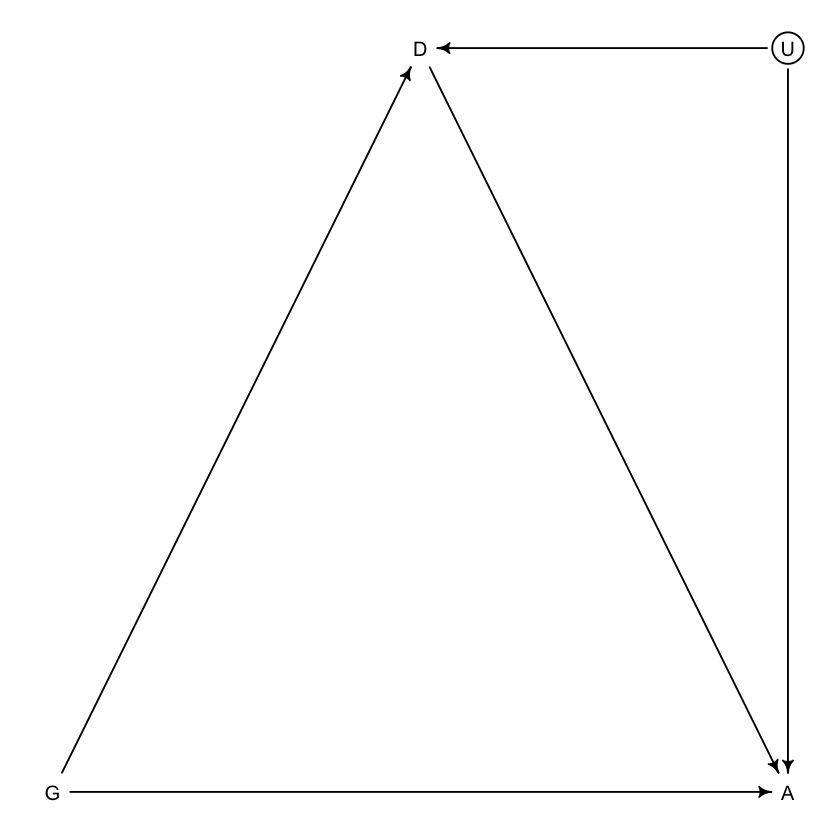

In [42]:
library(dagitty)

dag <- dagitty('dag{
    G[pos="0, 0"]
    A[pos="1, 0"]
    D[pos="0.5, -0.5"]
    U[latent,pos="1,-0.5"]
    G -> D -> A; G -> A; D <- U -> A}')
par(bg = 'white')
drawdag(dag)

That unobserved $U$ could be a host of things - maybe academic ability? Note this if this DAG is correct, then by conditioning on $D$ we are really conditioning on a collider, opening up a non-causal path between $G$ and $A$: $G \to D \leftarrow U \to A$.

## Poisson Regression

Binomial GLMs should be used when the count is from 0 to some upper bound that we know about. However, sometimes we don't know the upper bound; in these cases, we should use a Poisson regression. For instance, what if we go fishing and return with 17 fish? It is unclear in this case what the theoretical upper bound would be.

Recall that the Poisson is a special case of the binomial where $n$ is very large and $p$ is very small. Then the mean and variance become basically the same, and we get the **Poisson Distribution**.

The model with a Poisson distribution is even simpler, since there is just one parameter: $\lambda$, the expected average rate of events.

$$
y_i \sim \text{Poisson}(\lambda)
$$

Since $\lambda$ needs to be positive, we conventionally use a log link function here

$$
\begin{align*}
y_i &\sim \text{Poisson}(\lambda_i) \\
\log(\lambda_i) &= \alpha_i + \beta (x_i - \bar{x})
\end{align*}
$$

One thing to keep in mind is that since we are using the log link, it implies that the rate scales exponentially with the predictor variable, which may be unrealistic.

### Example: Oceanic tool complexity

Different island societies in Oceania provide natural experiments in technological evolution. Different islands had many different types of tools. One theory is that larger populations will produce more complex tool kits.

In [43]:
data(Kline)
d <- Kline
d

culture    population contact total_tools mean_TU
1  Malekula     1100     low     13          3.2    
2  Tikopia      1500     low     22          4.7    
3  Santa Cruz   3600     low     24          4.0    
4  Yap          4791     high    43          5.0    
5  Lau Fiji     7400     high    33          5.0    
6  Trobriand    8000     high    19          4.0    
7  Chuuk        9200     high    40          3.8    
8  Manus       13000     low     28          6.6    
9  Tonga       17500     high    55          5.4    
10 Hawaii     275000     low     71          6.6

This data show counts and amount of inter-island conflict for 10 different islands in Oceania (historical data). We'll use `total_tools` as the outcome and model
1. Number of tools increases with the log of population size (mostly because we care about the *order of magnitude of the population)
1. Number of tools increases with `contact`
1. Impact of population on tool counts is moderated by high `contact`. That is, the association between the `total_tools` and hte log `poulation` depends on `contact`; we'll look for a positive interaction between log `population` and `contact` rate.

In [44]:
d$P <- scale(log(d$population))
d$contact_id <- ifelse(d$contact == "high", 2, 1)

$$
\begin{align*}
T_i &\sim \text{Poisson}(\lambda_i) \\
\log (\lambda_i) &= \alpha_{\text{CID}[i]} + \beta_{\text{CID}[i]} \log P_i \\
\alpha_j &\sim \text{TBD} \\
\beta_j &\sim \text{TBD} \\
\end{align*}
$$

As with before, we need to do some experimentation to find sensible priors. To get an idea, let's start with a simpler model.

$$
\begin{align*}
T_i &\sim \text{Poisson}(\lambda_i) \\
\log \lambda_i &= \alpha \\
\alpha &\sim \text{Normal}(0, 10)
\end{align*}
$$

If $\alpha$ has a normal distribution, then $\lambda$ has a log-normal distribution. So, let's plot that!

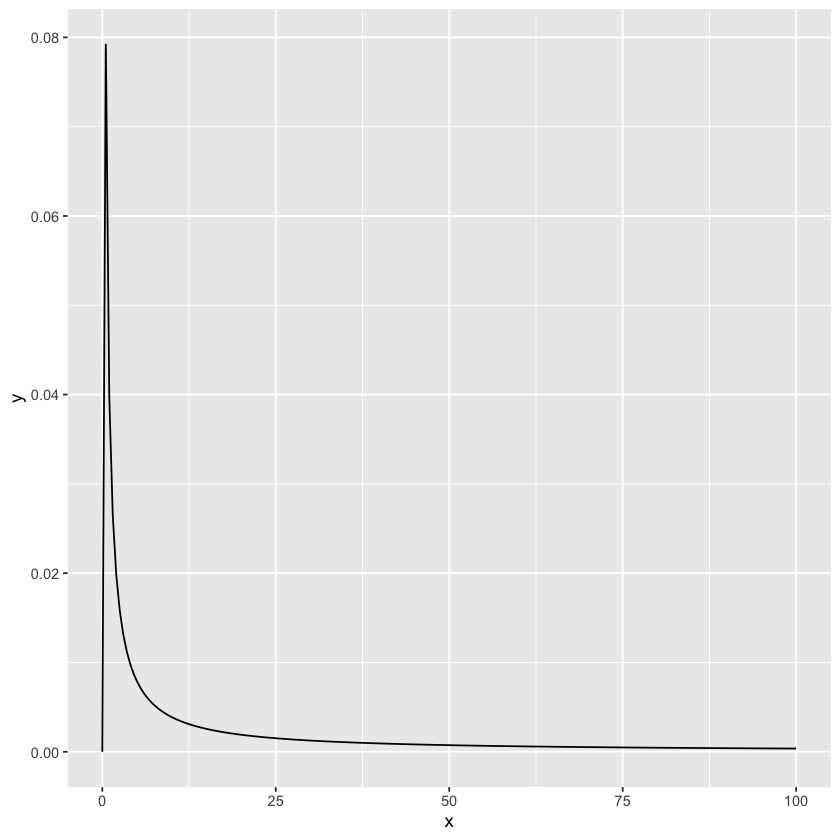

In [45]:
x <- seq(0, 100, length.out = 200)
y <- dlnorm(x, 0, 10)
ggplot(data.frame(x=x, y=y), aes(x, y)) +
    geom_line()

This doesn't work - it has a huge spike at 0 and and average of about 1e12 unique tool types per island, which is clearly absurd. One way to fix this is to shift the mean above zero, since the log scale will transform anything below 0 to be between 0 and 1 on the new scale.

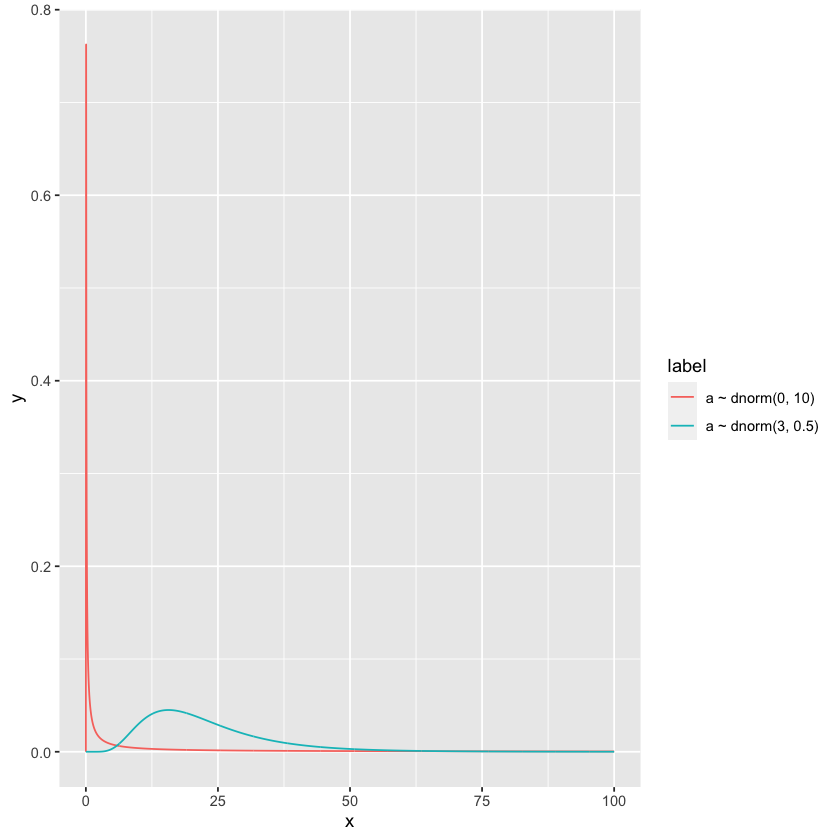

In [46]:
x <- seq(0, 100, length.out = 2000)
y1 <- dlnorm(x, 0, 10)
y2 <- dlnorm(x, 3, 0.5)
ggplot(rbind(data.frame(x=x, y=y1, label="a ~ dnorm(0, 10)"), data.frame(x=x, y=y2, label="a ~ dnorm(3, 0.5)")), aes(x, y, group = label, colour = label)) +
    geom_line()


The mean is now about 20, which is definitely more plausible.

What about the prior for $\beta$? Let's use our existing prior for $\alpha$ and simulate a bunch of different population effects.

Warning message:
“Removed 7985 rows containing missing values (`geom_line()`).”


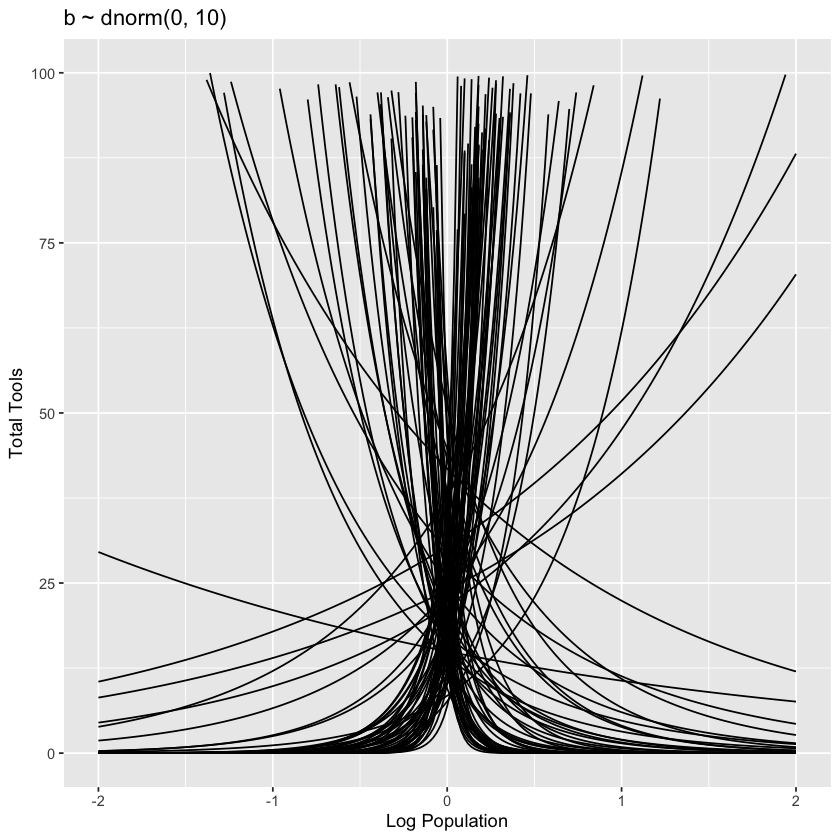

In [47]:
N <- 100
a <- rnorm(N, 3, 0.5)
b <- rnorm(N, 0, 10)

x <- seq(-2, 2, length.out = 201)
plot_df <- data.frame(x = numeric(), y = numeric(), n = integer())

for (i in 1:N) {
    y <- exp(a[i] + b[i] * x)
    interim_df <- data.frame(
        x = x,
        y = y,
        n = i
    )
    plot_df <- rbind(plot_df, interim_df)
}

ggplot(
    plot_df, aes(x, y, group = n)
) +
    geom_line() +
    labs(
        x = 'Log Population',
        y = "Total Tools",
        title = "b ~ dnorm(0, 10)"
    ) +
    ylim(c(0, 100))

Again, these priors are not great. They all tend to think that either the growth will be explosive around the population mean or ecline precipitously around the same. Neither of these are all that plausible.

After some experimentation, let's try $\beta \sim \text{Normal}(0, 0.2)$:

Warning message:
“Removed 86 rows containing missing values (`geom_line()`).”


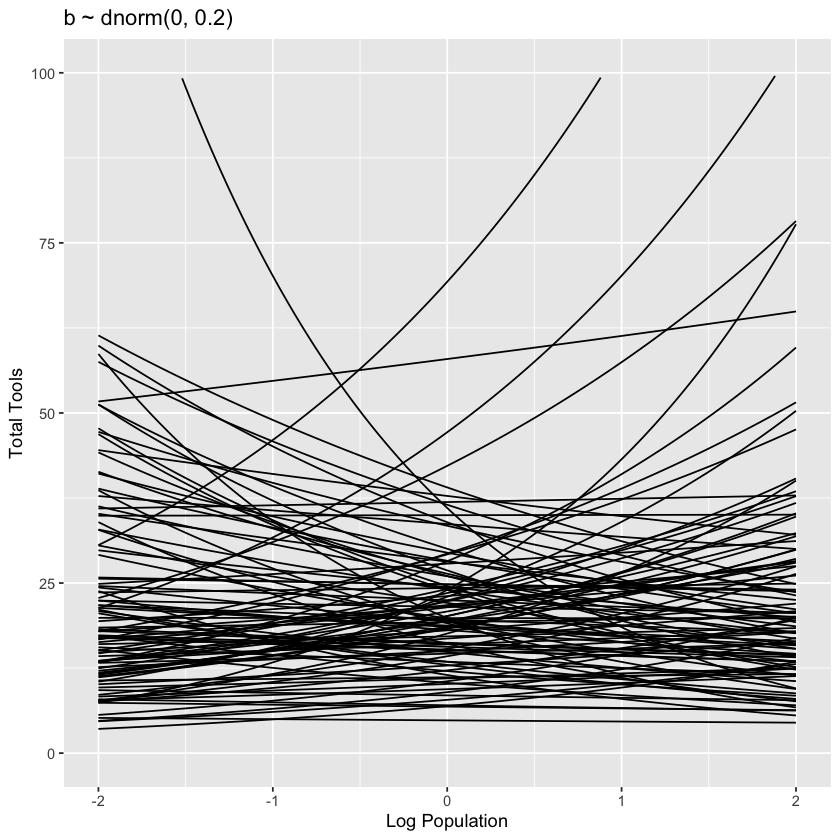

In [48]:
N <- 100
a <- rnorm(N, 3, 0.5)
b <- rnorm(N, 0, 0.2)

x <- seq(-2, 2, length.out = 201)
plot_df <- data.frame(x = numeric(), y = numeric(), n = integer())

for (i in 1:N) {
    y <- exp(a[i] + b[i] * x)
    interim_df <- data.frame(
        x = x,
        y = y,
        n = i
    )
    plot_df <- rbind(plot_df, interim_df)
}

ggplot(
    plot_df, aes(x, y, group = n)
) +
    geom_line() +
    labs(
        x = 'Log Population',
        y = "Total Tools",
        title = "b ~ dnorm(0, 0.2)"
    ) +
    ylim(c(0, 100))

These priors seem much more reasonable. There is still the poosibility of strong relationships, but most of the results are pretty flat, which is what we are looking for.

These priors can also be a bit hard to interpret because we are using a normalized scale, not the actual population or log population. Let's see what we get if we use the more natural scale:

Warning message:
“Removed 583 rows containing missing values (`geom_line()`).”


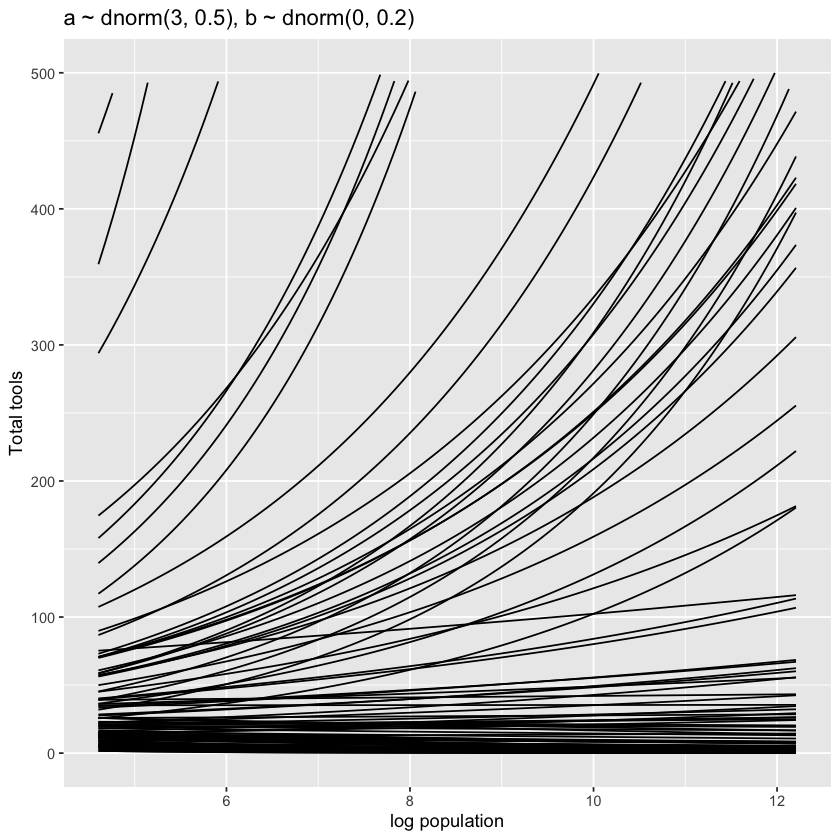

In [49]:
x_seq <- seq(from = log(100), to = log(200000), length.out = 100)
# this is a matrix where each row corresponds to the y values for that x
lambda <- sapply(x_seq, function(x) exp(a + b * x))

plot_df <- data.frame(x = numeric(), y = numeric(), a = numeric(), b = numeric())

for (i in 1:N) {
    interim_df <- data.frame(
        x = x_seq,
        y = exp(a[i] + b[i] * x_seq),
        a = rep(a[i], length(x_seq)),
        b = rep(b[i], length(x_seq))
    )
    plot_df <- rbind(plot_df, interim_df)
}

ggplot(plot_df, aes(x, y, group = interaction(a, b))) +
    geom_line() +
    ylim(c(0, 500)) +
    labs(x = 'log population', y = 'Total tools', title = "a ~ dnorm(3, 0.5), b ~ dnorm(0, 0.2)")

This looks much better! We can also plot against the raw population:

Warning message:
“Removed 583 rows containing missing values (`geom_line()`).”


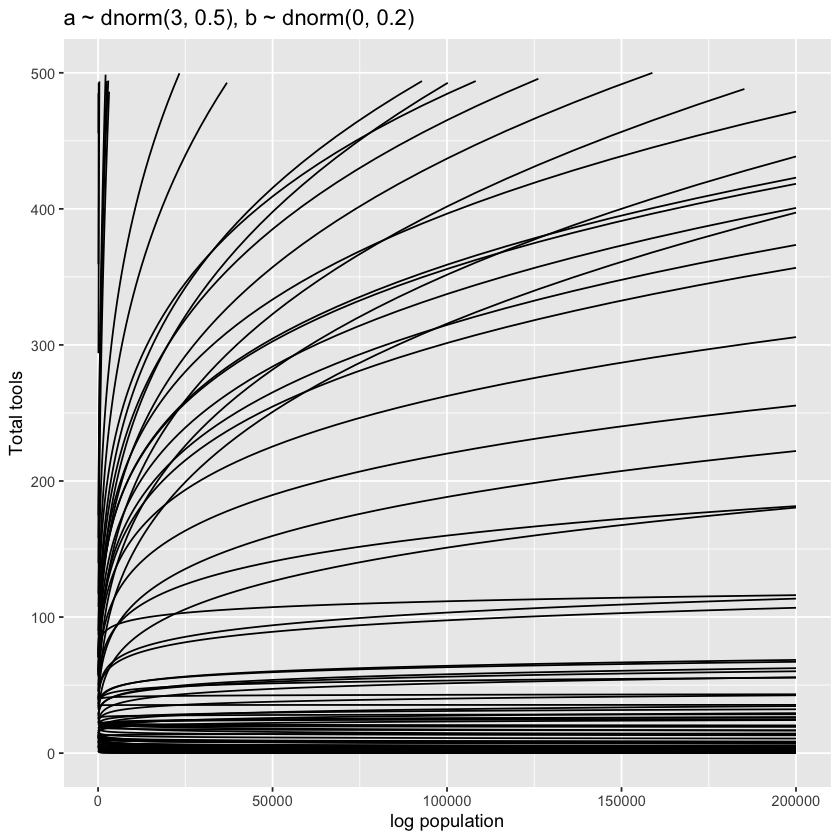

In [50]:
raw_population_plot_df <- plot_df
raw_population_plot_df$x <- exp(raw_population_plot_df$x)

ggplot(raw_population_plot_df, aes(x, y, group = interaction(a, b))) +
    geom_line() +
    ylim(c(0, 500)) +
    labs(x = 'log population', y = 'Total tools', title = "a ~ dnorm(3, 0.5), b ~ dnorm(0, 0.2)")

Note that now the curves bend in the opposite direction! **Poisson models** with a log link create log-linear relationships with the predictor variables. If the predictor variable is itself logged, then that means that we are assuming a *diminishing rate of return* for that variable. In our case, each additional person contributes a smaller increase in the expected number of tools.

This pattern is true of lots of things, which is one of the advantages of using logarithms.

Now let's code two models: one simple one (intercept-only), and the other with both parameters.

In [51]:
dat <- list(
    T = d$total_tools,
    P = d$P,
    cid = d$contact_id
)

# intercept only
m11.9 <- ulam(
    alist(
        T ~ dpois(lambda),
        log(lambda) <- a,
        a ~ dnorm(3, 0.5)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)

# interaction model
m11.10 <- ulam(
    alist(
        T ~ dpois(lambda),
        log(lambda) <- a[cid] + b[cid] * P,
        a[cid] ~ dnorm(3, 0.5),
        b[cid] ~ dnorm(0, 0.2)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)


Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

In [52]:
compare(m11.9, m11.10, func = PSIS)

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



PSIS      SE       dPSIS    dSE      pPSIS    weight     
m11.10  85.44932 13.26048  0.00000       NA 7.031250 1.00000e+00
m11.9  139.54714 32.87346 54.09782 31.93818 6.913467 1.78981e-12

Unsurprisingly, m11.10 does a better job than the intercept-only model m11.9. What is surprising is that the effective number of parameters pPSIS is *larger* for the model with only a single parameter. This is due to the link function. Once we go non-linear, then we stop being able to easily interpret pPSIS. Basically, parameters near the cut-off point contribute less overfitting than those far from the boundary, which has some surprising effects on pPSIS.

Bottom line: overfitting risk depends on *both* the structural complexity of the model and the composition of the sample.

In this model, a major source of overfitting risk is in the points that were flagged by PSIS. Let's examine them!

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



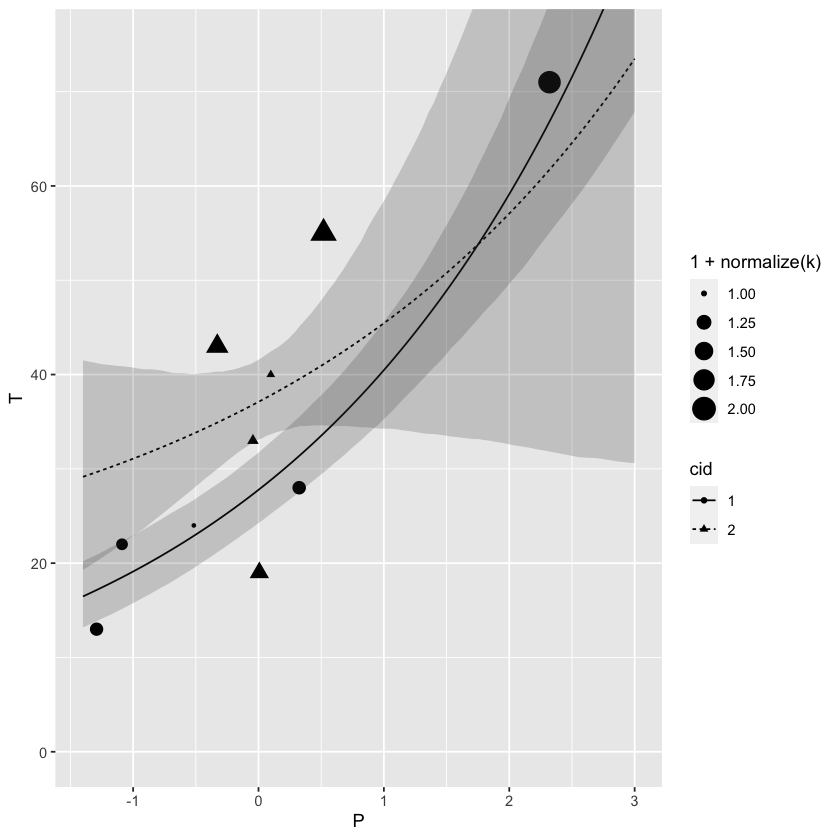

In [53]:
k <- PSIS(m11.10, pointwise = TRUE)$k

# setting up the predictions
ns <- 100
P_seq <- seq(from = -1.4, to = 3, length.out = ns)

#low contact (cid = 1) predictions
lambda <- link(m11.10, data = data.frame(P = P_seq, cid = 1))
lmu <- apply(lambda, 2, mean)
lci <- apply(lambda, 2, PI)
low_contact_df <- data.frame(
    P = P_seq,
    mu = lmu,
    lower = lci[1, ],
    upper = lci[2, ],
    cid = 1
)

# high contact (cid = 2) predictions
lambda <- link(m11.10, data = data.frame(P = P_seq, cid = 2))
lmu <- apply(lambda, 2, mean)
lci <- apply(lambda, 2, PI)
high_contact_df <- data.frame(
    P = P_seq,
    mu = lmu,
    lower = lci[1, ],
    upper = lci[2, ],
    cid = 2
)

predictions <- rbind(low_contact_df, high_contact_df)
predictions$cid <- factor(predictions$cid)

plot_df <- data.frame(P = dat$P, T = dat$T, cid = factor(dat$cid), k = k)
ribbon_df <- data.frame(P = predictions$P, lower = predictions$lower, upper = predictions$upper, cid = factor(predictions$cid))
ggplot() +
    geom_point(data = plot_df, mapping = aes(x = P, y = T, shape = cid, size = 1 + normalize(k))) +
    geom_line(data = predictions, mapping = aes(P, mu, linetype = cid)) +
    geom_ribbon(data = ribbon_df, mapping = aes(x = P, ymin = lower, ymax = upper, group = cid), alpha = 0.2)  +
    coord_cartesian(ylim = c(0, 75))

We can also do the same, but on the regular population scale, just by 'un-converting' `P`

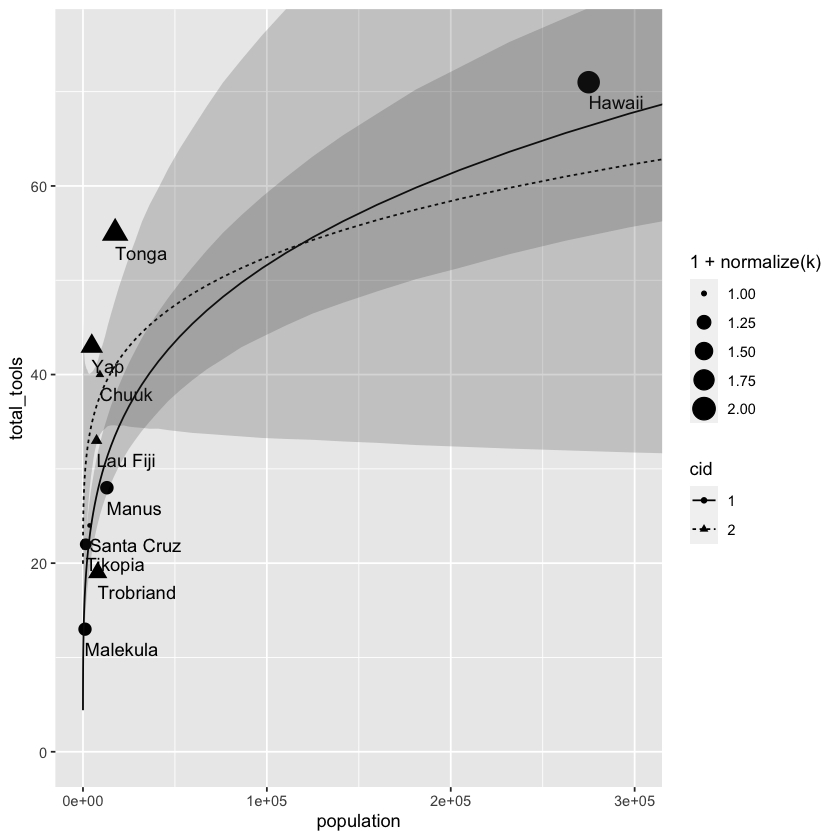

In [54]:
# setting up the predictions
ns <- 100
P_seq <- seq(from = -5, to = 3, length.out = ns)
pop_seq <- exp(P_seq * 1.53 + 9) # 1.53 is the sd of log (population); 9 is the mean

#low contact (cid = 1) predictions
lambda <- link(m11.10, data = data.frame(P = P_seq, cid = 1))
lmu <- apply(lambda, 2, mean)
lci <- apply(lambda, 2, PI)
low_contact_df <- data.frame(
    P = P_seq,
    mu = lmu,
    lower = lci[1, ],
    upper = lci[2, ],
    cid = 1
)

# high contact (cid = 2) predictions
lambda <- link(m11.10, data = data.frame(P = P_seq, cid = 2))
lmu <- apply(lambda, 2, mean)
lci <- apply(lambda, 2, PI)
high_contact_df <- data.frame(
    P = P_seq,
    mu = lmu,
    lower = lci[1, ],
    upper = lci[2, ],
    cid = 2
)

predictions <- rbind(low_contact_df, high_contact_df)
predictions$cid <- factor(predictions$cid)
predictions$population <- pop_seq

plot_df <- data.frame(population = d$population, total_tools = d$total_tools, cid = factor(dat$cid), k = k, culture = d$culture)
ribbon_df <- data.frame(population = pop_seq, lower = predictions$lower, upper = predictions$upper, cid = factor(predictions$cid))
ggplot() +
    geom_point(data = plot_df, mapping = aes(x = population, y = total_tools, shape = cid, size = 1 + normalize(k))) +
    geom_text(data = plot_df, mapping = aes(x = population, y = total_tools, label = culture), hjust = 0, vjust = 2) +
    geom_line(data = predictions, mapping = aes(population, mu, linetype = cid)) +
    geom_ribbon(data = ribbon_df, mapping = aes(x = population, ymin = lower, ymax = upper, group = cid), alpha = 0.2) + 
    coord_cartesian(xlim = c(0, 300000), ylim = c(0, 75))

There are a few points which are influential; Hawaii, Tonga, and Tap. We will deal with these later.

Also note that the model is quite silly; the high-contact line actually passes *under* the low-contact one. This is largely due to lack of data; there aren't any high-contact, large population societies (Hawaii is low-contact). But this still shouldn't happen; if we imagine a counterfactual where Hawaii was high-contact, we wouldn't expect the number of tools to go *down*.

Largely this is because we let the intercept be a free parameter. But that is incorrect! If we have 0 population, we know that we have 0 tools. We get this for free, and should probably integrate it into the model.

Instead of the GLM we created above, we could create a model which is constructured from our scientific understanding of *how* population and contact influence tool use. Maybe something that takes into account the fact that new tools are gradually developed, &c. One way of accounting for this might be to model some rate of innovation and take into account how each person has the potential to innovate, but with diminishing returns.

When we use this model we get better performance than the 'geocentric' GLM above, according to WAIC and PSIS. More importantly, the behaviour better reflects what we know to be true.

### Negative binomial (gamma-Poisson) models

Often a lot of unexplained variance in a Poisson model. Presumably this is because the rate varies from case to case. A very common extension of the Poisson GLM is to change the Poisson distribution to a **Negative Binomial** distribution. This is a special case of the Poisson (and is sometimes called the **Gamma-Poisson** distribution). It is a mixture of different Poisson distributions, in the same way that the **Student t** distribution is a mixture of **Normal distributions**.

### Example: Exposure and the offset

For a **Poisson distribution**, $\lambda$ can be thought of as the average number of events or as the rate; the two are equivalent. This lets us make models for which the exposure varies. For instance, maybe you have two different monastaries. From one you have the daily total of manuscripts created, and from the other you have the daily total. How can you reconcile these?

Implicitly, we can think of $\lambda$ being equal to the average number of events, $\mu$, per time unit, $\tau$. Thus, $\lambda = \mu / \tau$, so we can redo the link function as

$$
\begin{align*}
y_i &\sim \text{Poisson}(\lambda_i) \\
\log \lambda_i = \log \frac{\mu_i}{\tau_i} = \alpha + \beta x_i
\end{align*}
$$

We can also rewrite this as

$$
\log \lambda_i = \log \mu_i - \log \tau_i = \alpha + \beta x_i
$$

The $\tau$ values are the different exposures. If different observations have different exposures, then the expected value on row $i$ is

$$
\log \mu_i = \log\tau_i + \alpha + \beta x_i
$$

When $\tau_i = 1$, then $\log \tau_i = 0$ and we just have the regular Poisson GLM. But if the exposure varies from case to case, then $\tau_i$ scales how many events we expect to see.

$$
\begin{align*}
y_i &\sim \text{Poisson}(\mu_i) \\
\log \mu_i &= \log \tau_i + \alpha + \beta x_i
\end{align*}
$$

The $\log \tau$ term that we added is typically called the *offset*.

Let's look at an example using simulated data to ensure that we are getting the correct values back.

We own a monastery! The true rate of producting manuscripts is $\lambda = 1.5$ per day.

In [55]:
num_days <- 30
true_lambda <- 1.5
y <- rpois(num_days, true_lambda)

Now you're considering buying a new monastery, but this one keeps weekly totals. It turns out (although we don't know it) that the true rate at the new monastery is 0.5 per day.

In [56]:
num_weeks <- 4
new_true_lambda <- 0.5
y_new <- rpois(num_weeks, new_true_lambda * 7)

In [57]:
y_all <- c(y, y_new)
exposure <- c(rep(1, num_days), rep(7, num_weeks))
monastery <- c(rep(0, num_days), c(rep(1, num_weeks)))
d <- data.frame(y = y_all, days = exposure, monastery = monastery)

d

y days monastery
1  0 1    0        
2  0 1    0        
3  1 1    0        
4  1 1    0        
5  1 1    0        
6  1 1    0        
7  0 1    0        
8  2 1    0        
9  3 1    0        
10 0 1    0        
11 1 1    0        
12 2 1    0        
13 1 1    0        
14 0 1    0        
15 3 1    0        
16 0 1    0        
17 0 1    0        
18 2 1    0        
19 1 1    0        
20 1 1    0        
21 2 1    0        
22 1 1    0        
23 3 1    0        
24 1 1    0        
25 1 1    0        
26 3 1    0        
27 2 1    0        
28 0 1    0        
29 3 1    0        
30 1 1    0        
31 2 7    1        
32 4 7    1        
33 4 7    1        
34 8 7    1

In [58]:
# create the offset (log of the exposure)
d$log_days <- log(d$days)

m11.12 <- quap(
    alist(
        y ~ dpois(lambda),
        log(lambda) <- log_days + a + b * monastery,
        a ~ dnorm(0, 1),
        b ~ dnorm(0, 1)
    ),
    data = d
)

To compute the posterior distributions of $\lambda$ in each monastery, we sample form the posterior and then use the linear model, but without the offset. The offset is not used during predictions because the parameters are already on the daily scale.

In [59]:
post <- extract.samples(m11.12)
lambda_old <- exp(post$a)
lambda_new <- exp(post$a + post$b)
precis(data.frame(lambda_old, lambda_new))

mean      sd        5.5%      94.5%     histogram     
lambda_old 1.2223943 0.1981874 0.9329753 1.5619908 ▁▂▇▇▂▁▁▁      
lambda_new 0.6794961 0.1553942 0.4628275 0.9504016 ▁▁▂▇▇▅▃▁▁▁▁▁▁▁

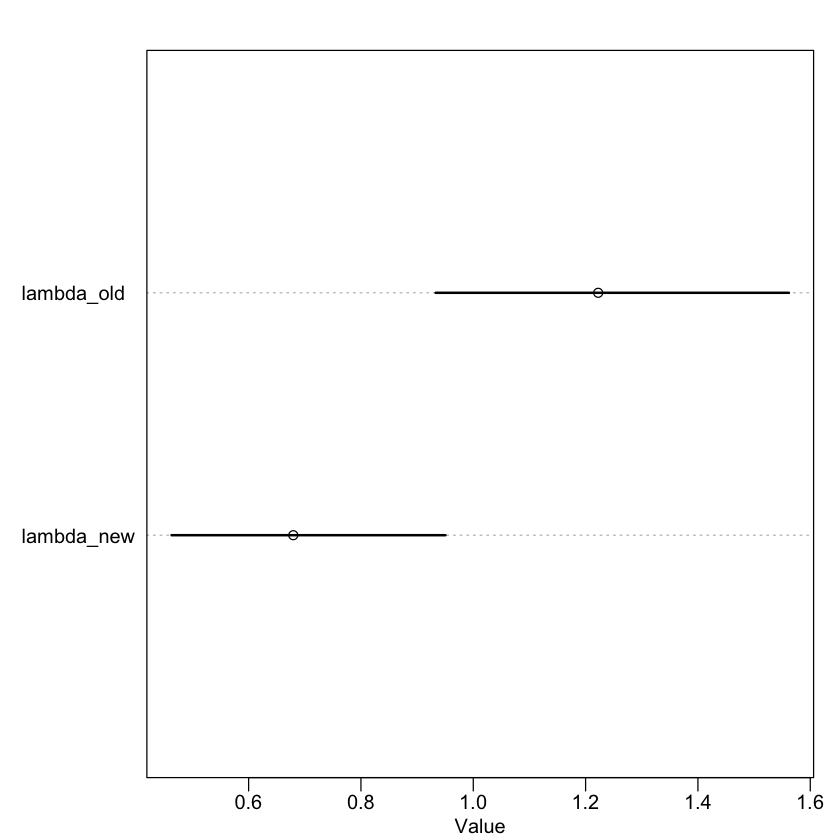

In [60]:
par(bg = 'white')
plot(
    precis(data.frame(lambda_old, lambda_new))
)

So it looks like this method works just like we expect!

## Multinomial and categorical variables

The binomial works when there are only two outcomes, but in general, more than two things can happen! For instance, recally that in **Chapter 2** we were drawing blue and white marbles from the bag. Since there were only two types, we used the binomial distribution. Now suppose that we add red marbles to the bag. Now we can't! We have to use the **Multinomial Distribution** instead.

The probability distribution for the **multinomial** looks a lot like for the binomial. If we $K$ types of events and each has probability $p_1, p_2, \ldots, p_K$, then the probability of seeing $y_1$ of type 1, $y_2$ of type 2, $\ldots$ $y_K$ of type $K$ is 

$$
\text{P}(y_1, y_2, \dots, y_K | n, p_1, \dots, p_K) = \frac{n!}{\Pi_i y_i!}\Pi_{i=1}^K p_i^{y_i}
$$

A model built on the **multinomial** is called a **Categorial regression**, usually when each event is expressed on one row (like in logistic regression). In machine learning, this model is sometimes known as the **maximum entropy classifier**. It's complicated to build a model, since as the number of events increases, so do the number of choices that we have to make about modelling those events.

There are two main approaches. One uses a generalization of the **logit link** (we'll call this the *explicit* approach). The second transforms the **multinomial** likelihoods into a series of **Poisson** likelihoods.

The natural (and conventional) link is the **Multinomial logit**, also known as the **Softmax function**. This link takes a vector of scores, one for each of the $K$ event types, and computes the probability of a particular type of event $k$ as

$$
\text{Pr}(k | s_1, s_2, \dots, s_k) = \frac{e^{s_k}}{\sum_{i=1}^{K}e^{s_i}}
$$

This type of model (with the `softmax` link) is called the **Multinomial logistic regression**.

The biggest issue is what to do with the multiple linear models. In the **binomial** GLM, we just had to pick one of the two outcomes and build a linear model for its log-odds; then the other one was handled automatically. In a **multinomial** GLM, we need $K-1$ models for the $K$ events. One of the outcomes is chosen as the *pivot* (that's the one that we won't model explicitly). In the other $K-1$ linear models, we can pick whatever predictor variables we want. In general, they won't be the same for the different event types.

There are two basic cases:
1. Predictors have different values for different values of the outcome, and
1. Parameters are distinct for each value of the outcome.

The first case is useful when each type of event has its own quantitative traits and you want to estimate the association between those trains and the proability each type of event appears in the data.

The second case is useful when you are interested instead in features of some entity that produces each event, whatever type it turns out to be.

We'll consider each case separately and go through an example of each. You can mix both types in the same model, but it'll be clearer if we keep them distinct for now.

### Predictor matched to outcomes

We're modelling choice of careers for young adults. One of the predictors will be expected income. In that case, $\beta_{\text{income}}$ appears in each linear model, but a *different* income value multiplies the parameter in each linear model.

Here's a simulation in R. We are simulating career choice between three different careers, each of which has its own income trait. This is then used to assign a score to each type of event. When the model is fit to the data, one of the scores is held constant and the other two are estimated.

In [61]:
N <- 500 # number of individuals
income <- c(1, 2, 5)
score <- 0.5 * income

# convert scores to probabilities
p <- softmax(score[1], score[2], score[3])

# now simulate the choices
# outcome career holds event type values, not counts
career <- rep(NA, N)

# randomly choose the career for each individual
set.seed(34302)
for (i in 1:N) {
    career[i] <- sample(1:3, size = 1, prob = p)
}

To fit the model, we use the `dcategorical` likelihood, which is the multinomial logistic regression distribution. It works when each value in the outcome variable (`career`) contains the individual event type on each row.

To convert the scores to probabilities, we'll use the multinomial logit link (`softmax`). Then each career gets its own linear model. There are no intercepts in the simulation above, but if income doesn't predict career choice, you still want an intercept to account for differences in frequency.

In [62]:
# Doing it in Stan!

code_m11.13 <- "
data {
    int N; // number of individuals
    int K; // number of careers
    array[N] int career; // outcome
    vector[K] career_income;
}
parameters {
    vector[K-1] a; // intercepts
    real<lower=0> b; // association of income with choice
}
model {
    vector[K] p;
    vector[K] s;
    a ~ normal(0, 1);
    b ~ normal(0, 0.5);
    s[1] = a[1] + b * career_income[1];
    s[2] = a[2] + b * career_income[2];
    s[3] = 0; // pivot
    p = softmax(s);
    career ~ categorical(p);
}
"

dat_list <- list(
    N = N,
    K = 3,
    career = career,
    career_income = income
)
m11.13 <- stan(model_code = code_m11.13, data = dat_list, chains = 4)

Running MCMC with 4 sequential chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling)

See https://mc-stan.org/misc/warnings for details.




In [63]:
precis(m11.13, 2)

mean       sd        5.5%         94.5%      n_eff    Rhat4   
a[1] -2.1308811 0.1885815 -2.438134550 -1.8439118 503.6699 1.011036
a[2] -1.7869542 0.2545804 -2.252708600 -1.4450158 357.8658 1.015904
b     0.1317465 0.1149318  0.006917019  0.3559642 316.8830 1.020361

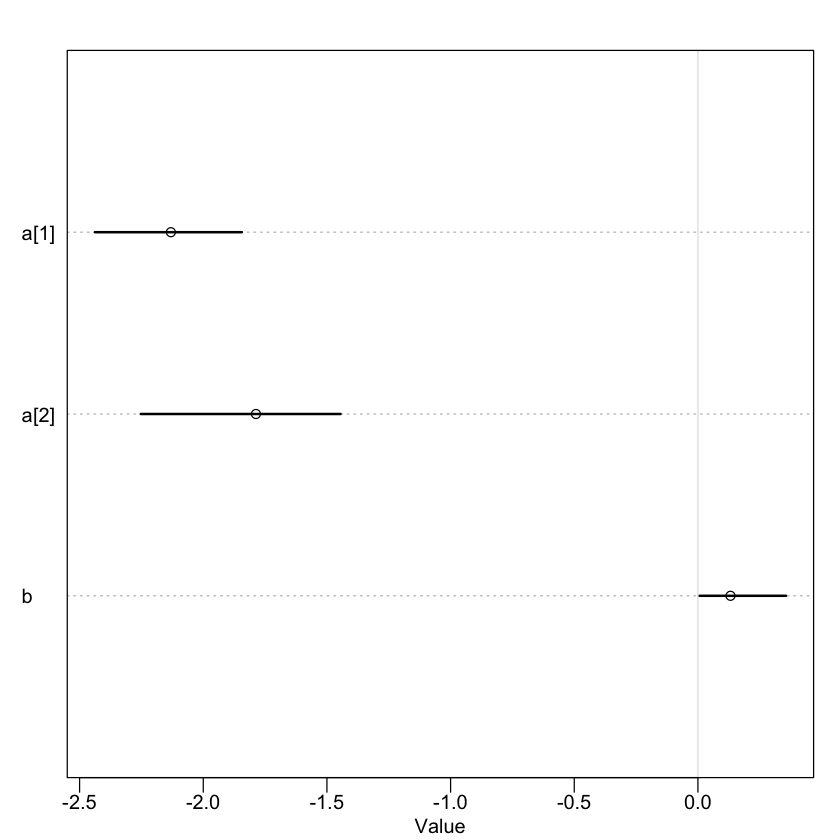

In [64]:
par(bg = 'white')
plot(precis(m11.13, 2))

It's very difficult to figure out what these actually mean. We arbitrarily chose the third career to be the pivot, but we could have chosen any of them. In that case the actual numbers we got out would be different but the proedictions would have been the same.

To conduct a counterfactual experiment, we can extract the samples and make our own. We want to compare the counterfactual where the income is changed. Let's imagine doubling the income of career 2.

In [65]:
post <- extract.samples(m11.13)

# set up the logit scores
s1 <- with(post, a[, 1] + b * income[1])
s2_orig <- with(post, a[, 2] + b * income[2])
s2_new <- with(post, a[, 2] + b * income[2] * 2) # doubling the income

# compute probabilities for original and counterfactual
p_orig <- sapply(1:length(post$b), function(i) {
    softmax(c(s1[i], s2_orig[i], 0))
})
p_new <- sapply(1:length(post$b), function(i) {
    softmax(c(s1[i], s2_new[i], 0))
})

p_diff <- p_new[2, ] - p_orig[2, ]
precis(p_diff)

mean       sd         5.5%        94.5%     histogram
p_diff 0.04145759 0.04061757 0.001883568 0.1216541 ▇▂▁▁▁▁

So on average, a 4% increase in career choice when the income is doubled. (NB this number is different in the textbook - I'm not sure where I went wrong as the code is the same...). Note that this is dependent on the other careers; if they were different then this number would be as well. That's just how choices work - if you change the alternatives then you change the choice.

### Predictors matched to observations

Now consider a model where each observed outcome has unique predictor values. We'll still model career choice, but now we want to estimate the association between each person's family income and the career they choose. The predictor variable must have the same value in linear linear model, for each row of data. But now there's is a unique parameter multiplying it in each linear model. This provides an estimate of the impact of family income on choice, for each type of career.

In [66]:
N <- 500

# simulate family income for each student
family_income <- runif(N)

# assign a unique coefficient to each event
b <- c(-2, 0, 2)
career <- rep(NA, N)
for (i in 1:N) {
    score <- 0.5 * (1:3) + b * family_income[i] # now we're accounting for family income
    p <- softmax(score[1], score[2], score[3])
    career[i] <- sample(1:3, size = 1, prob = p)
}

code_m11.14 <- "
    data {
        int N; // observations
        int K; // careers
        array[N] int career; // the actual careers of the individuals
        array[N] real family_income; // the family income for each student
    }
    parameters {
        vector[K-1] a; // intercepts
        vector[K-1] b; // coefficients on family income
    }
    model {
        vector[K] p;
        vector[K] s;
        a ~ normal(0, 1.5);
        b ~ normal(0, 1);
        for ( i in 1:N ) {
            for (j in 1:(K-1)) {
                s[j] = a[j] + b[j] * family_income[i];
            }
            s[K] = 0; // pivot
            p = softmax(s);
            career[i] ~ categorical(p);
        }
    }
"

dat_list <- list(N = N, K = 3, career = career, family_income = family_income)
m11.14 <- stan(model_code = code_m11.14, data = dat_list, chains = 4)

Running MCMC with 4 sequential chains...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 2.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling)

In [67]:
precis(m11.14, 2)

mean       sd        5.5%      94.5%      n_eff    Rhat4    
a[1] -0.7744673 0.2509515 -1.194781 -0.3826142 898.6792 1.0026843
a[2] -0.7185261 0.2137498 -1.064691 -0.3804557 957.8916 1.0005249
b[1] -3.4570791 0.5535833 -4.330678 -2.5580449 914.3921 1.0024679
b[2] -1.2170905 0.3726337 -1.817545 -0.6312219 983.5261 0.9998387

Again, these are difficult to interpret. Probably the best way is to compute the implied predictions when you change the family income.

### Multinomial in disguise as Poisson

Another way to fit a multinomial / categorical model is to refactor it into a series of **Poisson** likelihoods. It sounds crazy, but is actually both common and pricipled to do it this way (it's justified by the mathematics and usually faster / easier to compute). Here's an example!

We'll use the binomial (special case of multinomial) and re do it as a **Poisson**. In this case, let's re-use the UC Berkeley admissions data.

In [68]:
data(UCBadmit)
d <- UCBadmit

# binomial model
m_binom <- quap(
    alist(
        admit ~ dbinom(applications, p),
        logit(p) <- a,
        a ~ dnorm(0, 1.5)
    ),
    data=d
)

dat <- list(admit = d$admit, rej = d$reject)
m_poisson <- ulam(
    alist(
        admit ~ dpois(lambda1),
        rej ~ dpois(lambda2),
        log(lambda1) <- a1,
        log(lambda2) <- a2,
        c(a1, a2) ~ dnorm(0, 1.5)
    ),
    data = dat,
    chains = 3,
    cores = 3
)

Running MCMC with 3 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain

In [69]:
# look at the posterior means
inv_logit(coef(m_binom))

a 
0.3877907

In the Poisson model, the implied probability of admission is

$$
P_{\text{admit}} = \frac{\lambda_1}{\lambda_1 + \lambda_2} = \frac{e^{a_1}}{e^{a_1} + e^{a_2}}
$$

In [70]:
k <- coef(m_poisson)
a1 <- k['a1']
a2 <- k['a2']
exp(a1) / (exp(a1) + exp(a2))

a1 
0.3876373

So we got the same answer both times! Normally we use the categorical distribution, but sometimes it's easier to do the Poisson (or you may encounter it in the wild), so it's good to know.

## Practice

### Easy

### 11E1 If an event has probability 0.35, what are the log-odds of the event?

In [71]:
p <- 0.35
log(p / (1 - p))

[1] -0.6190392

### 11E2 If an event has log-odds 3.2, what is the probability of the event?

$$
\begin{align*}
3.2 &= \log \frac{p}{1 - p} \\
e^{3.2} &= \frac{p}{1 - p} \\
e^{3.2} - e^{3.2}p &= p \\
\frac{e^{3.2}}{1 + e^{3.2}} &= p
\end{align*}
$$

In [72]:
exp(3.2) / (1 + exp(3.2))

[1] 0.9608343

### 11E3 Suppose that a coefficient in a logistic regression has value 1.7. What does this imply about the proportional change in odds of the outcome?

In a logistic regression, exponentiating the coefficient tells us the proportional change in odds.

In [73]:
exp(1.7)

[1] 5.473947

This implies that the proportional change in odds will be a five-fold increase for every increase in the underlying predictor. (Think analogously to the slope of a regression line: a one-unit change in x is associated with a ???? difference in y).

### 11E4 Why do Poisson regressions sometimes require the use of an *offset*? Provide an example.

They sometimes require an offset when there is a differing amount of exposure to the underlying causal phenomenon. For instance, we might be measuring the number of butterflies we see along a trail, but one person is measuring every 100m and the other every km. In a Poisson, $\lambda$ is the expected number of observations per unit of whatever (maybe in this case, $\lambda$ is 'butterflies per metre'). If the units are different, we can think of

$$
\lambda = \frac{\mu}{\tau}
$$

Where $\mu$ is the expected number of observations (recorded number per 100m or 1km, depending) and $\tau$ is the actual time / distance we are measuring for that particular observation (100m or 1km).

In a Poisson we generally use the log link, so then we have

$$
\log \lambda = \log \frac{\mu_i}{\tau_i} = \alpha + \beta x
$$

We really care about $\mu_i$, the normalized rate, so then we have

$$
\log \mu_i = \alpha + \beta x + \underbrace{\log \tau_i}_{\text{offset}}
$$

Basically, the offset accounts for the differing exposures across the observations.

### 11M1 As explained in the chapter, binomial data can be organized in aggregated and disaggregated forms without any influence on inference. However, the likellihood of the data des change when the data are converted between the two formats. Can you explain why?

Essentially, when you aggregate data you lose information --- specifically, you lose information about the order in which they occurred. This means that the likelihood of the aggregated data is higher than for the disaggregated one. For instance, rolling dice and getting a 1, then a 2 has probability 1/6 * 1/6 = 1 / 36. However, if we aggregate the data and just say that we rolled the dice and got a 1 and a 2 in some order, then we have a likelihood of 2 * 1/ 6 * 1 / 6 (since there are two orders that we could have rolled them in).

### 11M2 If a coefficient in a Poisson regression has a value of 1.7, what does this imply about the change in the outcome?

$$
\begin{align*}
y_i &\sim \text{Poisson}(\lambda_i) \\
\log \lambda_i &= \alpha + \beta x_i \\
\end{align*}
$$

if $\beta = 1.7$, then let's look at $x_i$ against $x_i + 1$.

$$
\begin{align*}
\log \lambda_{i, +1} - \log \lambda_i &= \alpha + \beta( x_i + 1) - (\alpha + \beta x_i) \\
    &= \beta \\
\log \frac{\lambda_{i, +1}}{\lambda_i} &= \beta \\
\frac{\lambda_{i, +1}}{\lambda_i} &= e^{\beta} \\
\lambda_{i, +1} &= e^\beta \lambda_i \\
    &= e^{1.7} \lambda_i \\
    &\approx 5.5 \lambda_i
\end{align*}
$$

In [74]:
exp(1.7)

[1] 5.473947

So if the coefficient is 1.7, that implies that a 1-unit increase in the exposure will result in the mean ($\lambda$) increasing by a factor of roughly 5.5.

### 11M3 Explain why a logit link is appropriate for a binomial generalized linear model.

The binomial generalized linear model, the basic form is

$$
\begin{align*}
y &\sim \text{Binomial}(n, p) \\
\text{logit}(p) &= \alpha + \beta x \\
\end{align*}
$$

A logit link maps something which is a probability (so lives in the range [0, 1]) onto a linear model. In a binomial generalized linear model, the parameter $p$ in the binomial is generally what we are modelling; since this is a probability, the logit link is appropriate.

### 11M4 Explain why the log link is appropriate for a Poisson generalized linear model

The Poisson generalized linear model is

$$
\begin{align*}
y &\sim \text{Poisson}(\lambda) \\
\log \lambda &= \alpha + \beta x \\
\end{align*}
$$

The log link ensures that the parameter $\lambda$ will be positive (as it must be), and so is appropriate for this model.

### 11M5 What would it imply to use a logit link for the mean of a Poisson generalized linear mode? Can you think of a real research problem for which that would make sense?

In this case, the model would look like

$$
\begin{align*}
y &\sim \text{Poisson}(\lambda) \\
\text{logit} \lambda &= \alpha + \beta x \\
\end{align*}
$$

This would imply that the mean is itself a probability. That would mean that we are modelling a count where the mean value is a probability. This almost feels like a binomial regression - like if you flipped some coins a bunch of times and recorded the percent of heads as the 'count'?

### 11M6 State the contraints fro which the binomial and Poisson distributions have maximum entropy. Are the constrains different at all for binomial and Poisson? Why or why not?

The binomial and Poisson are both the maximum entropy distributions for a set of $n$ trials where the expected number of some kind of outcome is the same. Because the Poisson is just a special case of the binomial, the constraints are the same.

### 11M7 Use `quap` to construct a quadratic approximate posterior distribution for the chimpanzee model that includes a unique intercept for each actor, `m11.4`. Compare the quadratic approximation to the posterior distribution produced instead from MCMC. Can you explain both the differences and the similarities between the approximate and the MCMC distributions? Relax the prior on the actor intercepts to $\text{Normal}(0, 10)$. Re-estimate the posterior using both `ulam` and `quap`. Do the differences increase or decrease? Why?

In [75]:
data(chimpanzees)
d <- chimpanzees
d$treatment <- 1 + d$prosoc_left + 2 * d$condition

# trimmed data list
dat_list <- list(
    pulled_left = d$pulled_left,
    actor = d$actor,
    treatment = as.integer(d$treatment)
)

m11.4_ulam <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = dat_list,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.4 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

In [76]:
m11.4_quap <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = dat_list
)

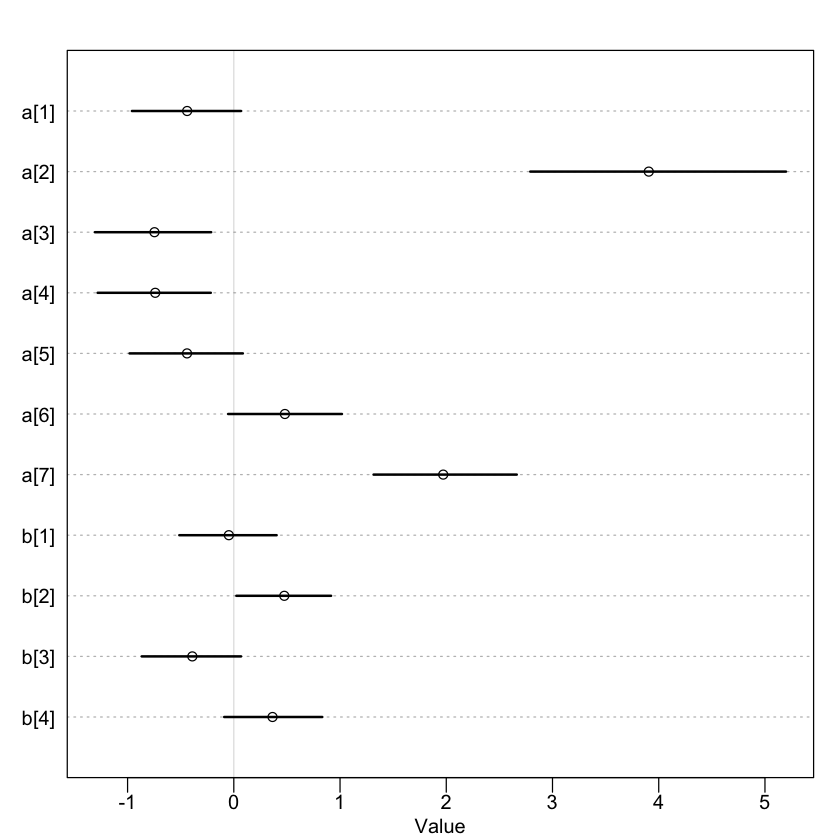

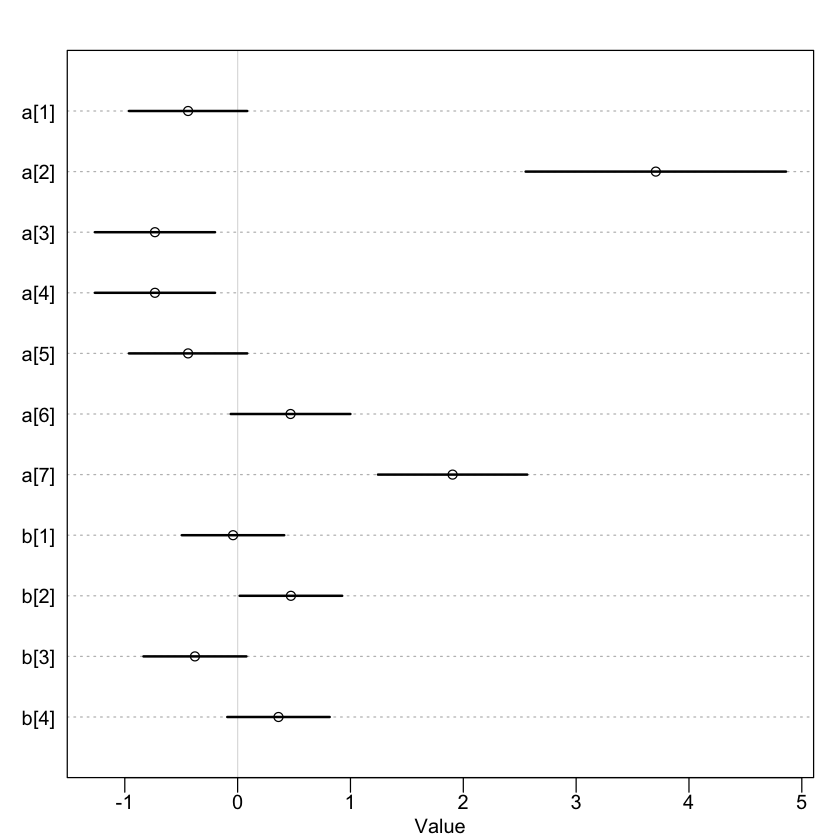

In [77]:
par(bg = 'white')
plot(precis(m11.4_ulam, depth = 2))
plot(precis(m11.4_quap, depth = 2))

These look basically identical. Let's try to plot them on the same set of axes to compare each paramter to the equivalent in the other model.

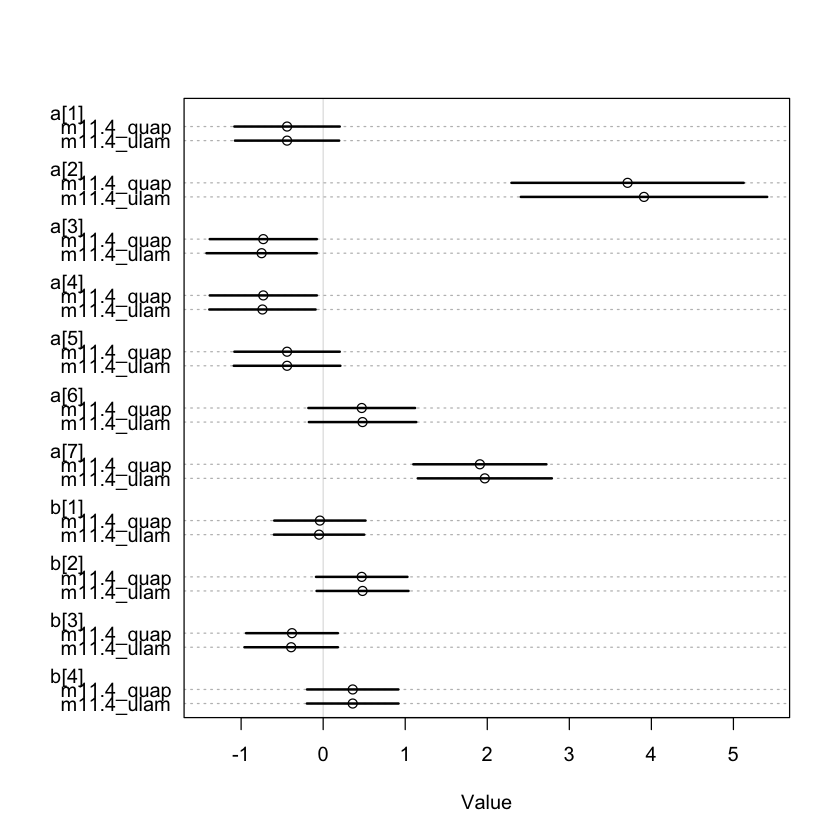

In [78]:
par(bg = 'white')
plot(coeftab(m11.4_ulam, m11.4_quap))

There is a very slight difference in the value for the second actor (one who only pulls right), but the rest seem to be the same. For that second actor, the quadratic approximation *underestimates* the value. This is probably due to asymmetry in the posterior distribution which is not captured by the (symmetric) normal.

In [79]:
quap_samples <- extract.samples(m11.4_quap)
a2_quap <- quap_samples[['a']][, 2]
ulam_samples <- extract.samples(m11.4_ulam)
a2_ulam <- ulam_samples[['a']][, 2]

plot_df <- rbind(
    data.frame(
        x = a2_quap, type = "Quap"
    ),
    data.frame(
        x = a2_ulam, type = "Ulam"
    )
)

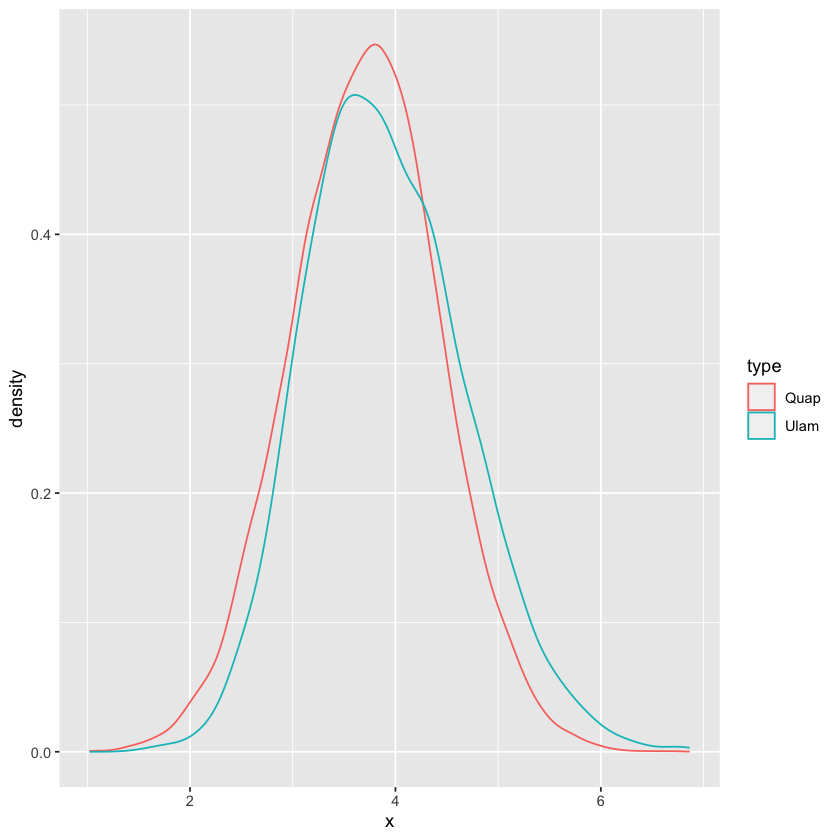

In [80]:
ggplot(plot_df, aes(x, group = type, colour = type)) +
    geom_density(aes(y = after_stat(density)))

We can see that `ulam` is putting slightly more weight on the upper part of the range, but not an enormous amount.

Now let's relax the actor priors to $\text{Normal}(0, 10)$ and see what happens.

In [81]:
m11.4_ulam_relaxed <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 10),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = dat_list,
    chains = 4,
    log_lik = TRUE
)
m11.4_quap_relaxed <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 10),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = dat_list
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.5 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

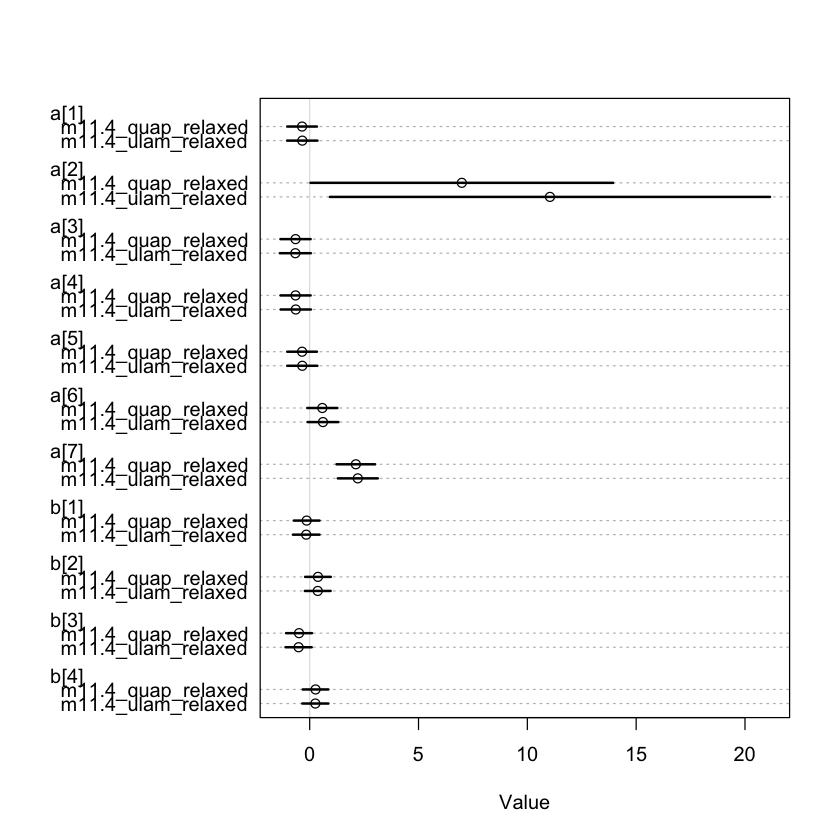

In [82]:
par(bg = 'white')
plot(coeftab(m11.4_ulam_relaxed, m11.4_quap_relaxed))

This definitely looks like it accentuated the differences! 

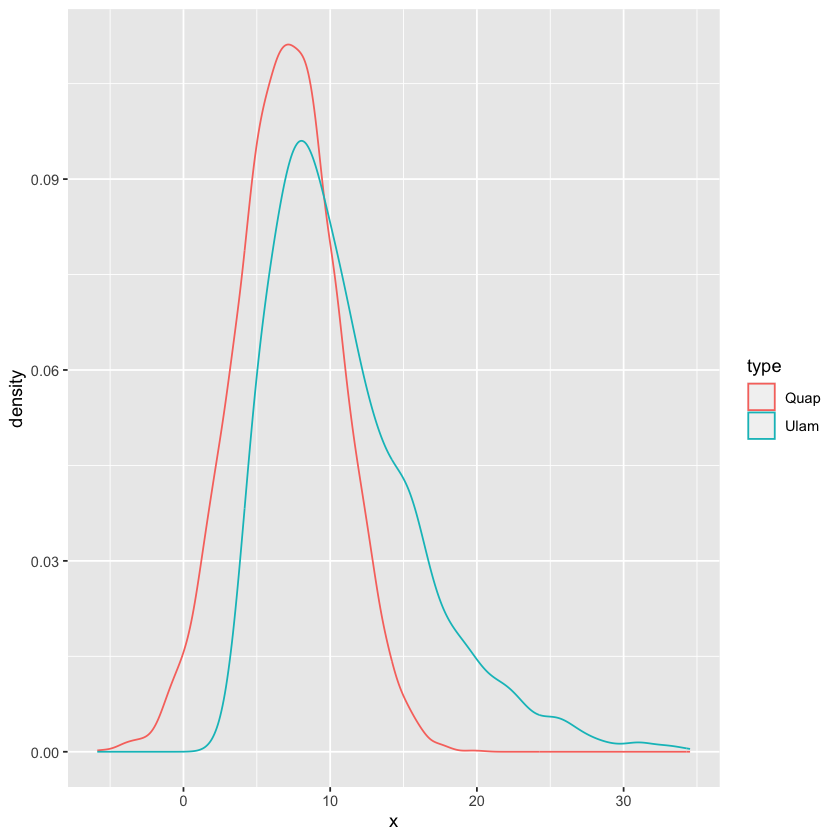

In [83]:
quap_samples <- extract.samples(m11.4_quap_relaxed)
a2_quap <- quap_samples[['a']][, 2]
ulam_samples <- extract.samples(m11.4_ulam_relaxed)
a2_ulam <- ulam_samples[['a']][, 2]

plot_df <- rbind(
    data.frame(
        x = a2_quap, type = "Quap"
    ),
    data.frame(
        x = a2_ulam, type = "Ulam"
    )
)
ggplot(plot_df, aes(x, group = type, colour = type)) +
    geom_density(aes(y = after_stat(density)))

From this it is far more apparent that the asymmetry of the posterior is not being reflected in the normal approximation. Probably this is because with the weaker prior, the actual asymmetry is greater than with a strong prior.

### 11M8 Revisit the `data(Kline)` islands example. This time drop Hawaii from the sample and refit the models. What changes do you observe?

In [84]:
data(Kline)
d <- Kline
d$P <- as.numeric(scale(log(d$population))) # this is required because otherwise P has a type of a 1-element list, which breaks STAN
# but for some reason didn't do that earlier
d$contact_id <- ifelse(d$contact == "high", 2, 1)

d_removed <- d[d$culture != 'Hawaii', ]

In [85]:

dat <- list(
    T = d$total_tools,
    P = d$P,
    cid = d$contact_id
)
dat_removed <- list(
    T = d_removed$total_tools,
    P = d_removed$P,
    cid = d_removed$contact_id
)
m11.10_original <- ulam(
    alist(
        T ~ dpois(lambda),
        log(lambda) <- a[cid] + b[cid] * P,
        a[cid] ~ dnorm(3, 0.5),
        b[cid] ~ dnorm(0, 0.2)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)
m11.10_removed <- ulam(
    alist(
        T ~ dpois(lambda),
        log(lambda) <- a[cid] + b[cid] * P,
        a[cid] ~ dnorm(3, 0.5),
        b[cid] ~ dnorm(0, 0.2)
    ),
    data = dat_removed,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



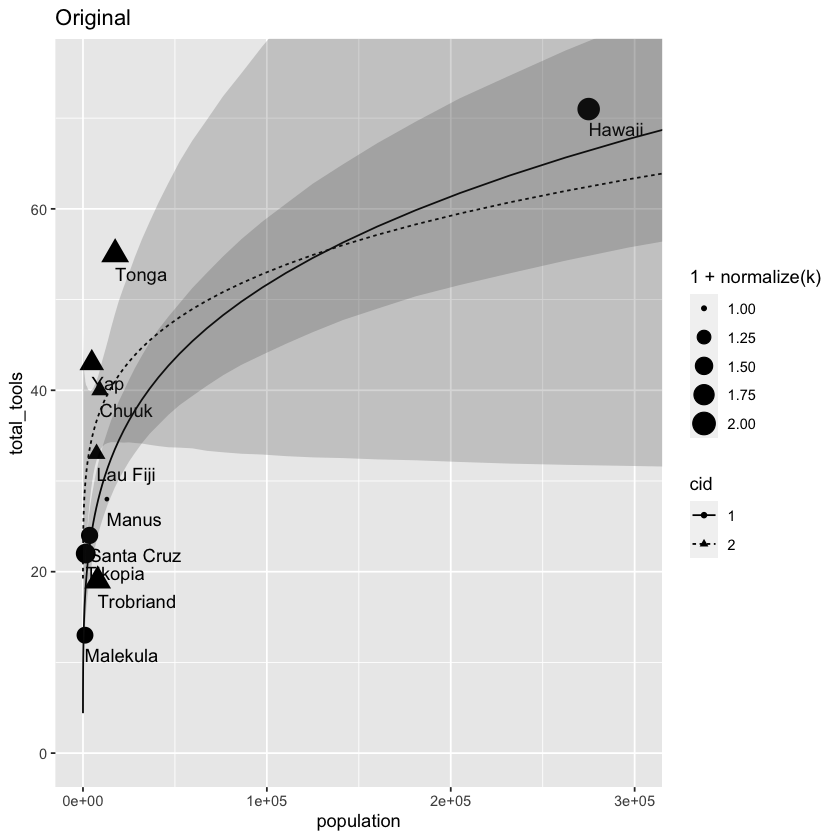

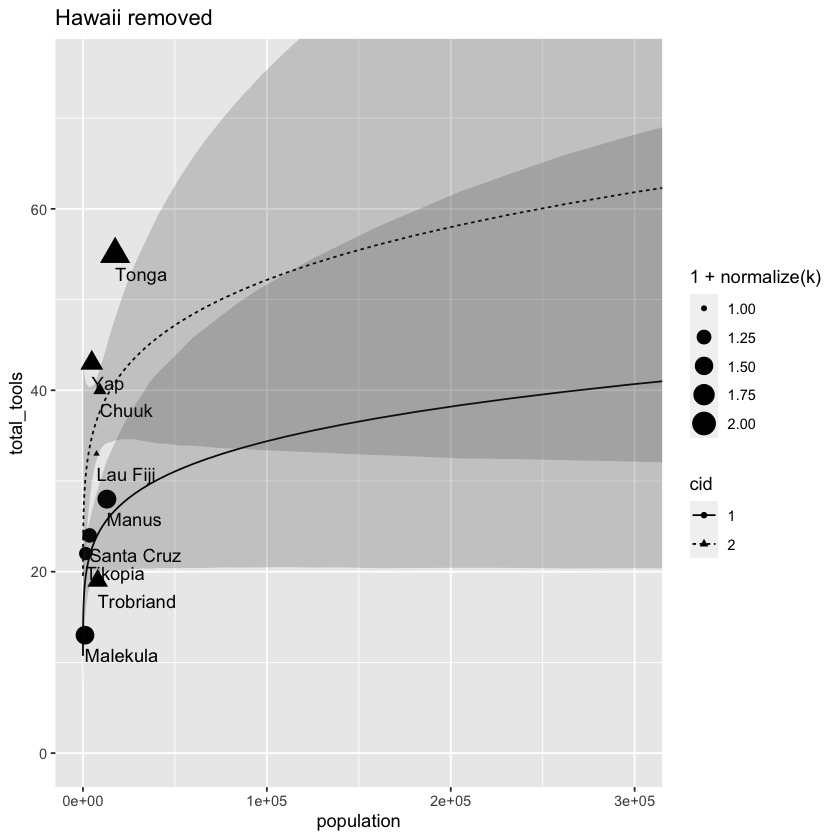

In [86]:
####### ORIGINAL

# setting up the predictions
k <- PSIS(m11.10_original, pointwise = TRUE)$k
ns <- 100
P_seq <- seq(from = -5, to = 3, length.out = ns)
pop_seq <- exp(P_seq * 1.53 + 9) # 1.53 is the sd of log (population); 9 is the mean

#low contact (cid = 1) predictions
lambda <- link(m11.10_original, data = data.frame(P = P_seq, cid = 1))
lmu <- apply(lambda, 2, mean)
lci <- apply(lambda, 2, PI)
low_contact_df <- data.frame(
    P = P_seq,
    mu = lmu,
    lower = lci[1, ],
    upper = lci[2, ],
    cid = 1
)

# high contact (cid = 2) predictions
lambda <- link(m11.10_original, data = data.frame(P = P_seq, cid = 2))
lmu <- apply(lambda, 2, mean)
lci <- apply(lambda, 2, PI)
high_contact_df <- data.frame(
    P = P_seq,
    mu = lmu,
    lower = lci[1, ],
    upper = lci[2, ],
    cid = 2
)

predictions <- rbind(low_contact_df, high_contact_df)
predictions$cid <- factor(predictions$cid)
predictions$population <- pop_seq

plot_df <- data.frame(population = d$population, total_tools = d$total_tools, cid = factor(dat$cid), k = k, culture = d$culture)
ribbon_df <- data.frame(population = pop_seq, lower = predictions$lower, upper = predictions$upper, cid = factor(predictions$cid))
p <- ggplot() +
    geom_point(data = plot_df, mapping = aes(x = population, y = total_tools, shape = cid, size = 1 + normalize(k))) +
    geom_text(data = plot_df, mapping = aes(x = population, y = total_tools, label = culture), hjust = 0, vjust = 2) +
    geom_line(data = predictions, mapping = aes(population, mu, linetype = cid)) +
    geom_ribbon(data = ribbon_df, mapping = aes(x = population, ymin = lower, ymax = upper, group = cid), alpha = 0.2) + 
    coord_cartesian(xlim = c(0, 300000), ylim = c(0, 75)) +
    labs(title = "Original")
print(p)

#########
# With Hawaii removed

# setting up the predictions
k <- PSIS(m11.10_removed, pointwise = TRUE)$k
ns <- 100
P_seq <- seq(from = -5, to = 3, length.out = ns)
pop_seq <- exp(P_seq * 1.53 + 9) # 1.53 is the sd of log (population); 9 is the mean

#low contact (cid = 1) predictions
lambda <- link(m11.10_removed, data = data.frame(P = P_seq, cid = 1))
lmu <- apply(lambda, 2, mean)
lci <- apply(lambda, 2, PI)
low_contact_df <- data.frame(
    P = P_seq,
    mu = lmu,
    lower = lci[1, ],
    upper = lci[2, ],
    cid = 1
)

# high contact (cid = 2) predictions
lambda <- link(m11.10_removed, data = data.frame(P = P_seq, cid = 2))
lmu <- apply(lambda, 2, mean)
lci <- apply(lambda, 2, PI)
high_contact_df <- data.frame(
    P = P_seq,
    mu = lmu,
    lower = lci[1, ],
    upper = lci[2, ],
    cid = 2
)

predictions <- rbind(low_contact_df, high_contact_df)
predictions$cid <- factor(predictions$cid)
predictions$population <- pop_seq

plot_df <- data.frame(population = d_removed$population, total_tools = d_removed$total_tools, cid = factor(dat_removed$cid), k = k, culture = d_removed$culture)
ribbon_df <- data.frame(population = pop_seq, lower = predictions$lower, upper = predictions$upper, cid = factor(predictions$cid))
p <- ggplot() +
    geom_point(data = plot_df, mapping = aes(x = population, y = total_tools, shape = cid, size = 1 + normalize(k))) +
    geom_text(data = plot_df, mapping = aes(x = population, y = total_tools, label = culture), hjust = 0, vjust = 2) +
    geom_line(data = predictions, mapping = aes(population, mu, linetype = cid)) +
    geom_ribbon(data = ribbon_df, mapping = aes(x = population, ymin = lower, ymax = upper, group = cid), alpha = 0.2) + 
    coord_cartesian(xlim = c(0, 300000), ylim = c(0, 75)) +
    labs(title = "Hawaii removed")
print(p)

Hawaii is obviously a very influential point. With it removed, the predictions for all contact types (high and low) are lower than they otherwise would be. In addition, the unexpected behaviour where the high-contact line dips below the low-contact line no longer happens; now the high-contact line is consistently above the low-contact one, as we expect.

### 11H1 Use WAIC or PSIS to compare the chimpanzee model that includes a unique intercept for each actor, m11.4, to the simpler models fit in the same section. Interpret the results.

In [87]:
data(chimpanzees)
d <- chimpanzees
d$treatment <- 1 + d$prosoc_left + 2 * d$condition

# actually the revised version
m11.1 <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm(0, 1.5)
    ),
    data = d
)

m11.2 <- quap(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a + b[treatment],
        a ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 10)
    ),
    data = d
)

m11.3 <- quap(
    alist(
        pulled_left <- dbinom(1, p),
        logit(p) <- a + b[treatment],
        a ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = d
)

# trimmed data list
dat_list <- list(
    pulled_left = d$pulled_left,
    actor = d$actor,
    treatment = as.integer(d$treatment)
)

m11.4 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + b[treatment],
        a[actor] ~ dnorm(0, 1.5),
        b[treatment] ~ dnorm(0, 0.5)
    ),
    data = dat_list,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.4 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

In [88]:
comparison <- compare(m11.1, m11.2, m11.3, m11.4)
comparison

Warning message in compare(m11.1, m11.2, m11.3, m11.4):
“Not all model fits of same class.
This is usually a bad idea, because it implies they were fit by different algorithms.
Check yourself, before you wreck yourself.”


WAIC     SE        dWAIC    dSE      pWAIC     weight      
m11.4 532.1620 18.962754   0.0000       NA 8.5660325 1.000000e+00
m11.3 682.4367  9.045846 150.2748 18.40466 3.6044256 2.334814e-33
m11.2 683.0660  9.654009 150.9040 18.48263 4.0061776 1.704546e-33
m11.1 687.9404  7.176299 155.7785 18.98764 0.9998617 1.489826e-34

Looking at these, the model with the actor-specific intercept is clearly better (about 6-7 SE above the next one). All of the rest are basically in the same ballpark, but again are significantly lower than the actor-specific model.

In [89]:
comparison_df <- as.data.frame(comparison)
comparison_df <- cbind(model = rownames(comparison_df), comparison_df)
rownames(comparison_df) <- 1:nrow(comparison_df)
comparison_df

model WAIC     SE        dWAIC    dSE      pWAIC     weight      
1 m11.4 532.1620 18.962754   0.0000       NA 8.5660325 1.000000e+00
2 m11.3 682.4367  9.045846 150.2748 18.40466 3.6044256 2.334814e-33
3 m11.2 683.0660  9.654009 150.9040 18.48263 4.0061776 1.704546e-33
4 m11.1 687.9404  7.176299 155.7785 18.98764 0.9998617 1.489826e-34

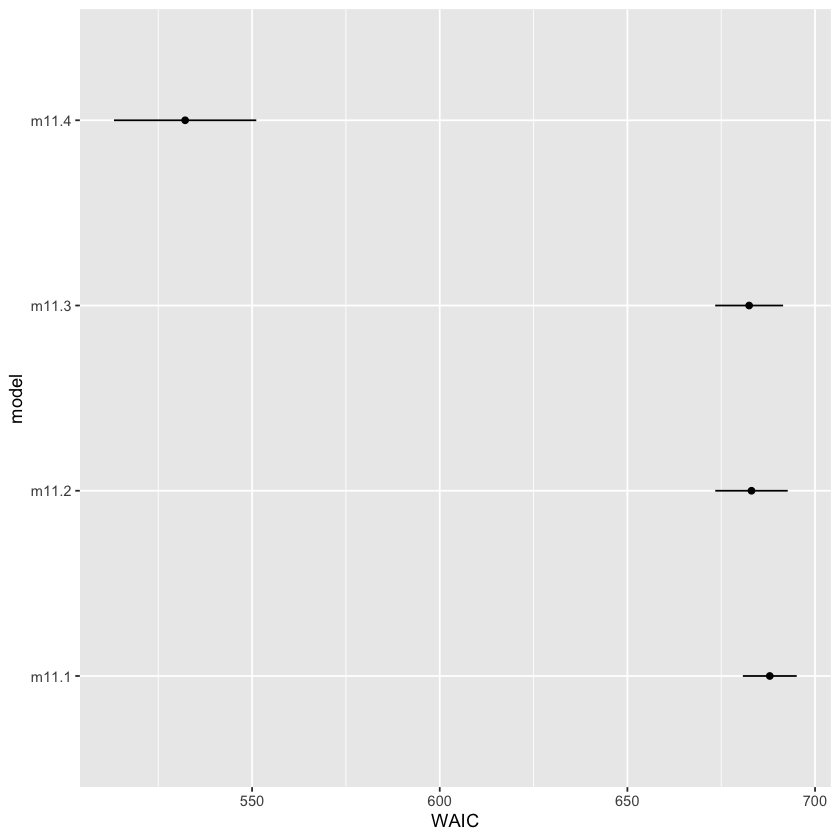

In [90]:
ggplot(data.frame(
    model = comparison_df$model,
    WAIC = comparison_df$WAIC,
    lower = comparison_df$WAIC - comparison_df$SE,
    upper = comparison_df$WAIC + comparison_df$SE
), aes(WAIC, model)) +
    geom_point() +
    geom_linerange(aes(xmin = lower, xmax = upper))

Looking at the plot makes it even more clear - m11.4 is clearly much better than the other ones.

### 11H2 The data contained in `library(MASS); data(eagles)` are records of slamon pirating attempts by Bald Eagles in Washington State. See `?eagles` for more information. WHile one eagle feeds, sometimes another will swoop in and try to steal the salmon from it. Call the feeding eagle the "victim" and the thief the "pirate". Use the available data to build a binomial GLM of successful pirating attempts.
#### a) Consider the following model:
$$
\begin{align*}
y_i &\sim \text{Binomial}(n_i, p_i) \\
\text{logit}(p_i) &= \alpha + \beta_P P_i + \beta_V V_i + \beta_A A_i \\
\alpha &\sim \text{Normal}(0, 1.5) \\
\beta_P, \beta_V, \beta_A &\sim \text{Normal}(0, 0.5)
\end{align*}
$$
### where $y$ is the number of successful attempts, $n$ is the total number of attempts, $P$ is a dunmmy variable indicating whether or not the pirate had large body size, $V$ is a dummy variable indicating whether or not the victim had a large body size, and $A$ is a dummy variable for whether the pirate was an adult. Fit the model above to the `eagles` data, using both `quap` and `ulam`. Is the quadratic approximation OK?

In [91]:
library(MASS)
data(eagles)
d <- eagles
head(d)

y  n  P A V
1 17 24 L A L
2 29 29 L A S
3 17 27 L I L
4 20 20 L I S
5  1 12 S A L
6 15 16 S A S

In [92]:
# modify the columns to be 0 or 1
d$P_actual <- ifelse(d$P == "L", 1, 0)
d$A_actual <- ifelse(d$A == "A", 1, 0)
d$V_actual <- ifelse(d$V == "L", 1, 0)

In [93]:
eagles_model_quap <- quap(
    alist(
        y ~ dbinom(n, p),
        logit(p) <- a + b_p * P_actual + b_v * V_actual * b_a * A_actual,
        a ~ dnorm(0, 1.5),
        c(b_p, b_v, b_a) ~ dnorm(0, 0.5)
    ),
    data = d
)

In [94]:
eagles_data <- list(
    y = d$y,
    n = d$n,
    P_actual = d$P_actual,
    V_actual = d$V_actual,
    A_actual = d$A_actual
)
eagles_model_ulam <- ulam(
    alist(
        y ~ dbinom(n, p),
        logit(p) <- a + b_p * P_actual + b_v * V_actual * b_a * A_actual,
        a ~ dnorm(0, 1.5),
        c(b_p, b_v, b_a) ~ dnorm(0, 0.5)
    ),
    data = eagles_data,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

In [95]:
precis(eagles_model_quap)

mean       sd        5.5%       94.5%    
a   -0.3910487 0.2499844 -0.7905721 0.0084747
b_p  1.6208560 0.2882221  1.1602214 2.0814907
b_v  0.4414322 0.5363755 -0.4157994 1.2986638
b_a -0.4414347 0.5363762 -1.2986674 0.4157980

In [96]:
precis(eagles_model_ulam)

mean         sd        5.5%       94.5%       rhat     ess_bulk 
a   -0.385271355 0.2364014 -0.7550741 -0.01733659 1.001085  973.5718
b_a  0.009930345 0.5783893 -0.8884777  0.92075510 1.003419  785.5355
b_v -0.012529652 0.5924564 -0.9644759  0.87919503 1.002272  808.4992
b_p  1.631829008 0.2884735  1.1797627  2.08443205 1.004493 1007.7628

In [97]:
quap_df <- as.data.frame(precis(eagles_model_quap))
quap_df <- cbind(variable = rownames(quap_df), quap_df)
rownames(quap_df) <- 1:nrow(quap_df)
quap_df$model <- "Quap"
ulam_df <- as.data.frame(precis(eagles_model_ulam))
ulam_df <- cbind(variable = rownames(ulam_df), ulam_df)
rownames(ulam_df) <- 1:nrow(ulam_df)
ulam_df$model <- "Ulam"
quap_df
ulam_df

variable mean       sd        5.5%       94.5%     model
1 a        -0.3910487 0.2499844 -0.7905721 0.0084747 Quap 
2 b_p       1.6208560 0.2882221  1.1602214 2.0814907 Quap 
3 b_v       0.4414322 0.5363755 -0.4157994 1.2986638 Quap 
4 b_a      -0.4414347 0.5363762 -1.2986674 0.4157980 Quap

variable mean         sd        5.5%       94.5%       rhat     ess_bulk 
1 a        -0.385271355 0.2364014 -0.7550741 -0.01733659 1.001085  973.5718
2 b_a       0.009930345 0.5783893 -0.8884777  0.92075510 1.003419  785.5355
3 b_v      -0.012529652 0.5924564 -0.9644759  0.87919503 1.002272  808.4992
4 b_p       1.631829008 0.2884735  1.1797627  2.08443205 1.004493 1007.7628
  model
1 Ulam 
2 Ulam 
3 Ulam 
4 Ulam

In [98]:
combined_df <- rbind(data.frame(
    variable = quap_df$variable,
    model = quap_df$model,
    mean = quap_df$mean,
    sd = quap_df$sd
), data.frame(
    variable = ulam_df$variable,
    model = ulam_df$model,
    mean = ulam_df$mean,
    sd = ulam_df$sd
))
combined_df$lower <- combined_df$mean - combined_df$sd
combined_df$upper <- combined_df$mean + combined_df$sd
combined_df

variable model mean         sd        lower      upper      
1 a        Quap  -0.391048699 0.2499844 -0.6410331 -0.14106427
2 b_p      Quap   1.620856033 0.2882221  1.3326339  1.90907817
3 b_v      Quap   0.441432184 0.5363755 -0.0949433  0.97780766
4 b_a      Quap  -0.441434735 0.5363762 -0.9778109  0.09494142
5 a        Ulam  -0.385271355 0.2364014 -0.6216728 -0.14886991
6 b_a      Ulam   0.009930345 0.5783893 -0.5684590  0.58831964
7 b_v      Ulam  -0.012529652 0.5924564 -0.6049860  0.57992674
8 b_p      Ulam   1.631829008 0.2884735  1.3433555  1.92030255

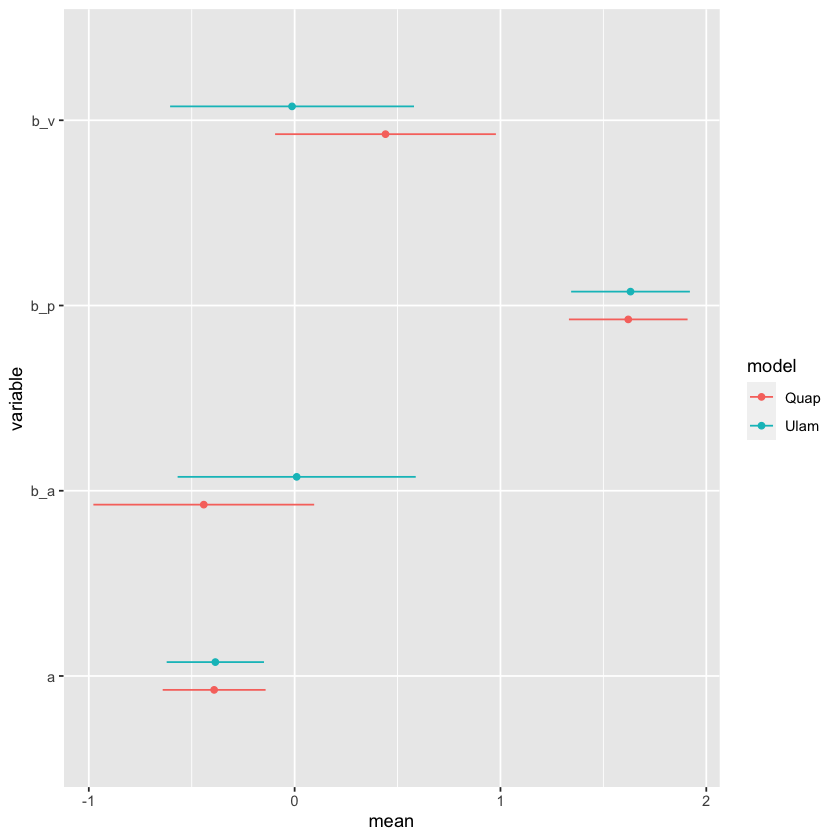

In [99]:
ggplot(combined_df, aes(mean, variable, group = interaction(variable, model), colour = model)) +
    geom_point(position=ggstance::position_dodgev(height=0.3)) +
    geom_linerange(aes(xmin = lower, xmax = upper), position=ggstance::position_dodgev(height=0.3))

From this, it seems clear that the quadratic approximation is poor for $\beta_A$ and $\beta_V$, but good for $\beta_P$ and $\alpha$.

#### b) Now interpret the estimates. If the quadratic approximation turned out okay, then it's okay to use the `quap` estimates. Otherwise stick to `ulam` estimates. The plot the posterior predictions. Compute and display both (1) the predicted **probability** of success and its 89% interval for each row ($i$) in the data, as well as (2) the predicted success **count** and its 89% interval. What different information does each type of posterior prediction provide?

In [100]:
samples <- extract.samples(eagles_model_ulam)
lapply(samples, head)

$a
          [,1]
[1,] -0.818957
[2,] -0.753176
[3,] -0.597761
[4,] -0.325199
[5,] -0.437738
[6,] -0.332195

$b_a
           [,1]
[1,]  0.9494830
[2,]  0.8638590
[3,]  0.3309760
[4,] -0.0180856
[5,] -0.3443510
[6,] -0.3799370

$b_v
             [,1]
[1,]  0.139395000
[2,] -0.000150099
[3,] -0.327047000
[4,]  0.307270000
[5,]  0.132654000
[6,]  0.261492000

$b_p
        [,1]
[1,] 1.74057
[2,] 1.73009
[3,] 1.88860
[4,] 1.33775
[5,] 1.77496
[6,] 1.62158

$p
         [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
[1,] 0.741536 0.715370 0.715370 0.715370 0.334789 0.305985 0.305985 0.305985
[2,] 0.726470 0.726495 0.726495 0.726495 0.320102 0.320130 0.320130 0.320130
[3,] 0.765414 0.784289 0.784289 0.784289 0.330482 0.354856 0.354856 0.354856
[4,] 0.732432 0.733519 0.733519 0.733519 0.418057 0.419409 0.419409 0.419409
[5,] 0.784407 0.792032 0.792032 0.792032 0.381445 0.392280 0.392280 0.392280
[6,] 0.766747 0.784043 0.784043 0.784043 0.393757 0.417707 0.417707 0.417707

In [101]:
df <- data.frame(
    P = numeric(),
    V = numeric(),
    A = numeric(),
    logit_p = numeric()
)
for (P in c(0, 1)) {
    for (V in c(0, 1)) {
        for (A in c(0, 1)) {
            for (i in 1:length(samples[['a']])) {
                df <- rbind(
                    df,
                    data.frame(
                        P = P,
                        V = V,
                        A = A,
                        logit_p = samples[['a']][i] + samples[['b_p']][i] * P + samples[['b_v']][i] * V + samples[['b_a']][i] * A
                    )
                )
            }
        }
    }
}
df$p <- inv_logit(df$logit_p)

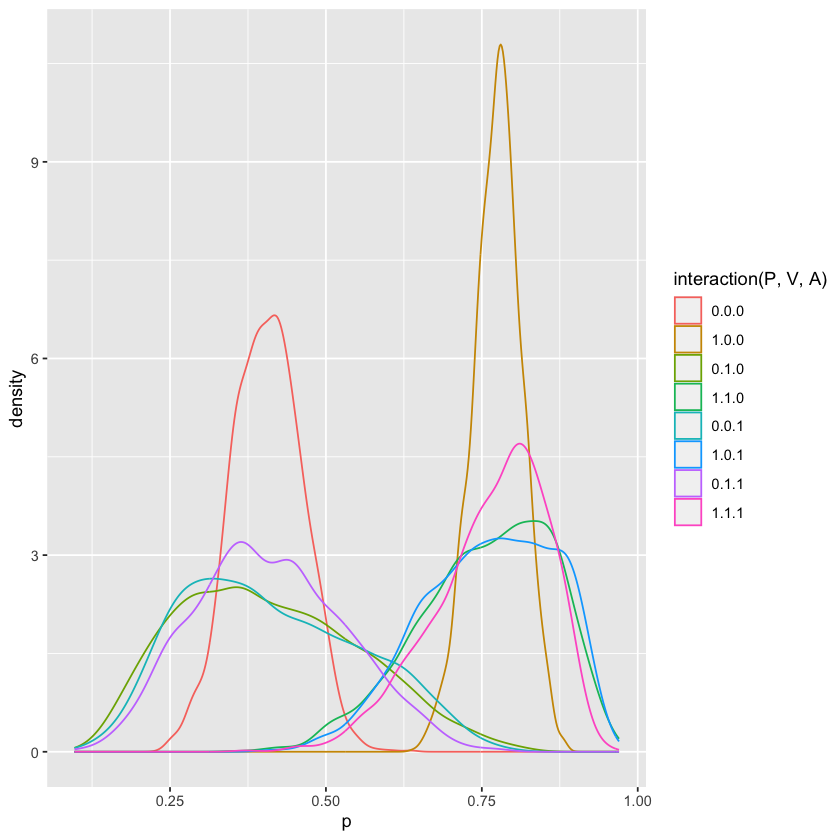

In [102]:
ggplot(df, aes(p, group = interaction(P, V, A), colour = interaction(P, V, A))) +
    geom_density(aes(y = after_stat(density)))

Now for the counts!

In [103]:
# CALCULATION FOR N IS NOT CORRECT - ALWAYS RETURNING 24
df$count <- rep(NA, nrow(df))
df$n <- rep(NA, nrow(df))
for (i in 1:(nrow(df))) {
    row <- df[i, ]
    P <- row[, 'P'][1]
    V <- row[, 'V'][1]
    A <- row[, 'A'][1]
    matching <- d[d$P_actual == P & d$V_actual == V & d$A_actual == A, ]
    n <- matching[, 'n'][1]
    p <- df[i, 'p']
    df[i, 'n'] <- n
    df[i, 'count'] <- rbinom(1, n, p)
}

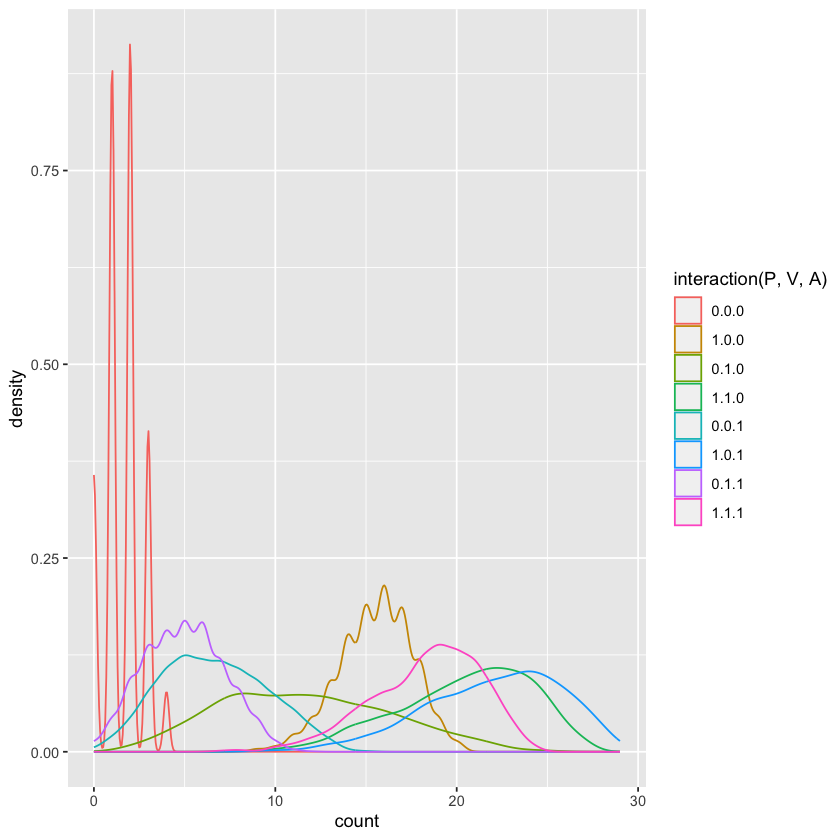

In [104]:
ggplot(df, aes(count, group = interaction(P, V, A), colour = interaction(P, V, A))) +
    geom_density(aes(y = after_stat(density)))

This does provide slightly different information. While generally the same patterns hold, there are differences due to the varying number of attempts made by the different categories.

#### c) Now try to improve the model. Consider an interaction between the pirate's size and age. Compare this model to the previous one using WAIC. Interpret the results.

In [105]:
d$I_actual <- d$P_actual * d$A_actual

eagles_data <- list(
    y = d$y,
    n = d$n,
    P_actual = d$P_actual,
    V_actual = d$V_actual,
    A_actual = d$A_actual,
    I_actual = d$I_actual
)

eagles_model_ulam_interaction <- ulam(
    alist(
        y ~ dbinom(n, p),
        logit(p) <- a + b_p * P_actual + b_v * V_actual * b_a * A_actual + b_i * I_actual,
        a ~ dnorm(0, 1.5),
        c(b_p, b_v, b_a, b_i) ~ dnorm(0, 0.5)
    ),
    data = eagles_data,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

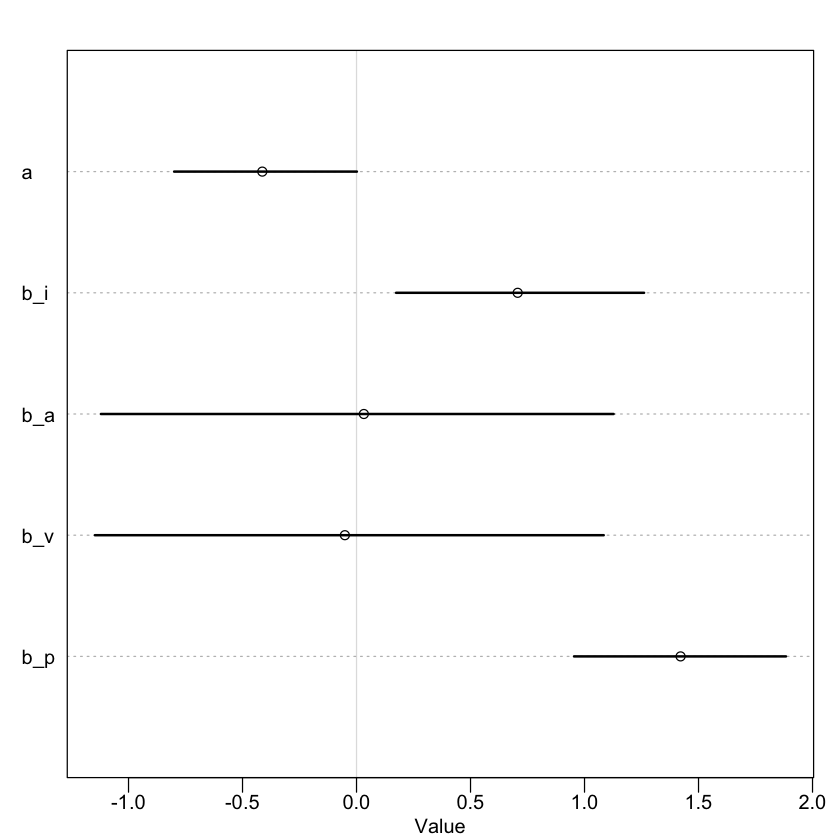

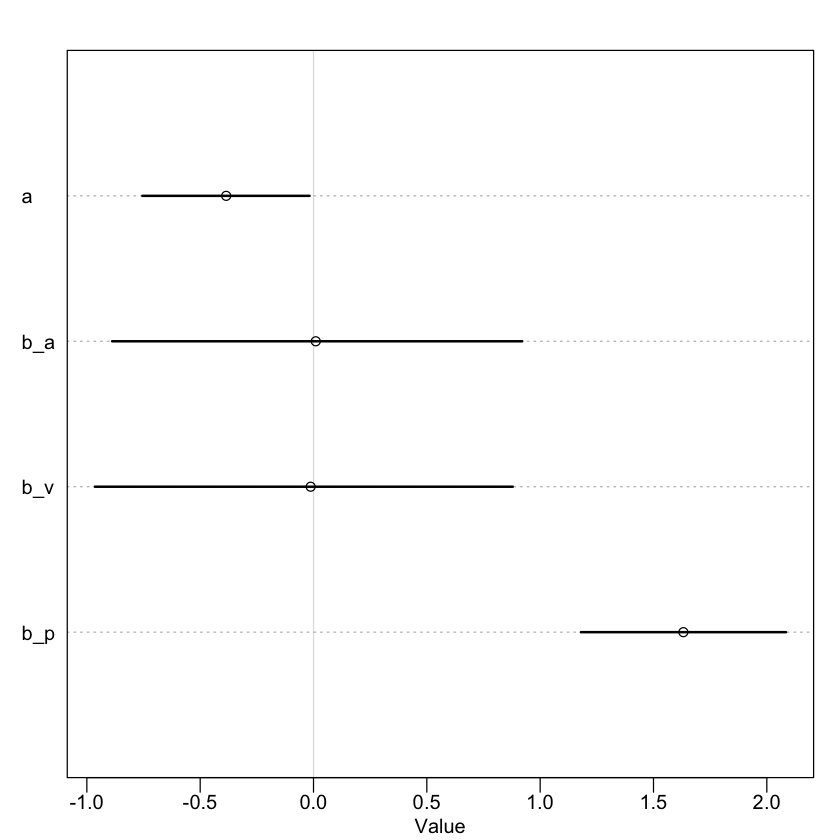

In [106]:
par(bg = 'white')
plot(precis(eagles_model_ulam_interaction))
plot(precis(eagles_model_ulam))

In [107]:
compare(eagles_model_ulam_interaction, eagles_model_ulam, func = WAIC)

WAIC     SE       dWAIC     dSE     pWAIC   
eagles_model_ulam_interaction 116.7276 34.34376 0.0000000      NA 18.89529
eagles_model_ulam             117.2659 33.24724 0.5383333 6.88195 16.52250
                              weight   
eagles_model_ulam_interaction 0.5668883
eagles_model_ulam             0.4331117

So here the interaction coefficient $b_I$ seems to have an effect that we care about, but looking at the models they are virtually indisinguishable. This is not surprising; since the age and size variables are binary, their 'interaction' basically just tests if the pirate is larger *and* older, and since the effect of being larger ($P$) is already so large, this information is essentially just encoded there.

### 11H3 The data contained in `data(salamanders)` are counts of salamanders (*Plethodon elongatus*) from 47 different 59m$^2$ plots in northern California. The column `SALAMAN` is the count in each plot, and the columns `PCTCOVER` and `FORESTAGE` are percent of ground cover and age of trees in the plot, respectively. You will model `SALAMA` as a Poisson variable.
#### a) Model the relationship between density and percent cover, using a log link (same as the examples in the book and lexture). Use weakly informative proiors of your choosing. Checl the quadratic approximation again, by comparing `quap` to `ulam`. Then plot the expected counts and their 89% intervals against percent cover. In what ways does the model do a good job? A bad job?

In [108]:
data(salamanders)
d <- salamanders
head(d)

SITE SALAMAN PCTCOVER FORESTAGE
1 1    13      85       316      
2 2    11      86        88      
3 3    11      90       548      
4 4     9      88        64      
5 5     8      89        43      
6 6     7      83       368

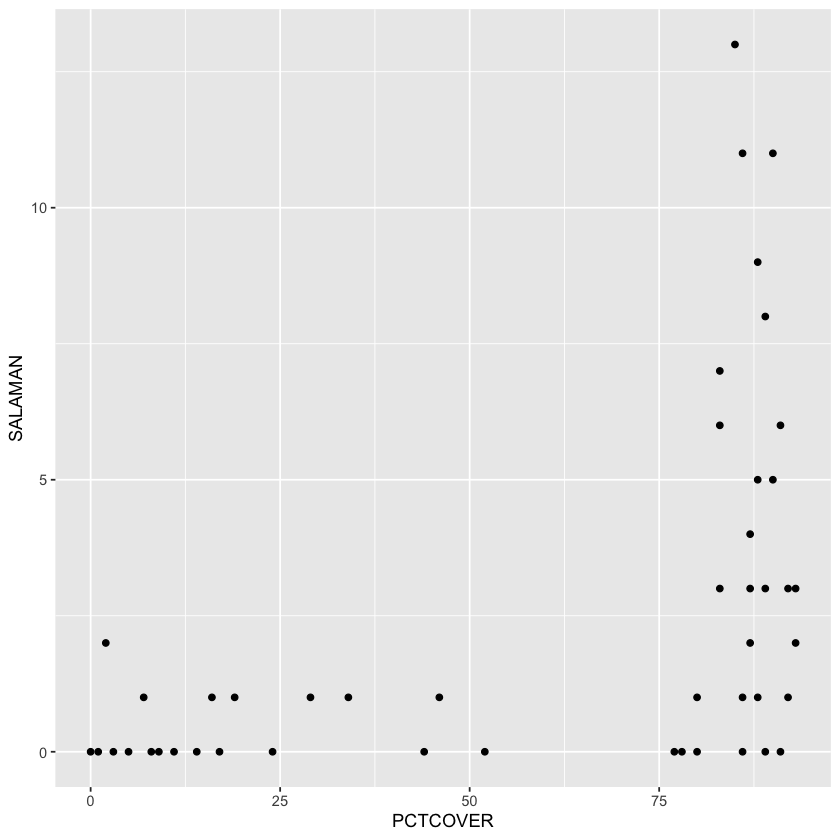

In [109]:
# first let's get an idea for the relationship here
ggplot(d, aes(PCTCOVER, SALAMAN)) +
    geom_point()

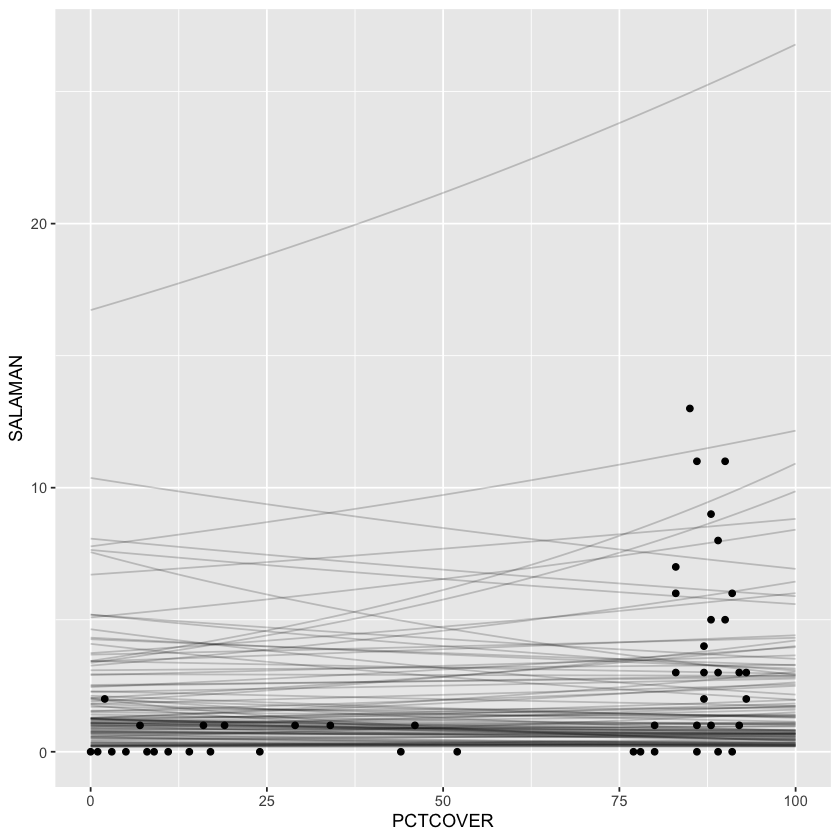

In [121]:
# coming up with some priors
# model is 
# a ~ dpois(lambda)
# lambda <- a + b_p * P
# a ~ dnorm(???)
# b_p ~ dnorm(???)
# NB I got these priors mostly by just random guessing and fiddling about until things looked reasonable

N <- 100
a <- rnorm(N, 0, 1)
b_P <- rnorm(N, 0, 0.005)
P <- seq(0, 100, by = 1)
plot_df <- data.frame(P = numeric(), lambda = numeric(), i = numeric())
for (i in 1:N) {
    lambda <- exp(a[i] + b_P[i] * P)
    plot_df <- rbind(
        plot_df,
        data.frame(
            P = P,
            lambda = lambda,
            i = i
        )
    )
}

ggplot(d, aes(PCTCOVER, SALAMAN)) +
    geom_point() +
    geom_line(data = plot_df, aes(P, lambda, group = i), alpha = 0.2)

In [161]:
salamander_model <- alist(
    s ~ dpois(lambda),
    log(lambda) <- a + b_P * P,
    a ~ dnorm(0, 1),
    b_P ~ dnorm(0, 0.005)
)

data <- list(
    s = d$SALAMAN,
    P = d$PCTCOVER
)

salamander_model_quap <- quap(salamander_model, data = data)
salamander_model_ulam <- ulam(salamander_model, data = data, chains = 4, log_lik = TRUE)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.2 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

See https://mc-stan.org/misc/warnings for details.


See https://mc-stan.org/misc/warnings for details.




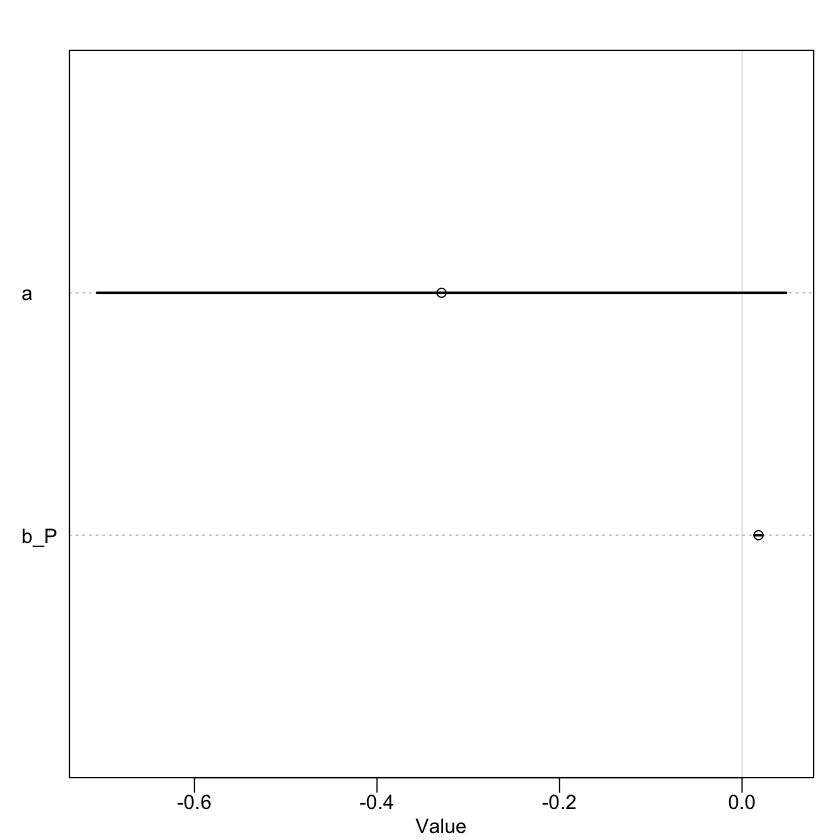

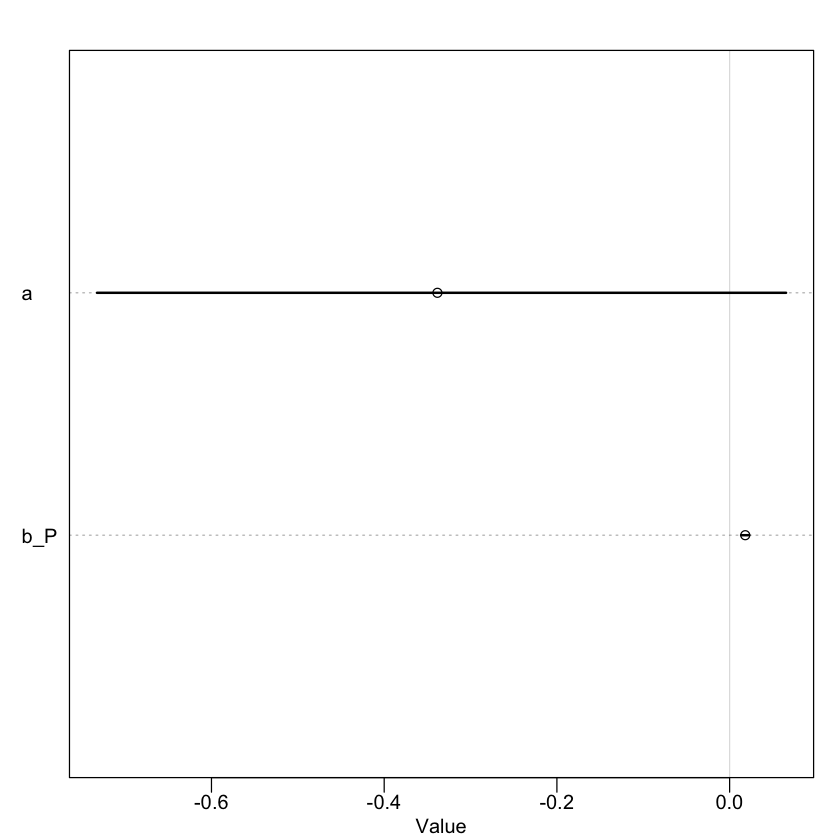

In [144]:
par(bg = 'white')
plot(precis(salamander_model_quap))
plot(precis(salamander_model_ulam))

In [145]:
salamander_quap_samples <- extract.samples(salamander_model_quap)
salamander_ulam_samples <- extract.samples(salamander_model_ulam)

In [146]:
alpha <- 0.11
a_quap <- salamander_quap_samples[['a']]
a_quap_mean <- mean(a_quap)
a_quap_bounds <- quantile(a_quap, c(alpha / 2, 1 - alpha / 2))
a_ulam <- salamander_ulam_samples[['a']]
a_ulam_mean <- mean(a_ulam)
a_ulam_bounds <- quantile(a_ulam, c(alpha / 2, 1 - alpha / 2))

b_P_quap <- salamander_quap_samples[['b_P']]
b_P_ulam <- salamander_ulam_samples[['b_P']]
b_P_quap_mean <- mean(b_P_quap)
b_P_quap_bounds <- quantile(b_P_quap, c(alpha / 2, 1 - alpha / 2))
b_P_ulam_mean <- mean(b_P_ulam)
b_P_ulam_bounds <- quantile(b_P_ulam, c(alpha / 2, 1 - alpha / 2))

# NB This is a dumb way to do it - probably the better way would be to take the standard error and calculate the range from that
# or basically any other way
comparison_df <- data.frame(
    variable = rep(c("a", "b_P"), each = 2),
    model = rep(c("Quap", "Ulam"), 2),
    mean = c(a_quap_mean, a_ulam_mean, b_P_quap_mean, b_P_ulam_mean),
    lower = c(a_quap_bounds[1], a_ulam_bounds[1], b_P_quap_bounds[1], b_P_ulam_bounds[2]),
    upper = c(a_quap_bounds[2], a_ulam_bounds[2], b_P_quap_bounds[1], b_P_ulam_bounds[2])
)
comparison_df

variable model mean        lower       upper     
1 a        Quap  -0.33014052 -0.70826802 0.04500622
2 a        Ulam  -0.33835711 -0.73250382 0.06532837
3 b_P      Quap   0.01802804  0.01343521 0.01343521
4 b_P      Ulam   0.01809455  0.02275861 0.02275861

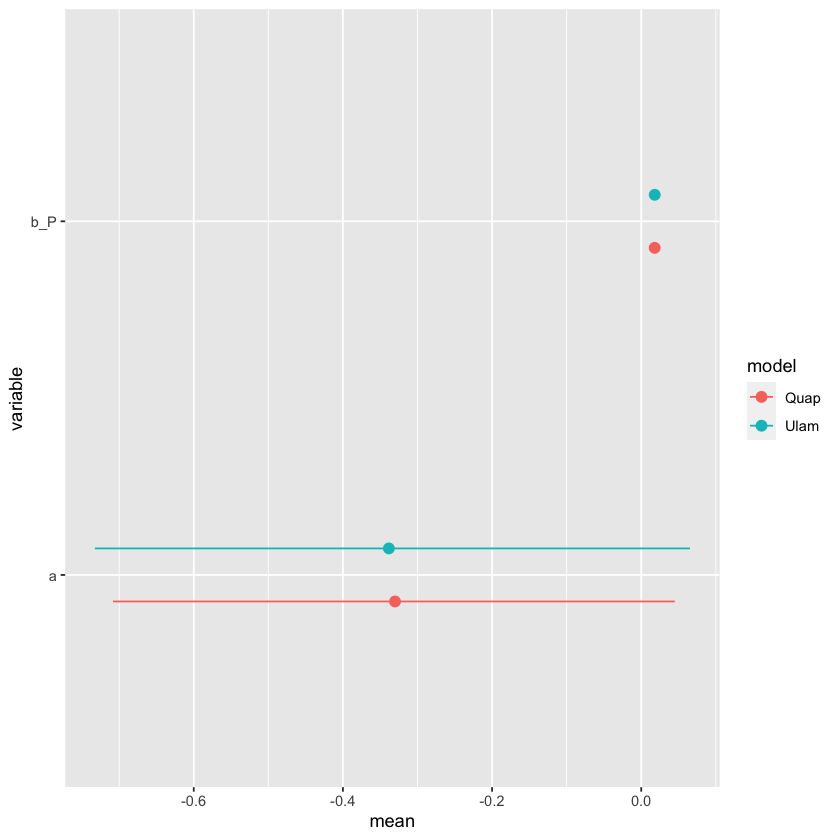

In [147]:
ggplot(comparison_df, aes(group = interaction(variable, model), colour = model)) +
    geom_pointrange(aes(x = mean, y = variable, xmin = lower, xmax = upper), position = ggstance::position_dodgev(height = 0.3))

Basically these models give the same results - not a huge difference between them.

Now let's take a look at the posterior predictions!

In [148]:
cover_percent <- seq(0, 100, length.out = 100)
prediction_data <- data.frame(P = cover_percent)
# why is this getting lambda? What is the link function doing here? How does it know to get this instead of s, log(p), &c.?
lambda <- link(salamander_model_ulam, data = prediction_data)

In [149]:
lambda_mean <- apply(lambda, 2, mean)
lambda_bounds <- apply(lambda, 2, function(x) PI(x, 1 - alpha))
plot_df <- data.frame(P = cover_percent, mean = lambda_mean, lower = lambda_bounds[1, ], upper = lambda_bounds[2, ])

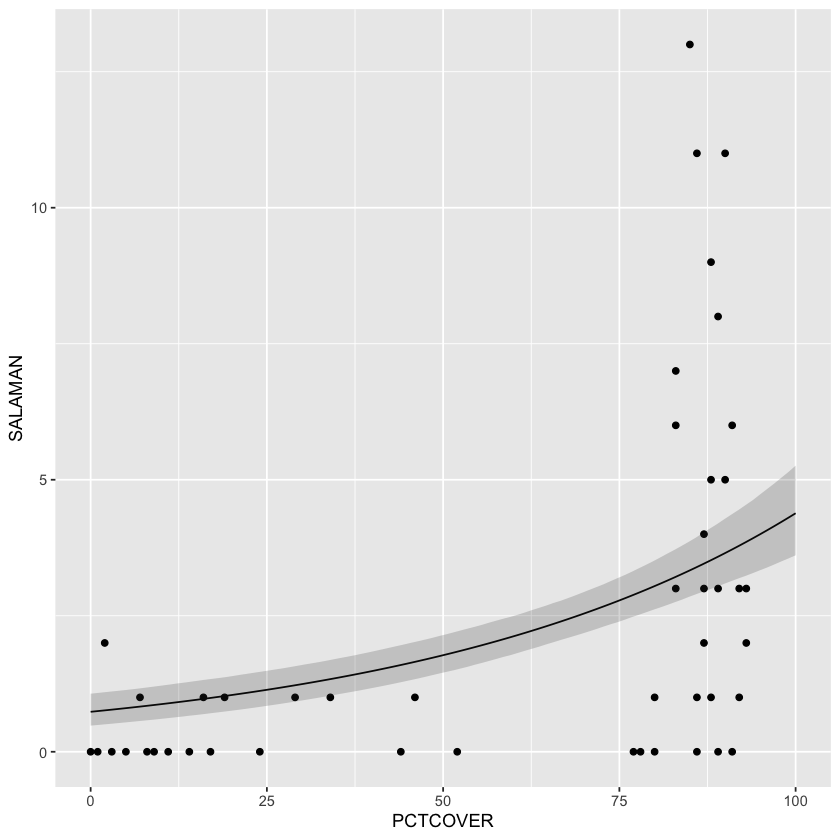

In [150]:
ggplot() +
    geom_point(data = d, aes(PCTCOVER, SALAMAN)) +
    geom_line(data = plot_df, mapping = aes(x = P, y = mean)) +
    geom_ribbon(data = plot_df, mapping = aes(x = P, ymin = lower, ymax = upper), alpha = 0.2)

This model is clearly doing a pretty poor job of fitting to the data. It's slightly better at the lower end, although it consistently predicts too high. However, it has real trouble at the 75% - 100% forest cover range, where the variation is enormous. It seems pretty clear that we are missing some important piece of data here.

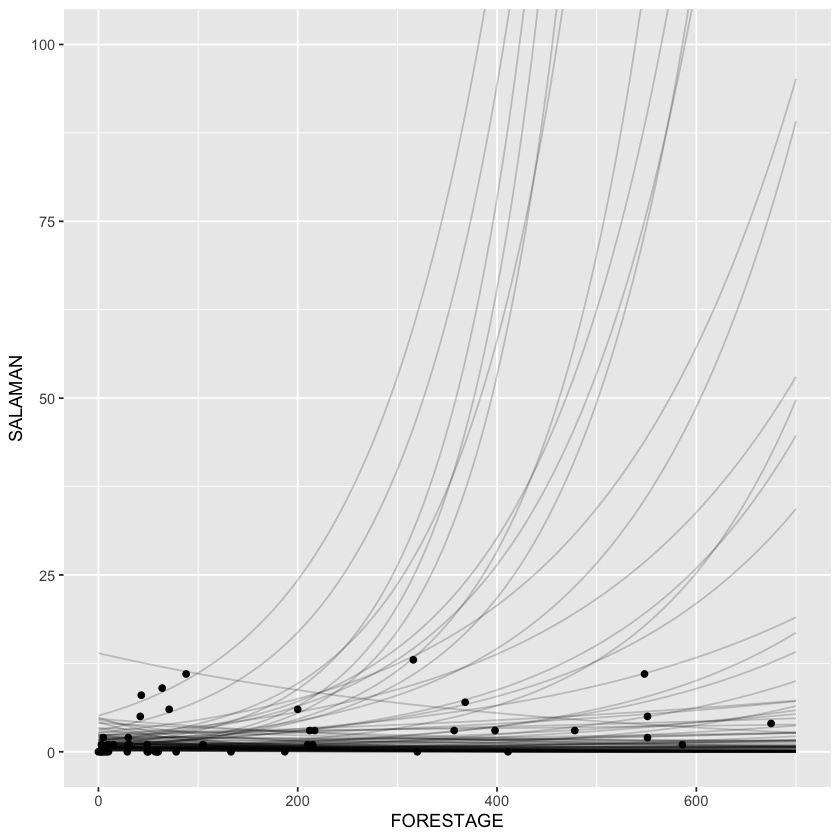

In [155]:
# getting the priors
N <- 100
a <- rnorm(N, 0, 1)
b_A <- rnorm(N, 0, 0.005)
A <- seq(0, 700, by = 1)
plot_df <- data.frame(A = numeric(), lambda = numeric(), i = numeric())
for (i in 1:N) {
    lambda <- exp(a[i] + b_A[i] * A)
    plot_df <- rbind(
        plot_df,
        data.frame(
            A = A,
            lambda = lambda,
            i = i
        )
    )
}

ggplot(d, aes(FORESTAGE, SALAMAN)) +
    geom_point() +
    geom_line(data = plot_df, aes(A, lambda, group = i), alpha = 0.2) +
    coord_cartesian(ylim = c(0, 100))

In [169]:
new_salamander_model <- alist(
    s ~ dpois(lambda),
    log(lambda) <- a + b_P * P + b_A * A,
    a ~ dnorm(0, 1),
    b_P ~ dnorm(0, 0.005),
    b_A ~ dnorm(0, 0.005)
)

data <- list(
    s = d$SALAMAN,
    P = d$PCTCOVER,
    A = d$FORESTAGE
)

forest_age_salamander_model <- ulam(new_salamander_model, data = data, chains = 4, log_lik = TRUE)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.


Chain 2 Rejecting initial value:

Chain 2   Log probability evaluates to log(0), i.e. negative infinity.

Chain 2   Stan can't start sampling from this initial value.



Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.1 seconds.


Chain 3 Rejecting initial value:

Chain 3   Log probability evaluates to log(0), i.e. negative infinity.

Chain 3   Stan can't start sampling from this initial value.



Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 0.2 seconds.


Chain 4 Rejecting initial value:

Chain 4   Log probability evaluates to log(0), i.e. negative infinity.

Chain 4   Stan can't start sampling from this initial value.

Chain 4 Rejecting initial value:

Chain 4   Log probability evaluates to log(0), i.e. negative infinity.

Chain 4   Stan can't start sampling from this initial value.



Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.1 seconds.
Total execution time: 0.7 seconds.



See https://mc-stan.org/misc/warnings for details.


See https://mc-stan.org/misc/warnings for details.




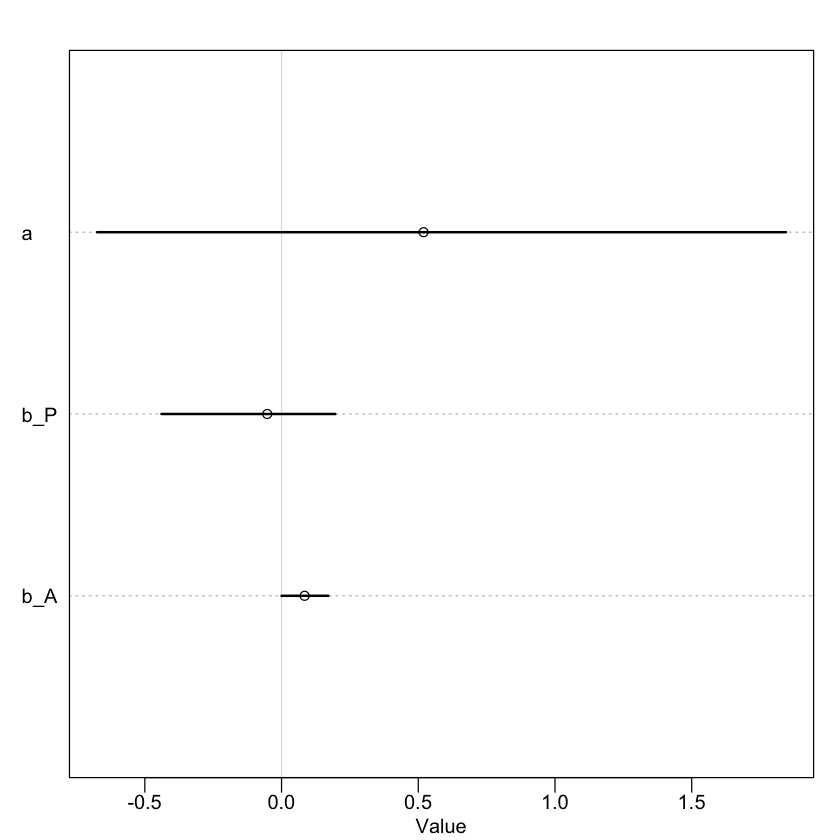

In [170]:
par(bg = 'white')
plot(precis(forest_age_salamander_model))

Hmmm, so the model seems pretty sure that forest age doesn't have anything to do with the number of salamanders. Let's compare the models.

In [175]:
compare(forest_age_salamander_model, salamander_model_ulam)

WAIC          SE            dWAIC       
salamander_model_ulam        1.629765e+31  6.540923e+30  0.00000e+00
forest_age_salamander_model 4.945460e+115 4.892566e+115 4.94546e+115
                            dSE          pWAIC         weight
salamander_model_ulam                 NA  8.148823e+30 1     
forest_age_salamander_model 4.94546e+115 2.472730e+115 0

From this, it seems like this model is doing a worse job of predicting the number of salamanders.

`geom_smooth()` using formula = 'y ~ x'


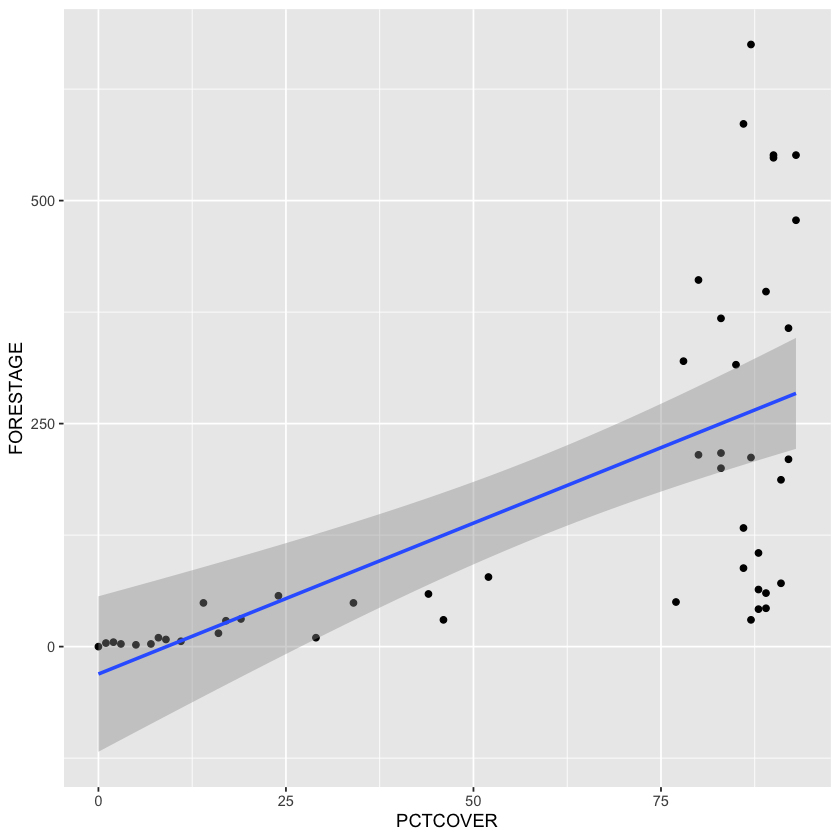

In [174]:
ggplot(d, aes(PCTCOVER, FORESTAGE)) +
    geom_point() +
    geom_smooth(method = 'lm')

Hmmmm... it doesn't look like there is a strong relationship between the cover and the age. However, since there is some relationship it looks like there might be some multicollinearity occurring (since there's a weak correlation between the forest age and cover).

### 11H4 The data in `data(NWOGrants)` are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) for 2010 - 2012. These data have a very similar structure to the `UCBAdmit` data discussed in the chapter. I want you to consider a similar question: What are the total and indirect causal effects of gender on grant awards? Consider a mediation path (a pipe) through `discipline`. Draw the corresponding DAG and then use one or more binomial GLMs to answer the question. What is your causal interpretation? If NWO's goal is to equalize rates of funding between men and women, what type of intervention would be most effective?

In [3]:
data(NWOGrants)
d <- NWOGrants
head(d)

discipline        gender applications awards
1 Chemical sciences m       83          22    
2 Chemical sciences f       39          10    
3 Physical sciences m      135          26    
4 Physical sciences f       39           9    
5 Physics           m       67          18    
6 Physics           f        9           2

In [4]:
summary(NWOGrants)

               discipline gender  applications        awards     
 Chemical sciences  :2    f:9    Min.   :  9.00   Min.   : 2.00  
 Earth/life sciences:2    m:9    1st Qu.: 69.75   1st Qu.:14.00  
 Humanities         :2           Median :130.50   Median :24.00  
 Interdisciplinary  :2           Mean   :156.83   Mean   :25.94  
 Medical sciences   :2           3rd Qu.:219.75   3rd Qu.:32.75  
 Physical sciences  :2           Max.   :425.00   Max.   :65.00  
 (Other)            :6                                           

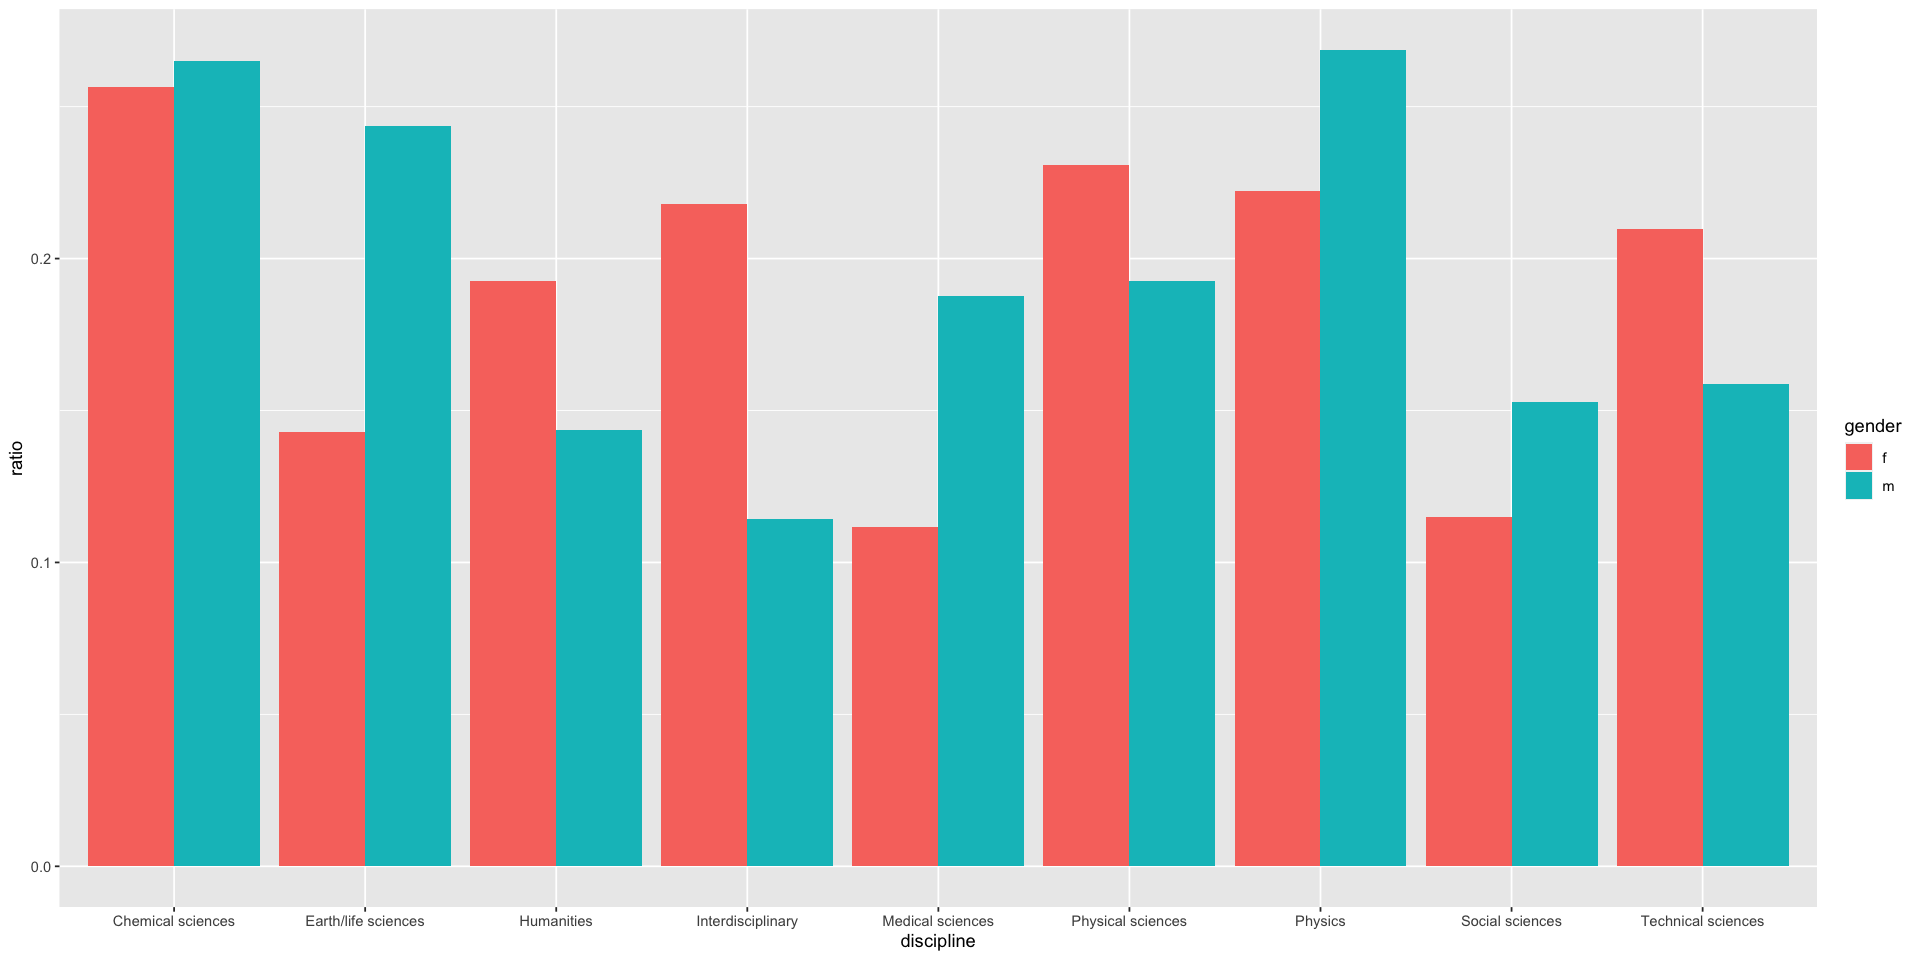

In [5]:
d$ratio <- d$awards / d$applications
ggplot(d, aes(discipline, ratio, fill = gender)) +
    geom_bar(stat = 'identity', position = position_dodge())

In [6]:
plot_df <- data.frame(discipline = unique(d$discipline))
plot_df$difference <- NA
for (i in 1:nrow(plot_df)) {
    relevant <- d[d$discipline == plot_df[i, 'discipline'], ]
    plot_df[i, 'difference'] <- relevant[relevant$gender == 'm', 'ratio'][1] - relevant[relevant$gender == 'f', 'ratio'][1]
}
plot_df

discipline          difference  
1 Chemical sciences    0.008649985
2 Physical sciences   -0.038176638
3 Physics              0.046434494
4 Humanities          -0.049292823
5 Technical sciences  -0.050947261
6 Interdisciplinary   -0.103663004
7 Earth/life sciences  0.100732601
8 Social sciences      0.038026751
9 Medical sciences     0.076216641

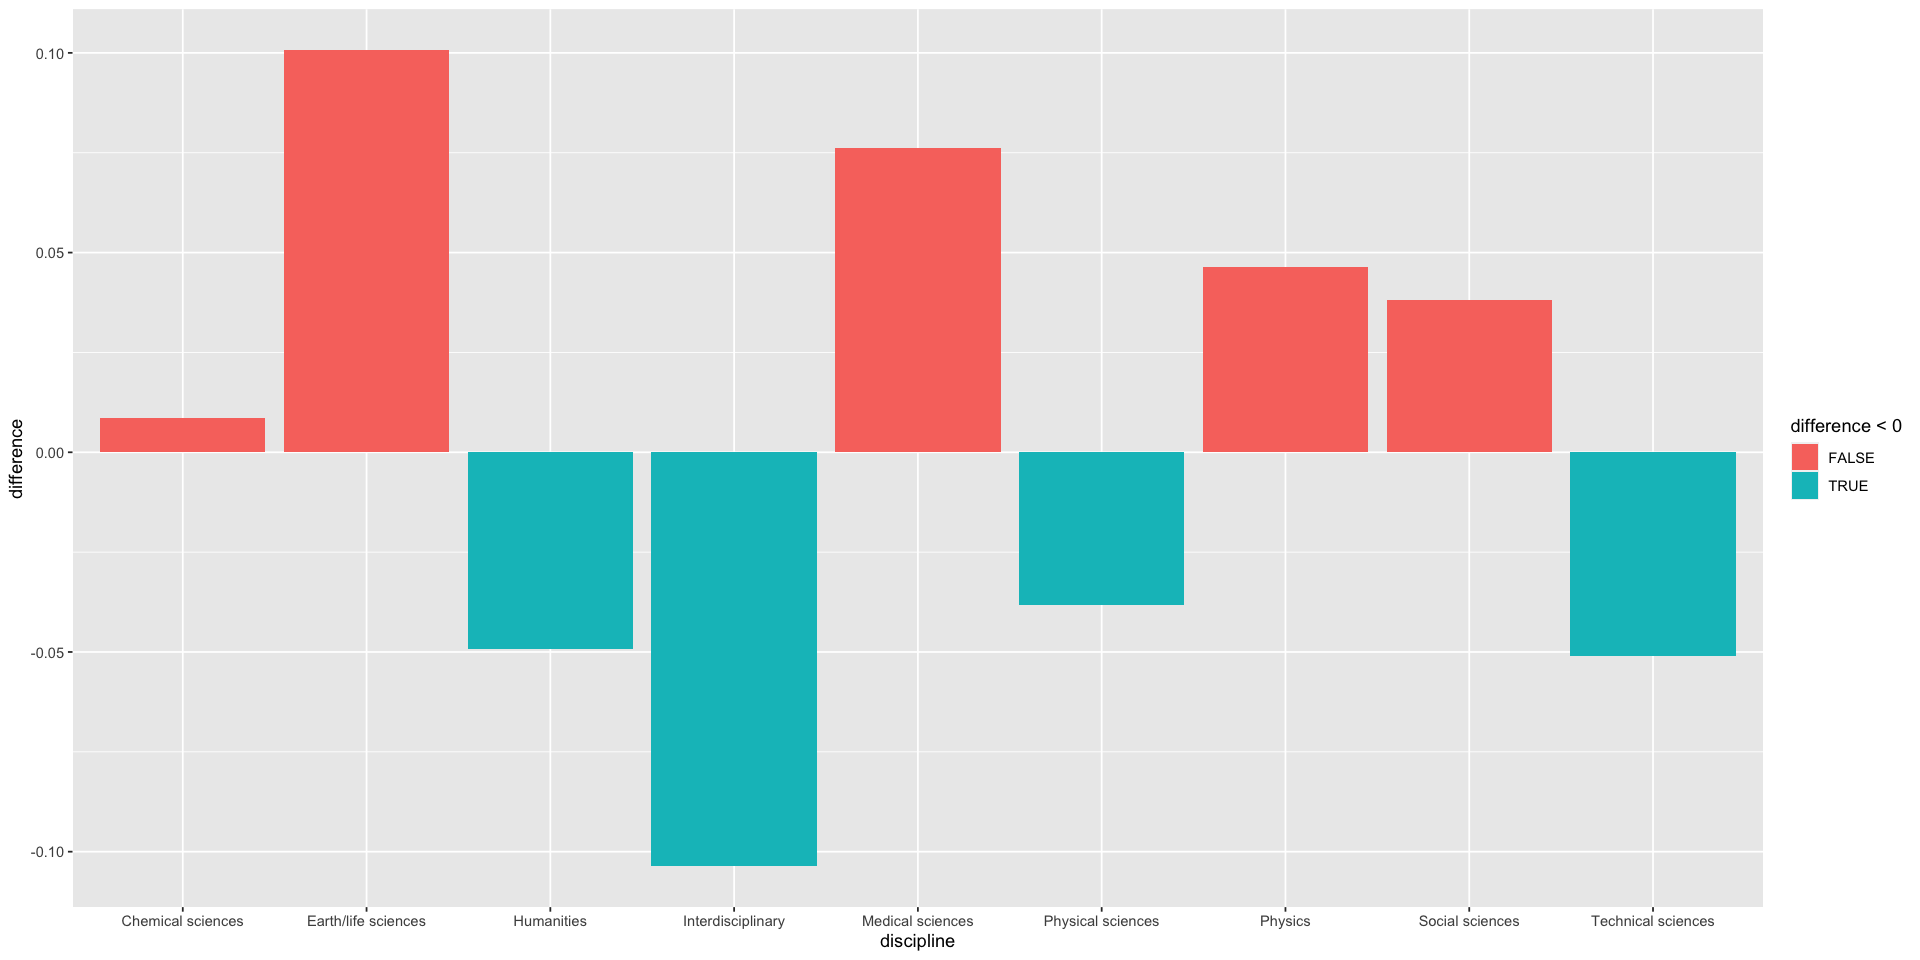

In [7]:
ggplot(plot_df, aes(discipline, difference, fill = difference < 0)) +
    geom_bar(stat = 'identity')

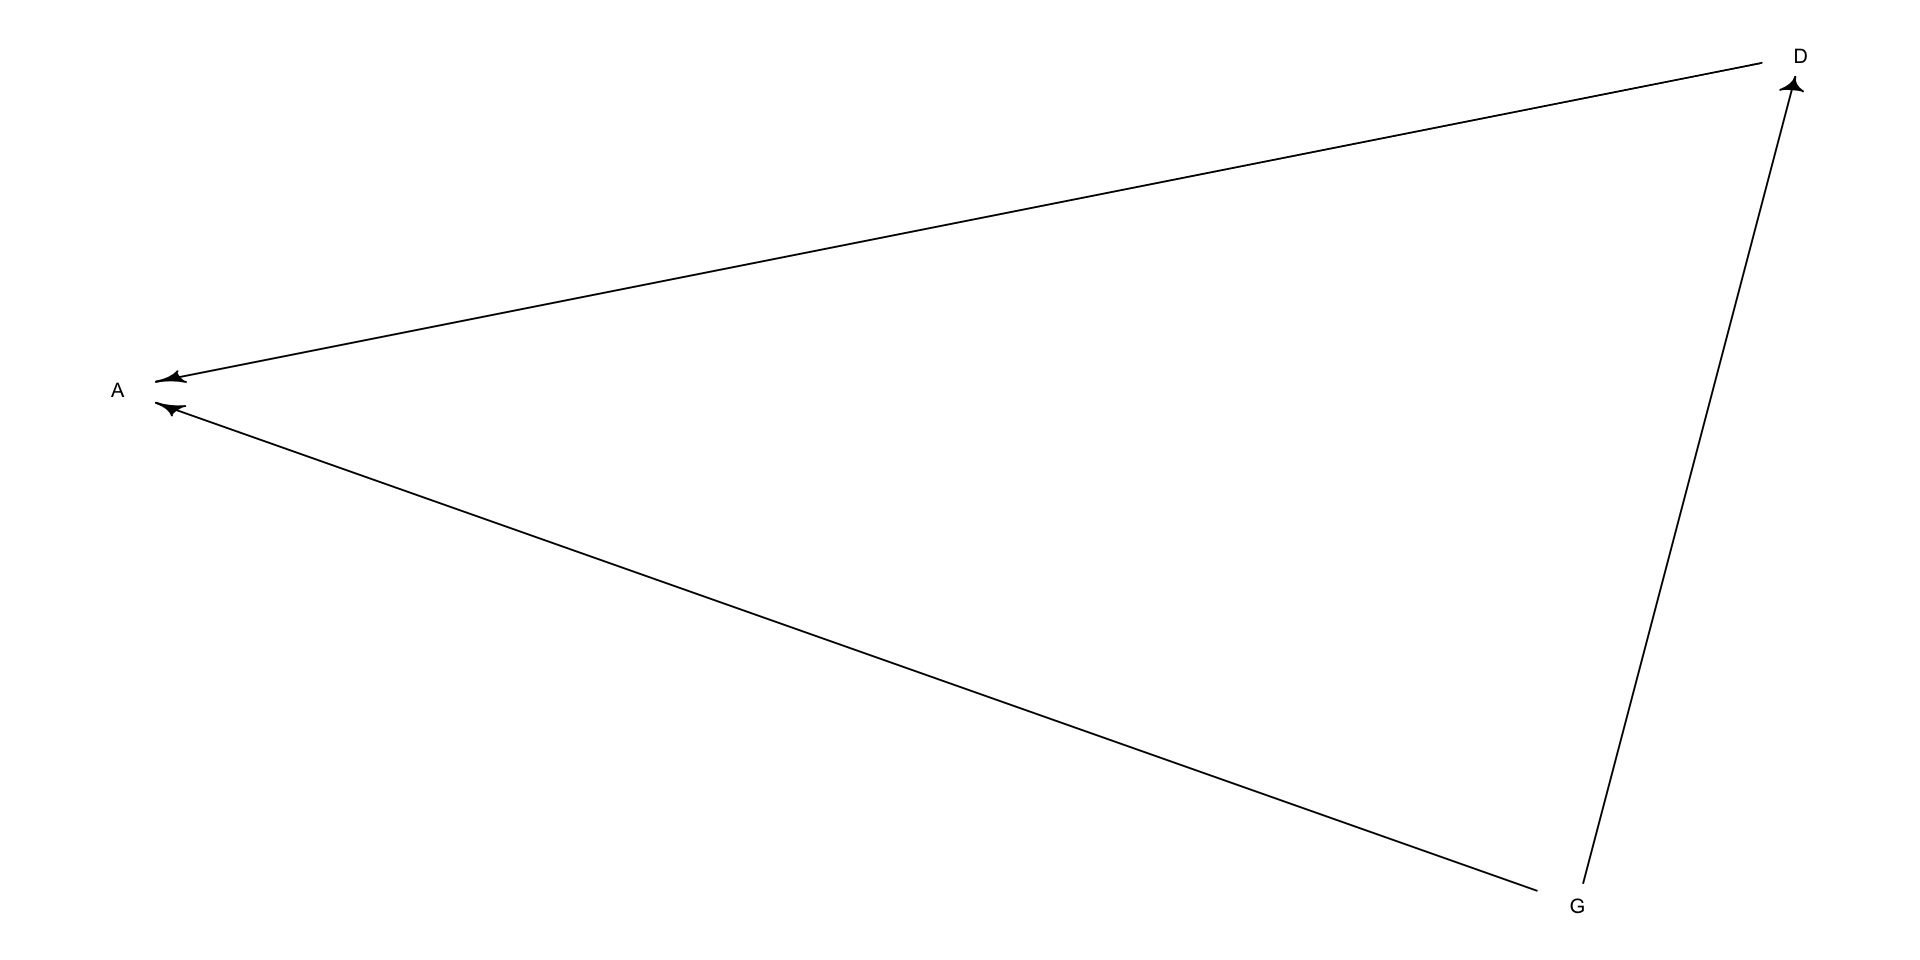

In [8]:
par(bg = 'white')
dag <- dagitty('dag{G -> D -> A; G -> A}')
drawdag(dag)

In [9]:
# total effect: A ~ G
head(d)

discipline        gender applications awards ratio    
1 Chemical sciences m       83          22     0.2650602
2 Chemical sciences f       39          10     0.2564103
3 Physical sciences m      135          26     0.1925926
4 Physical sciences f       39           9     0.2307692
5 Physics           m       67          18     0.2686567
6 Physics           f        9           2     0.2222222

In [10]:
nwo_data <- list(
    applications = d$applications,
    awards = d$awards,
    gid = ifelse(d$gender == "m", 1, 2),
    did = rep(1:length(unique(d$discipline)), each = 2) # department index
)
total_effects_model <- ulam(
    alist(
        awards ~ dbinom(applications, p),
        logit(p) <- a[gid],
        a[gid] ~ dnorm(0, 1.5)
    ),
    data = nwo_data,
    chains = 4,
    log_lik = TRUE
)

indirect_effects_model <- ulam(
    alist(
        awards ~ dbinom(applications, p),
        logit(p) <- a[gid] + d[did],
        a[gid] ~ dnorm(0, 1.5),
        d[did] ~ dnorm(0, 1.5)
    ),
    data = nwo_data,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

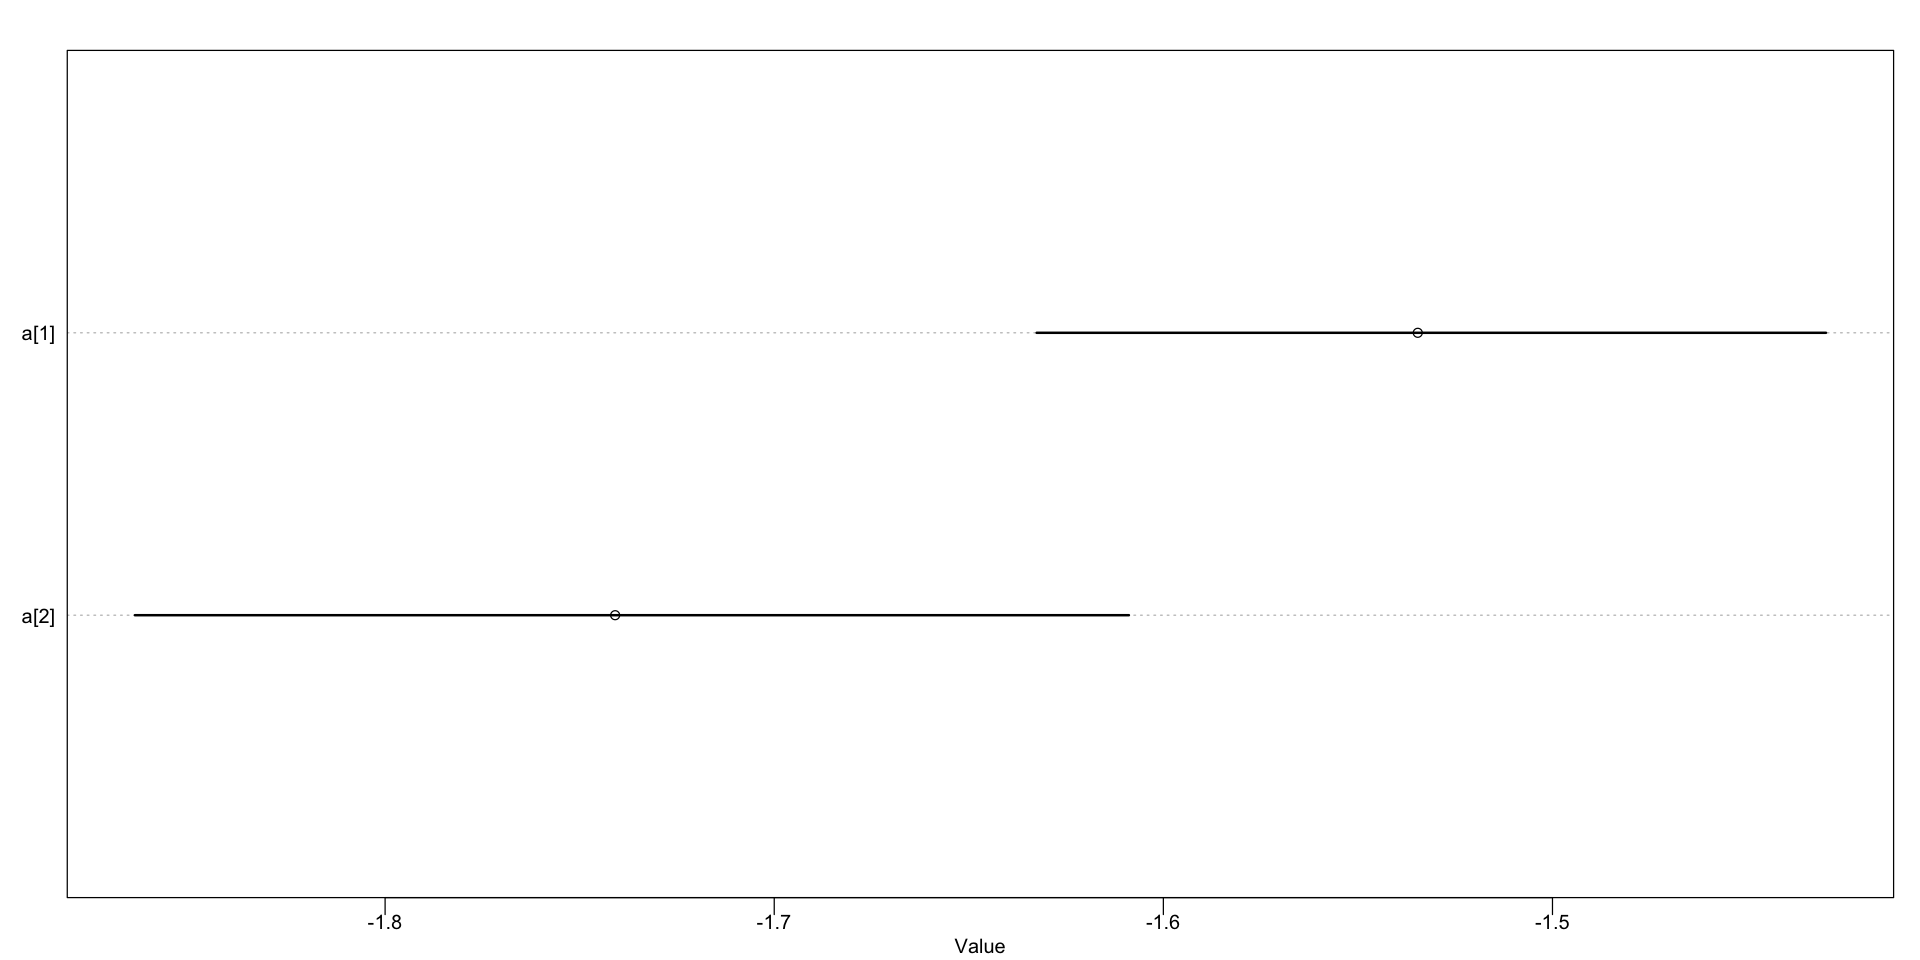

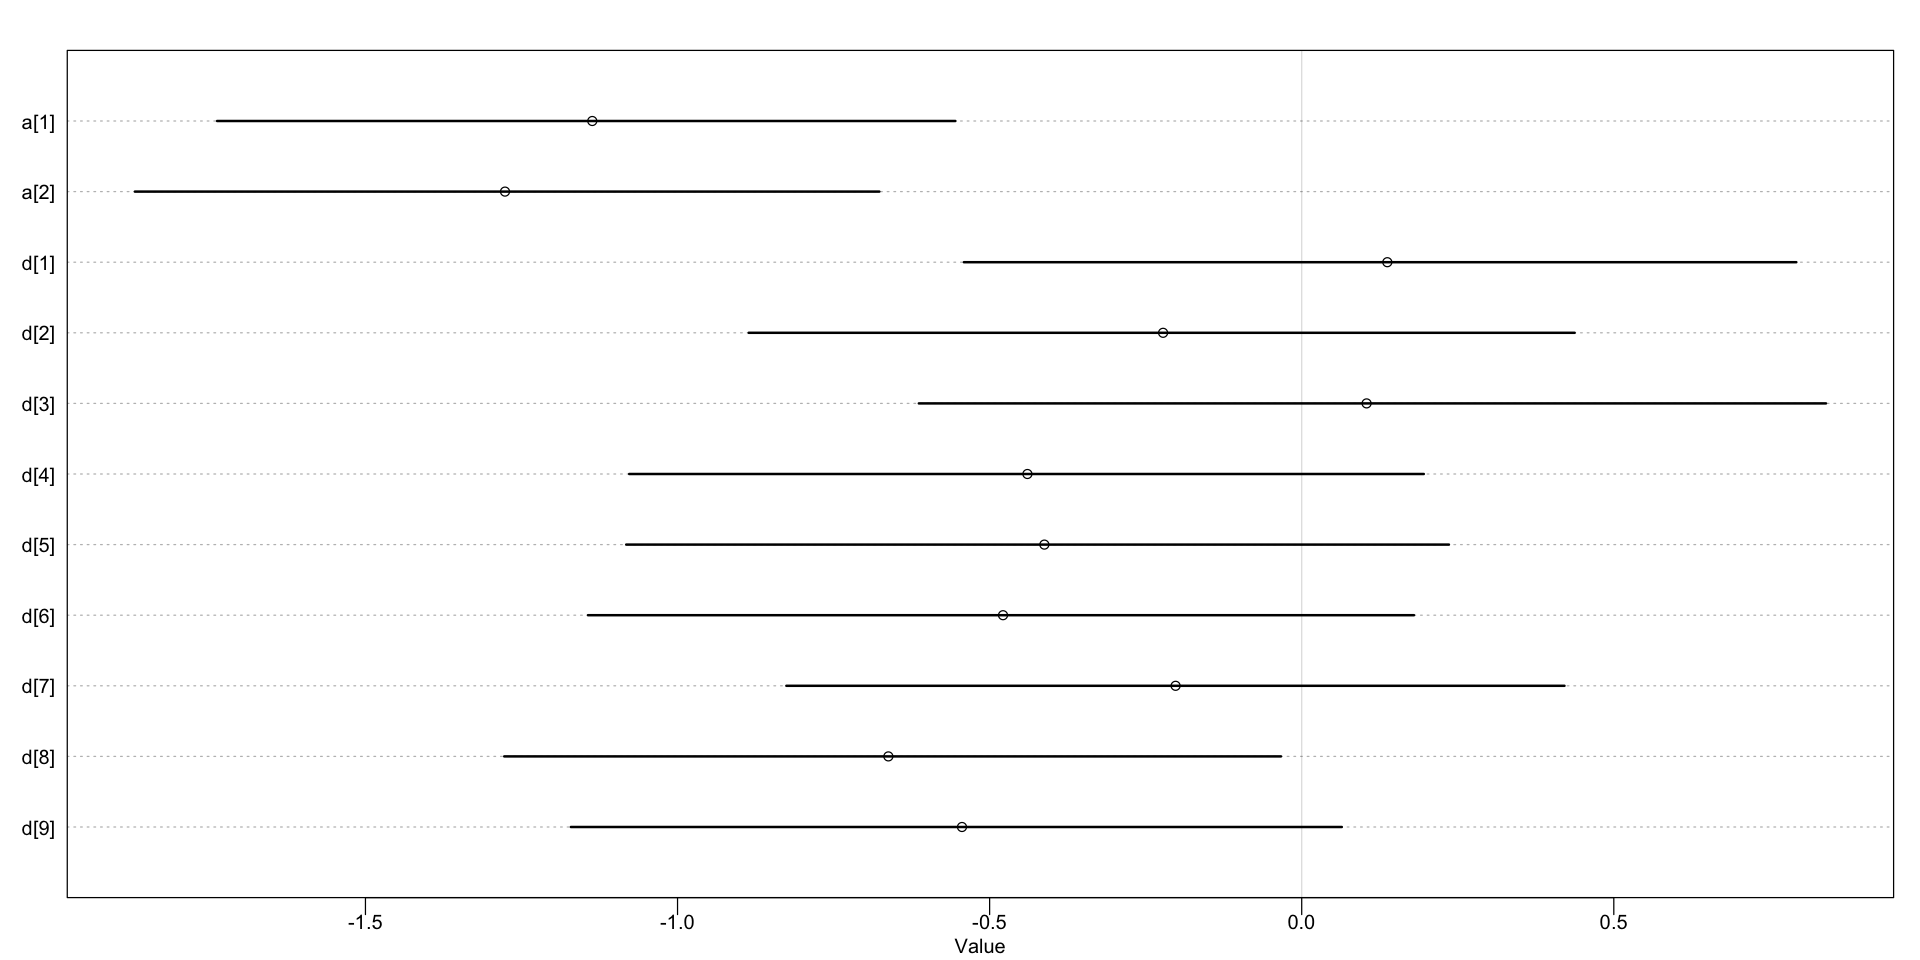

In [11]:
par(bg = 'white')
plot(precis(total_effects_model, depth = 2))
plot(precis(indirect_effects_model, depth = 2))

In [12]:
compare(indirect_effects_model, total_effects_model, func = WAIC)

WAIC     SE       dWAIC    dSE      pWAIC     weight   
indirect_effects_model 128.2117 8.016974 0.000000       NA 12.426389 0.6687232
total_effects_model    129.6165 8.757184 1.404832 9.277178  4.670875 0.3312768

From this, it looks like the two models do roughly as good a job explaining the discrimination. This is also borne out by the parameters above, where most of the $\delta$ parameters are clustered around zero, thus not contributing much to `logit(p)`. It seems like directly funding whole-university measures to get women to apply for the grants or provide them support or somesuch would be the most effective, rather than targeting individual departments.

### 11H5 Suppose that the NWO Grants sample has an unobserved confound that influences both the choice of discipline and the proavility of an award. One example of such a confound could be the career stage of each applicant. Suppose that in some disciplines, junior scholars apply for most of the grants. On other disciplines, scholars from all career stages compete. As a result, career stage influences discipline as well as the probability of being awarded a grant. Add these influences to your DAG from the previous proble. What happens now when you condition on discipline? Does it provide an un-confounded estimate of the direct path from gender to an award? Why or why not? Justify your answer with the backdoor criterion. If you have trouble thinks thins though, try simulating fake data, assuming your DAG is true. Then analyze it using the model from the previous problem. What do you conclude? Is it possible for gender to have a real direct causal influence but for a regression conditioning on both gender and discipline to suggest zero influence?

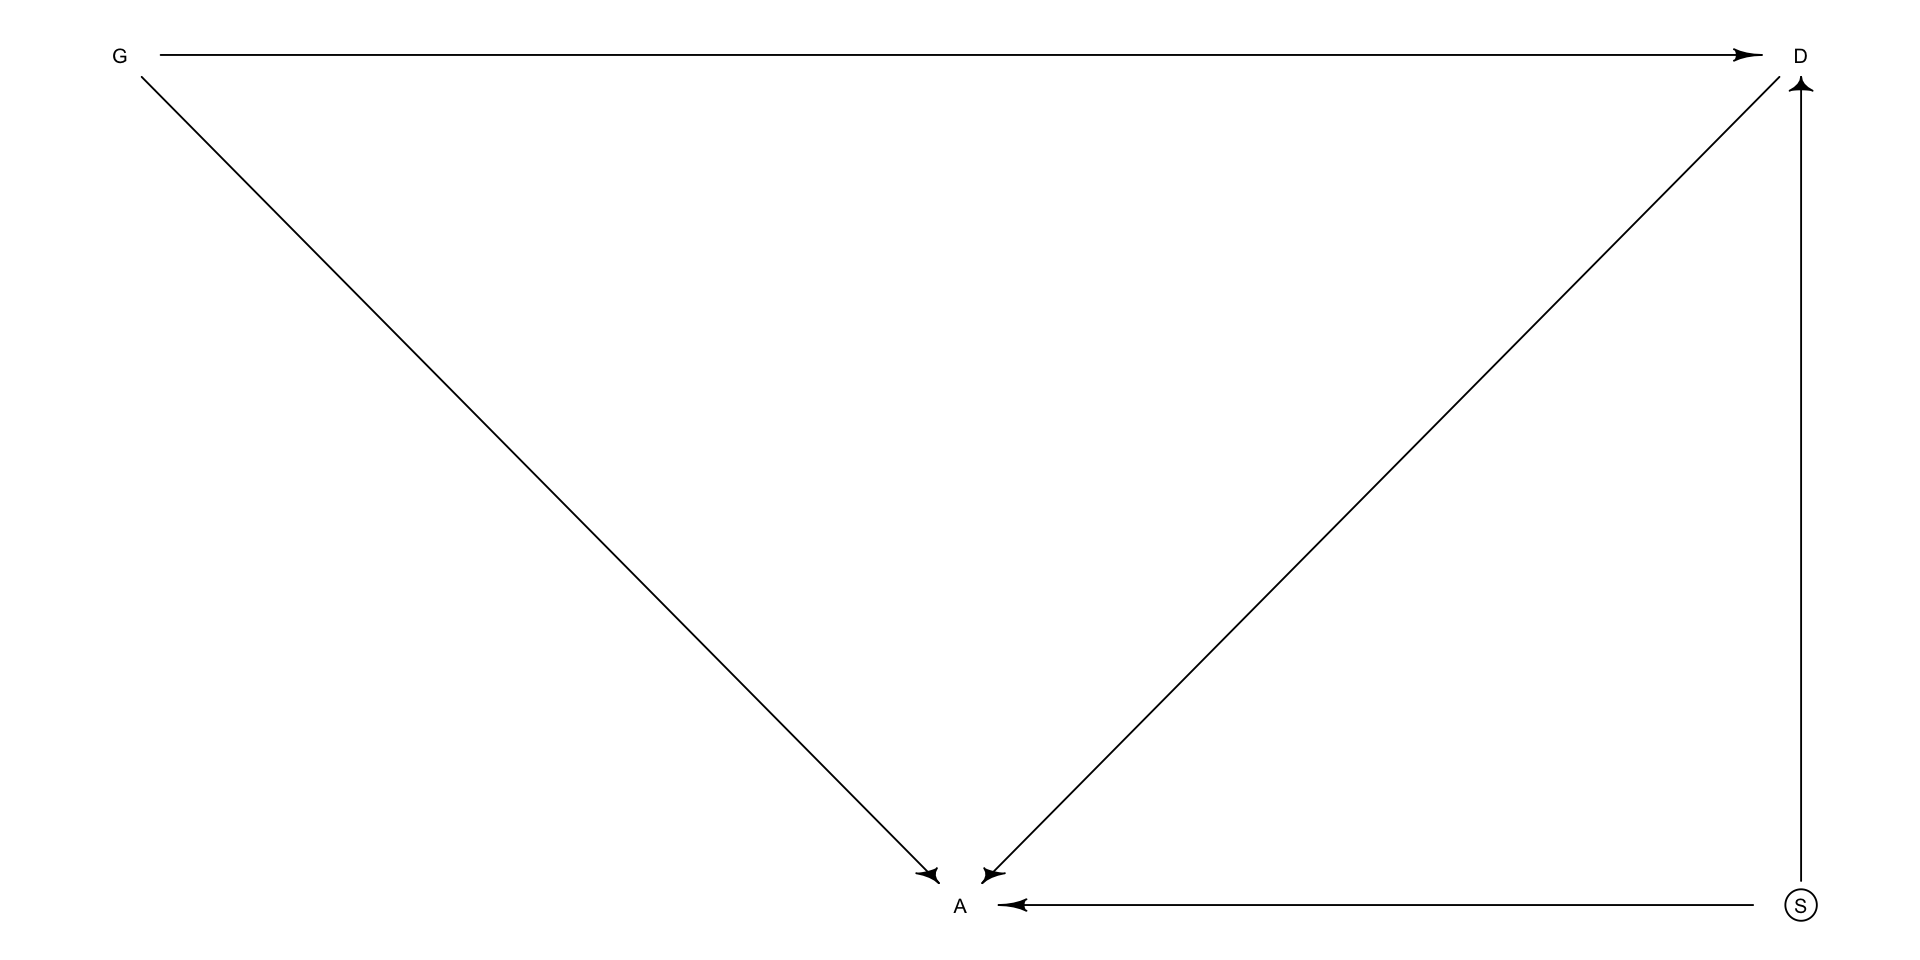

In [18]:
par(bg = 'white')
dag <- dagitty('dag{
    G[pos="0,0"]
    D[pos="1,0"]
    A[pos="0.5,1"]
    S[unobserved, pos="1,1"]
    G -> D -> A; G -> A; A <- S -> D;
    }')
drawdag(dag)

$D$ is now a collider, which means that by conditioning on it we open up a backdoor path through the career stage. If this DAG is correct, then there is no way (with the data that we have) to get an estimate of the indrect effects of gender on the admission rate. It is certainly possible for the gender to have a real effect, but to show no effect when conditioning on a collider.

### 11H6 The data in `data(Primates301)` are 301 primate species and associated measures. In this problem, you will consider how brain size is associated with social learning. There are three parts.
#### a) Model the number of observations of `social_learning` for each species as a function of the log `brain` size. Use a Poisson distribution for the `social_learning` outcome variable. Interpret the resulting posterior.

In [3]:
data(Primates301)
d <- Primates301
head(d)

name                        genus          species      subspecies spp_id
1 Allenopithecus_nigroviridis Allenopithecus nigroviridis NA         1     
2 Allocebus_trichotis         Allocebus      trichotis    NA         2     
3 Alouatta_belzebul           Alouatta       belzebul     NA         3     
4 Alouatta_caraya             Alouatta       caraya       NA         4     
5 Alouatta_guariba            Alouatta       guariba      NA         5     
6 Alouatta_palliata           Alouatta       palliata     NA         6     
  genus_id social_learning research_effort brain body    group_size gestation
1 1        0                6              58.02 4655.00 40.0           NA   
2 2        0                6                 NA   78.09  1.0           NA   
3 3        0               15              52.84 6395.00  7.4           NA   
4 3        0               45              52.63 5383.00  8.9       185.92   
5 3        0               37              51.70 5175.00  7.4           NA   
6 3        3               79              49.88 6250.00 13.1       185.42   
  weaning longevity sex_maturity maternal_investment
1 106.15  276.0          NA          NA             
2     NA     NA          NA          NA             
3     NA     NA          NA          NA             
4 323.16  243.6     1276.72      509.08             
5     NA     NA          NA          NA             
6 495.60  300.0     1578.42      681.02

In [4]:
summary(d)

                          name                genus            species   
 Allenopithecus_nigroviridis:  1   Macaca        : 24   fulvus     :  7  
 Allocebus_trichotis        :  1   Cercopithecus : 22   griseus    :  5  
 Alouatta_belzebul          :  1   Microcebus    : 17   troglodytes:  4  
 Alouatta_caraya            :  1   Lepilemur     : 16   cephus     :  3  
 Alouatta_guariba           :  1   Trachypithecus: 13   geoffroyi  :  3  
 Alouatta_palliata          :  1   Eulemur       : 12   nemestrina :  3  
 (Other)                    :295   (Other)       :197   (Other)    :276  
        subspecies      spp_id       genus_id     social_learning
 alaotrensis :  1   Min.   :  1   Min.   : 1.00   Min.   :  0.0  
 albifrons   :  1   1st Qu.: 76   1st Qu.:17.00   1st Qu.:  0.0  
 albocollaris:  1   Median :151   Median :36.00   Median :  0.0  
 atys        :  1   Mean   :151   Mean   :34.19   Mean   :  2.3  
 boliviensis :  1   3rd Qu.:226   3rd Qu.:48.00   3rd Qu.:  0.0  
 (Other)    

In [5]:
# first, let's filter out the rows with NA
# TODO actually filter out the NA values
filtered <- d[!is.na(d$brain) & !is.na(d$social_learning) & !is.na(d$research_effort), ]
# nrow(d) - nrow(filtered)
filtered

name                        genus          species        subspecies spp_id
1   Allenopithecus_nigroviridis Allenopithecus nigroviridis   NA          1    
3   Alouatta_belzebul           Alouatta       belzebul       NA          3    
4   Alouatta_caraya             Alouatta       caraya         NA          4    
5   Alouatta_guariba            Alouatta       guariba        NA          5    
6   Alouatta_palliata           Alouatta       palliata       NA          6    
7   Alouatta_pigra              Alouatta       pigra          NA          7    
8   Alouatta_sara               Alouatta       sara           NA          8    
9   Alouatta_seniculus          Alouatta       seniculus      NA          9    
10  Aotus_azarai                Aotus          azarai         NA         10    
14  Aotus_lemurinus             Aotus          lemurinus      NA         14    
18  Aotus_trivirgatus           Aotus          trivirgatus    NA         18    
22  Arctocebus_calabarensis     Arctocebus     calabarensis   NA         22    
23  Ateles_belzebuth            Ateles         belzebuth      NA         23    
24  Ateles_fusciceps            Ateles         fusciceps      NA         24    
25  Ateles_geoffroyi            Ateles         geoffroyi      NA         25    
26  Ateles_paniscus             Ateles         paniscus       NA         26    
28  Avahi_laniger               Avahi          laniger        NA         28    
29  Avahi_occidentalis          Avahi          occidentalis   NA         29    
32  Bunopithecus_hoolock        Bunopithecus   hoolock        NA         32    
33  Cacajao_calvus              Cacajao        calvus         NA         33    
34  Cacajao_melanocephalus      Cacajao        melanocephalus NA         34    
40  Callimico_goeldii           Callimico      goeldii        NA         40    
41  Callithrix_argentata        Callithrix     argentata      NA         41    
46  Callithrix_jacchus          Callithrix     jacchus        NA         46    
50  Callithrix_pygmaea          Callithrix     pygmaea        NA         50    
51  Cebus_albifrons             Cebus          albifrons      NA         51    
52  Cebus_apella                Cebus          apella         NA         52    
53  Cebus_capucinus             Cebus          capucinus      NA         53    
54  Cebus_olivaceus             Cebus          olivaceus      NA         54    
57  Cercocebus_galeritus        Cercocebus     galeritus      NA         57    
⋮   ⋮                           ⋮              ⋮              ⋮          ⋮     
246 Pithecia_pithecia           Pithecia       pithecia       NA         246   
248 Pongo_pygmaeus              Pongo          pygmaeus       NA         248   
249 Presbytis_comata            Presbytis      comata         NA         249   
250 Presbytis_melalophos        Presbytis      melalophos     NA         250   
251 Procolobus_verus            Procolobus     verus          NA         251   
254 Propithecus_diadema         Propithecus    diadema        NA         254   
257 Propithecus_verreauxi       Propithecus    verreauxi      NA         257   
259 Pygathrix_nemaeus           Pygathrix      nemaeus        NA         259   
263 Rhinopithecus_roxellana     Rhinopithecus  roxellana      NA         263   
266 Saguinus_fuscicollis        Saguinus       fuscicollis    NA         266   
270 Saguinus_leucopus           Saguinus       leucopus       NA         270   
271 Saguinus_midas              Saguinus       midas          NA         271   
272 Saguinus_mystax             Saguinus       mystax         NA         272   
274 Saguinus_oedipus            Saguinus       oedipus        NA         274   
277 Saimiri_oerstedii           Saimiri        oerstedii      NA         277   
278 Saimiri_sciureus            Saimiri        sciureus       NA         278   
280 Semnopithecus_entellus      Semnopithecus  entellus       NA         280   
281 Symphalangus_syndactylus    Symphalangus   syndactylus    NA         281   
282 

In [6]:
data <- list(
    s = filtered$social_learning,
    b = normalize(log(filtered$brain))
)

primate_social_learning_model_1 <- ulam(
    alist(
        s ~ dpois(lambda),
        log(lambda) <- a + b_b * b,
        a ~ dnorm(0, 1),
        b_b ~ dnorm(0, 0.5)
    ),
    data = data,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

mean      sd        5.5%      94.5%     rhat     ess_bulk
a   -4.829520 0.2292752 -5.179700 -4.473379 1.020387 350.2590
b_b  8.722104 0.2864944  8.266605  9.166238 1.018082 344.9024

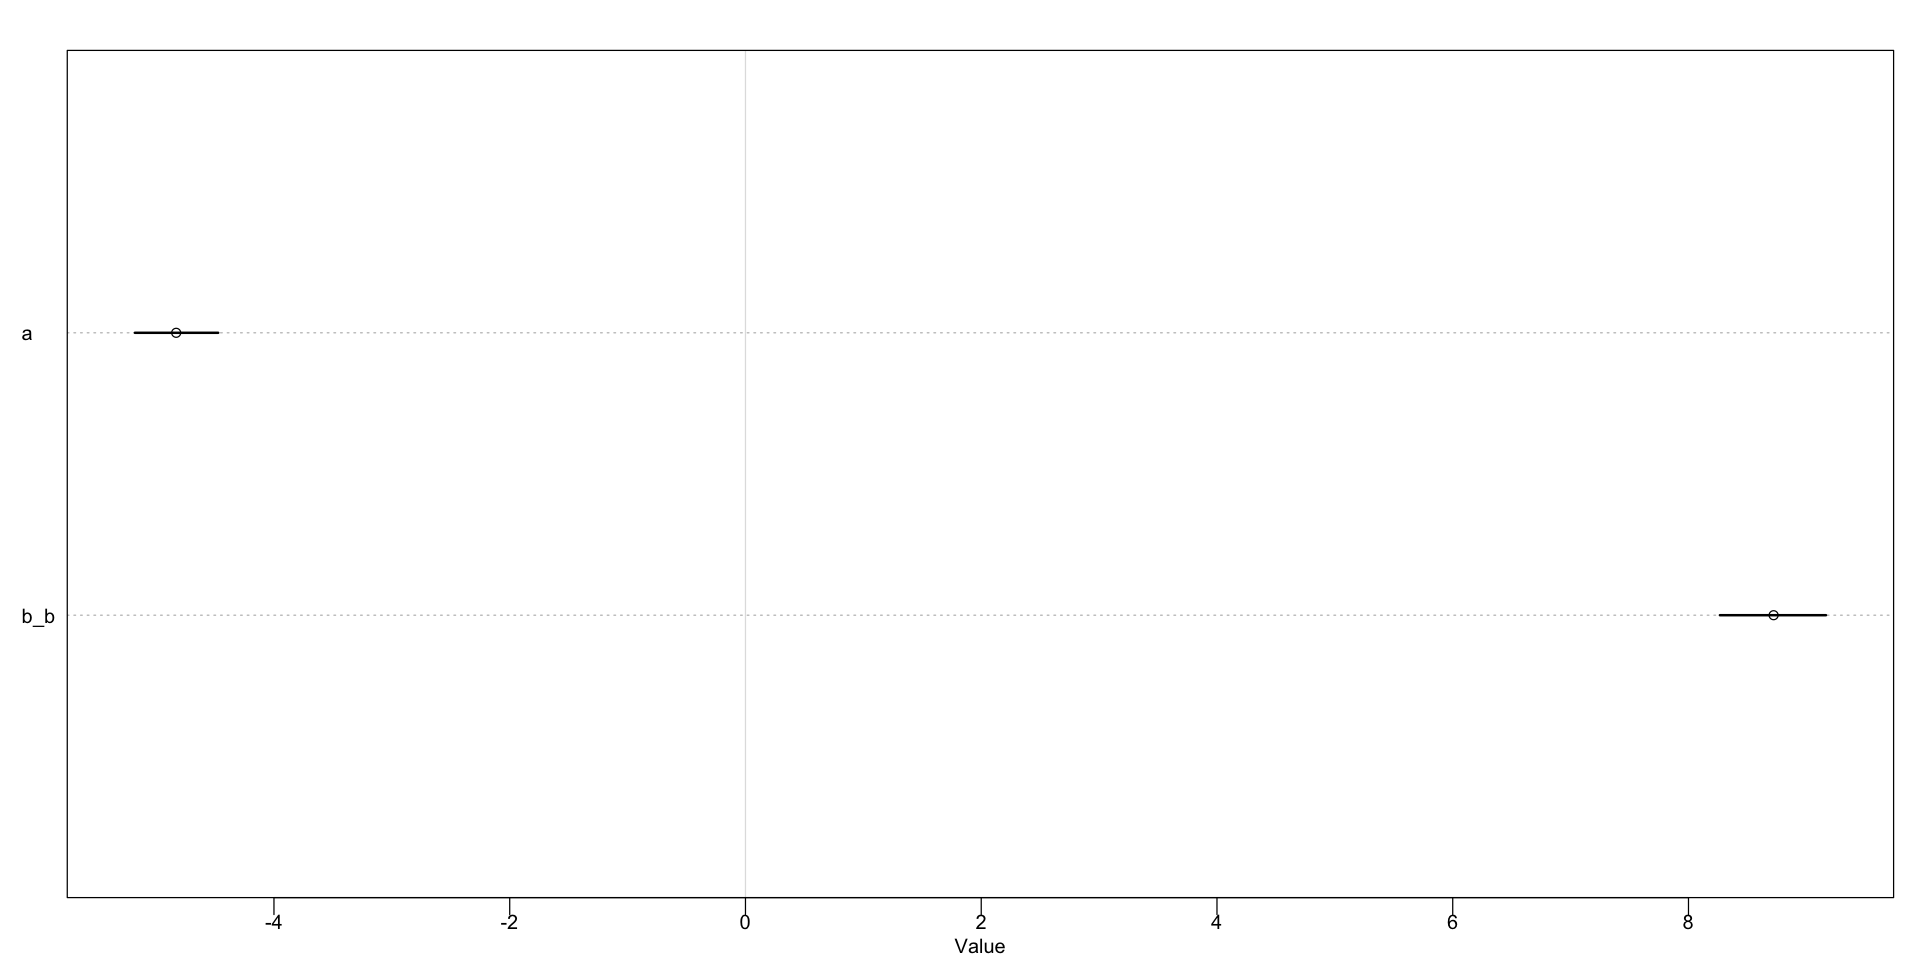

In [7]:
par(bg = 'white')
precis(primate_social_learning_model_1)
plot(precis(primate_social_learning_model_1))

In [8]:
samples <- extract.samples(primate_social_learning_model_1)
lapply(samples, head)

$a
         [,1]
[1,] -4.73463
[2,] -4.98671
[3,] -4.96773
[4,] -5.02689
[5,] -4.64126
[6,] -4.74712

$b_b
        [,1]
[1,] 8.68895
[2,] 8.83919
[3,] 8.94851
[4,] 8.94834
[5,] 8.47234
[6,] 8.64739

$lambda
        [,1]    [,2]    [,3]    [,4]    [,5]    [,6]    [,7]    [,8]     [,9]
[1,] 2.02264 1.75419 1.74359 1.69690 1.60678 1.66849 2.07917 1.87590 0.420178
[2,] 1.72698 1.49409 1.48490 1.44446 1.36646 1.41987 1.77609 1.59961 0.349141
[3,] 1.88473 1.62765 1.61752 1.57293 1.48697 1.54582 1.93900 1.74407 0.373574
[4,] 1.77627 1.53399 1.52444 1.48241 1.40141 1.45687 1.82742 1.64371 0.352087
[5,] 1.93902 1.68765 1.67770 1.63388 1.54922 1.60721 1.99184 1.80173 0.418900
[6,] 1.94624 1.68908 1.67892 1.63417 1.54779 1.60695 2.00037 1.80570 0.407357
        [,10]    [,11]     [,12]   [,13]   [,14]   [,15]   [,16]    [,17]
[1,] 0.292666 0.307834 0.0794041 5.88608 5.67450 4.99716 4.90766 0.136136
[2,] 0.241671 0.254418 0.0641060 5.11937 4.93222 4.33395 4.25500 0.110937
[3,] 0.257409 0.271159 0.0671692 5.66260 5.45308 4.78397 4.69575 0.117030
[4,] 0.242606 0.255564 0.0633079 5.33662 5.13917 4.50859 4.42545 0.110301
[5,] 0.294419 0.309288 0.0825199 5.49446 5.30179 4.68376 4.60194 0.139590
[6,] 0.284228 0.298886 0.0775972 5.63489 5.43328 4.78764 4.70230 0.132696
         [,18]   [,19]   [,20]   [,21]    [,22]     [,23]     [,24]     [,25]
[1,] 0.0980835 5.40746 3.05085 2.62010 0.170482 0.0980835 0.0850619 0.0367212
[2,] 0.0794764 4.69620 2.62347 2.24714 0.139467 0.0794764 0.0687556 0.0292537
[3,] 0.0834958 5.18899 2.87796 2.46041 0.147543 0.0834958 0.0721034 0.0303556
[4,] 0.0786956 4.89028 2.71232 2.31881 0.139059 0.0786956 0.0679584 0.0286111
[5,] 0.1013970 5.05837 2.89491 2.49563 0.173829 0.1013970 0.0882482 0.0389029
[6,] 0.0957548 5.17879 2.92985 2.51801 0.165995 0.0957548 0.0830989 0.0360182
       [,26]   [,27]   [,28]   [,29]   [,30]   [,31]   [,32]   [,33]   [,34]
[1,] 2.42996 2.49697 2.86520 2.68242 4.56789 5.06247 2.10602 1.98929 2.41922
[2,] 2.08135 2.13976 2.46115 2.30153 3.95550 4.39157 1.79943 1.69802 2.07200
[3,] 2.27672 2.34142 2.69777 2.52070 4.36130 4.84837 1.96480 1.85274 2.26637
[4,] 2.14569 2.20666 2.54250 2.37563 4.11025 4.56928 1.85173 1.74612 2.13594
[5,] 2.31887 2.38120 2.72301 2.55349 4.29100 4.74343 2.01692 1.90784 2.30888
[6,] 2.33612 2.40024 2.75239 2.57762 4.37825 4.84991 2.02608 1.91430 2.32585
       [,35]   [,36]   [,37]   [,38]   [,39]   [,40]   [,41]   [,42]   [,43]
[1,] 2.27125 2.42713 2.45544 2.94152 2.77004 2.22885 2.45941 2.75823 1.86867
[2,] 1.94314 2.07889 2.10356 2.52786 2.37803 1.90625 2.10702 2.36771 1.59333
[3,] 2.12373 2.27399 2.30132 2.77180 2.60554 2.08292 2.30515 2.59409 1.73714
[4,] 2.00151 2.14312 2.16887 2.61227 2.45558 1.96305 2.17249 2.44479 1.63718
[5,] 2.17106 2.31624 2.34257 2.79370 2.63479 2.13154 2.34627 2.62383 1.79495
[6,] 2.18424 2.33342 2.36050 2.82534 2.66140 2.14367 2.36430 2.65011 1.79876
       [,44]   [,45]     [,46]     [,47]   [,48]   [,49]   [,50]   [,51]
[1,] 2.10494 2.20749 0.0608460 0.0178870 1.53138 2.40456 3.15536 2.95299
[2,] 1.79849 1.88766 0.0488977 0.0140734 1.30126 2.05922 2.71492 2.53789
[3,] 1.96376 2.06236 0.0510629 0.0144720 1.41516 2.25222 2.97954 2.78293
[4,] 1.85075 1.94367 0.0481278 0.0136404 1.33373 2.12261 2.80805 2.62276
[5,] 2.01591 2.11161 0.0636546 0.0192926 1.47829 2.29523 2.99156 2.80433
[6,] 2.02505 2.12321 0.0595372 0.0176050 1.47550 2.31182 3.02972 2.83631
       [,52]   [,53]   [,54]   [,55]    [,56]    [,57]    [,58]    [,59]
[1,] 2.91921 2.98387 1.36668 4.47415 0.419559 0.587839 0.544640 0.404801
[2,] 2.50836 2.56489 1.15903 3.87294 0.348618 0.491301 0.454596 0.336147
[3,] 2.75015 2.81291 1.25868 4.26915 0.373007 0.527908 0.487999 0.359501
[4,] 2.59187 2.65101 1.18625 4.02341 0.351553 0.497540 0.459928 0.338824
[5,] 2.77304 2.83292 1.32305 4.20512 0.418299 0.581166 0.539483 0.403945
[6,] 2.80402 2.86583 1.31753 4.28883 0.406760 0.568988 0.527367 0.392519
        [,60]     [,61]     [,62]     [,63]     [,64]     [,65]   [,66]
[1,] 0.6038

In [9]:
posterior_lambda_means <- apply(samples$lambda, 2, mean)
posterior_lambda_ranges <- apply(samples$lambda, 2, PI)
head(posterior_lambda_ranges)

[,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]    
5%  1.690990 1.460057 1.450851 1.410556 1.332998 1.386437 1.739943 1.564812
94% 2.080967 1.814693 1.804350 1.758475 1.668270 1.729674 2.137675 1.933338
    [,9]      [,10]     [,11] [,12]      [,13]    [,14]    [,15]    [,16]   
5%  0.3272314 0.2235456 ⋯     0.01786677 6.218723 1.683424 2.881245 3.071093
94% 0.4605060 0.3258945 ⋯     0.03270554 7.214618 2.072491 3.427656 3.634447
    [,17]    [,18]    [,19]    [,20]    [,21]    
5%  1.882456 2.424270 4.215132 1.843428 0.6628805
94% 2.302012 2.912698 4.929703 2.256809 0.8759700

In [10]:
plot_df <- data.frame(
    name = filtered$name,
    s = data$s,
    b = data$b,
    mean_lambda = posterior_lambda_means,
    lambda_lower = posterior_lambda_ranges[1, ],
    lambda_upper = posterior_lambda_ranges[2, ]
)

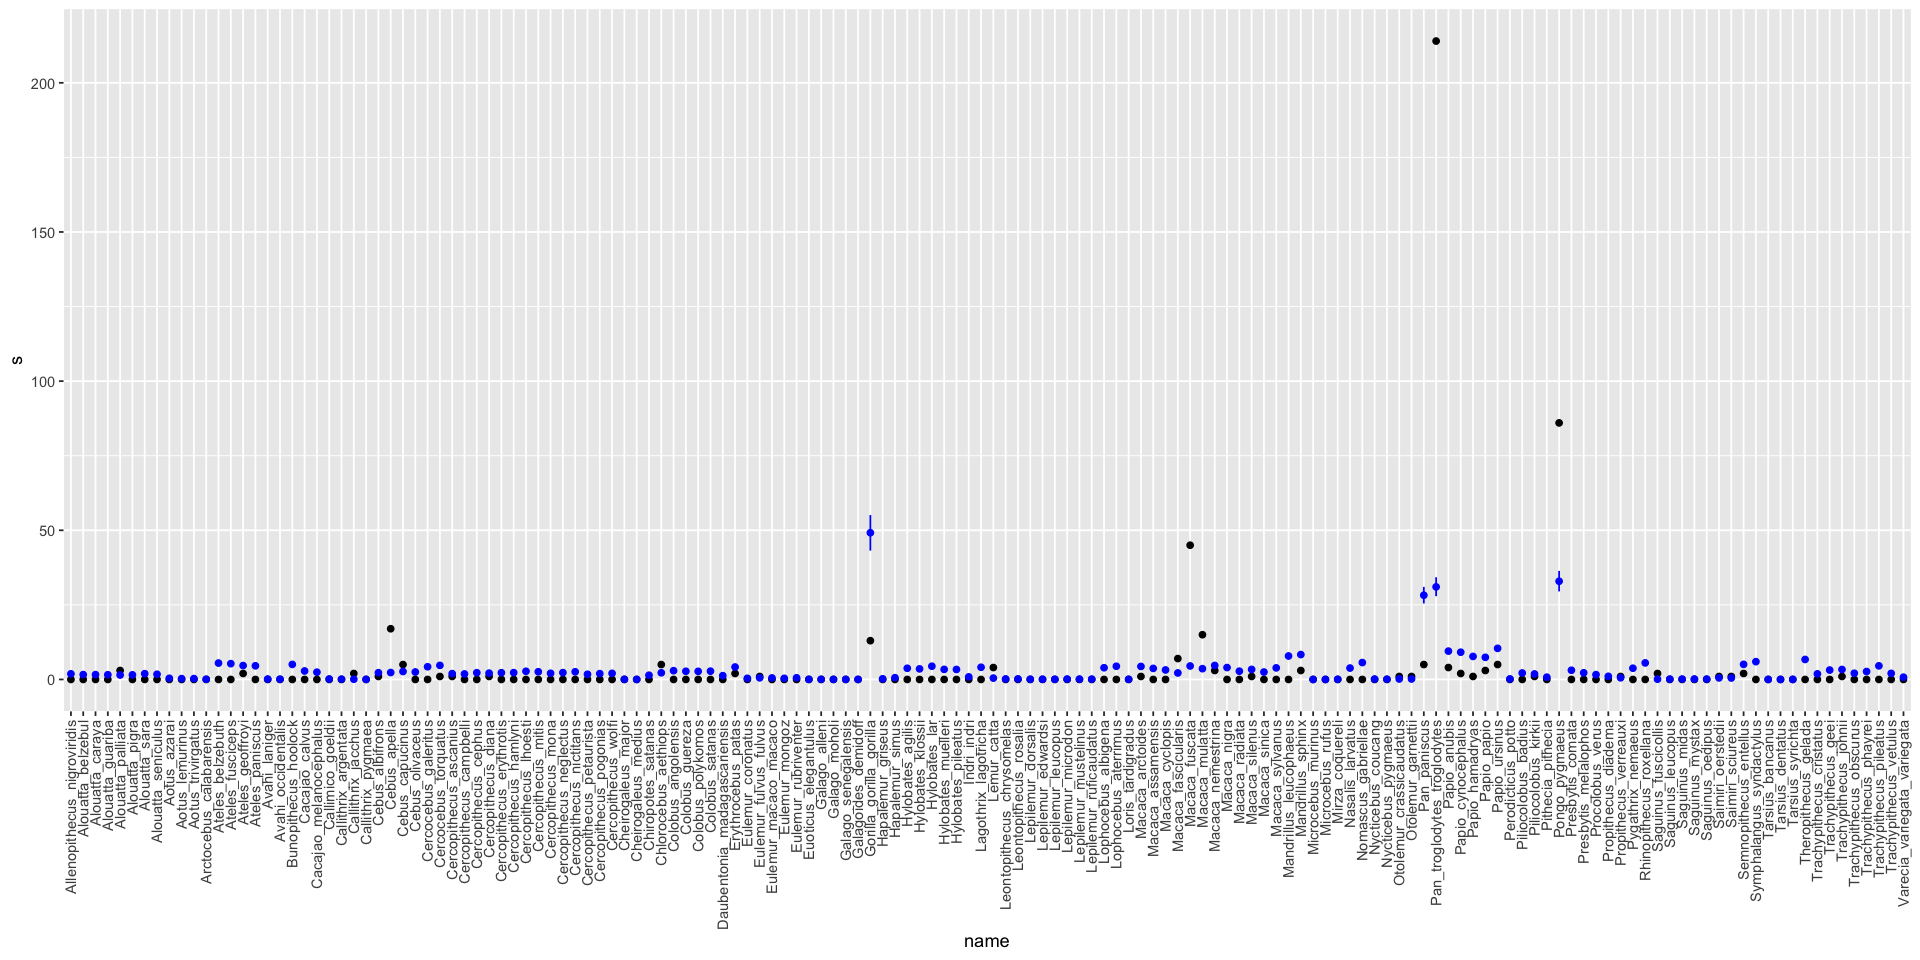

In [11]:
ggplot(plot_df, aes(name, s)) +
    geom_point() +
    geom_point(data = plot_df, mapping = aes(name, mean_lambda), colour = 'blue', position = position_dodge(width = 0.1)) +
    geom_linerange(mapping = aes(name, ymin = lambda_lower, ymax = lambda_upper), colour = 'blue', position = position_dodge(width = 0.1)) +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))

Generally this does a good job, but there are definitely a few outliers where our prediction is badly wrong.

#### b) Some species are studied much more than others. So the number of reported instances of `social_learning` could be a product od reearch effort. Use the `research_effort` variable, specifically its logarithm, as an additional predictor variable. Interpret the coefficient for lof `research_effort`. How does this model differ from the previous one?

In [12]:
data <- list(
    s = filtered$social_learning,
    b = normalize(log(filtered$brain)),
    e = log(filtered$research_effort)
)

primate_social_learning_model_2 <- ulam(
    alist(
        s ~ dpois(lambda),
        log(lambda) <- a + b_b * b + b_e * e,
        a ~ dnorm(0, 1),
        c(b_b, b_e) ~ dnorm(0, 0.5)
    ),
    data = data,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.3 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

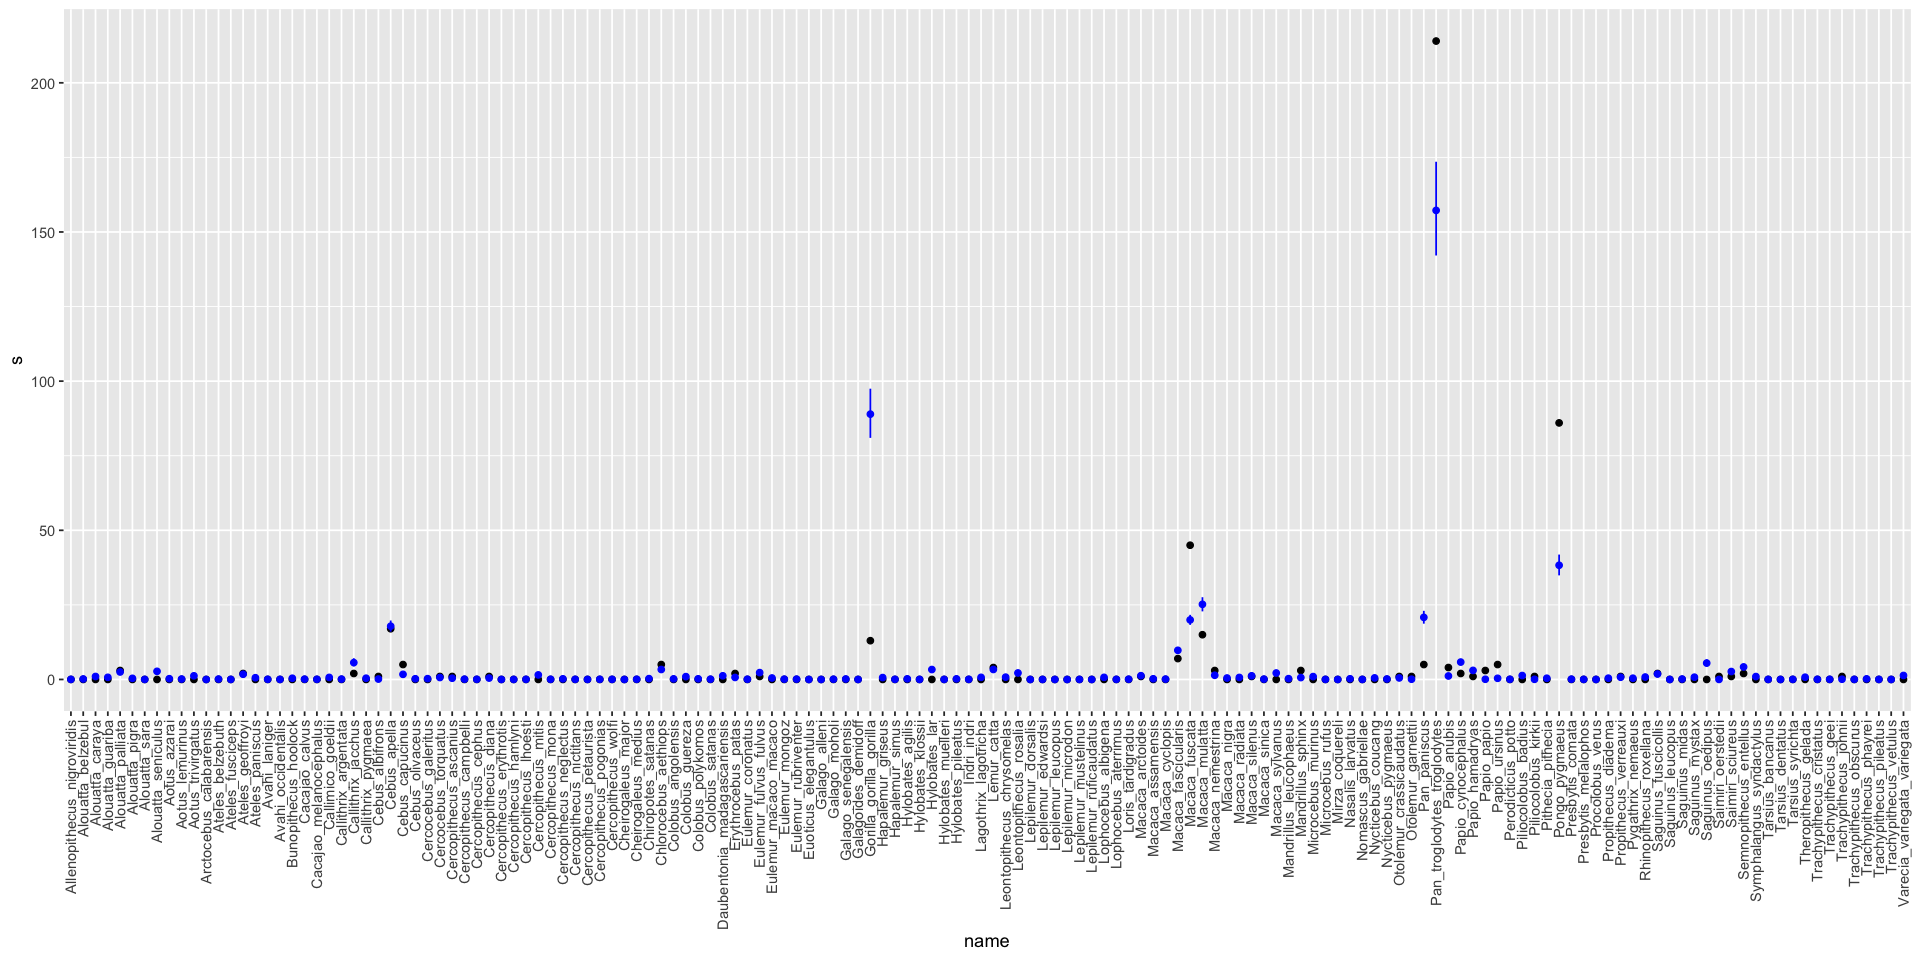

In [13]:
samples <- extract.samples(primate_social_learning_model_2)
posterior_lambda_means <- apply(samples$lambda, 2, mean)
posterior_lambda_ranges <- apply(samples$lambda, 2, PI)

plot_df <- data.frame(
    name = filtered$name,
    s = data$s,
    mean_lambda = posterior_lambda_means,
    lambda_lower = posterior_lambda_ranges[1, ],
    lambda_upper = posterior_lambda_ranges[2, ]
)
ggplot(plot_df, aes(name, s)) +
    geom_point() +
    geom_point(data = plot_df, mapping = aes(name, mean_lambda), colour = 'blue', position = position_dodge(width = 0.1)) +
    geom_linerange(mapping = aes(name, ymin = lambda_lower, ymax = lambda_upper), colour = 'blue', position = position_dodge(width = 0.1)) +
    theme(axis.text.x = element_text(angle=90, vjust=0.5, hjust=1))

This generally looks like it's doing a better job.

In [14]:
compare(primate_social_learning_model_1, primate_social_learning_model_2, func = WAIC)

WAIC      SE       dWAIC    dSE      pWAIC    
primate_social_learning_model_2  557.4717 154.3577    0.000       NA  45.69722
primate_social_learning_model_1 1664.1810 701.8233 1106.709 658.5704 173.79219
                                weight       
primate_social_learning_model_2  1.000000e+00
primate_social_learning_model_1 4.798904e-241

This is borne out by the comparison above, where the second model is quite a bit better than the first one. 

In terms of interpretation of the coefficient of the research effort, let's first find what it is!

mean      sd         5.5%       94.5%     rhat     ess_bulk
a   -7.010041 0.27039785 -7.4431458 -6.604825 1.001830 522.1280
b_e  1.660250 0.06154162  1.5655051  1.761439 1.003220 509.5735
b_b  1.122993 0.27859917  0.6694367  1.572004 1.002796 679.1137

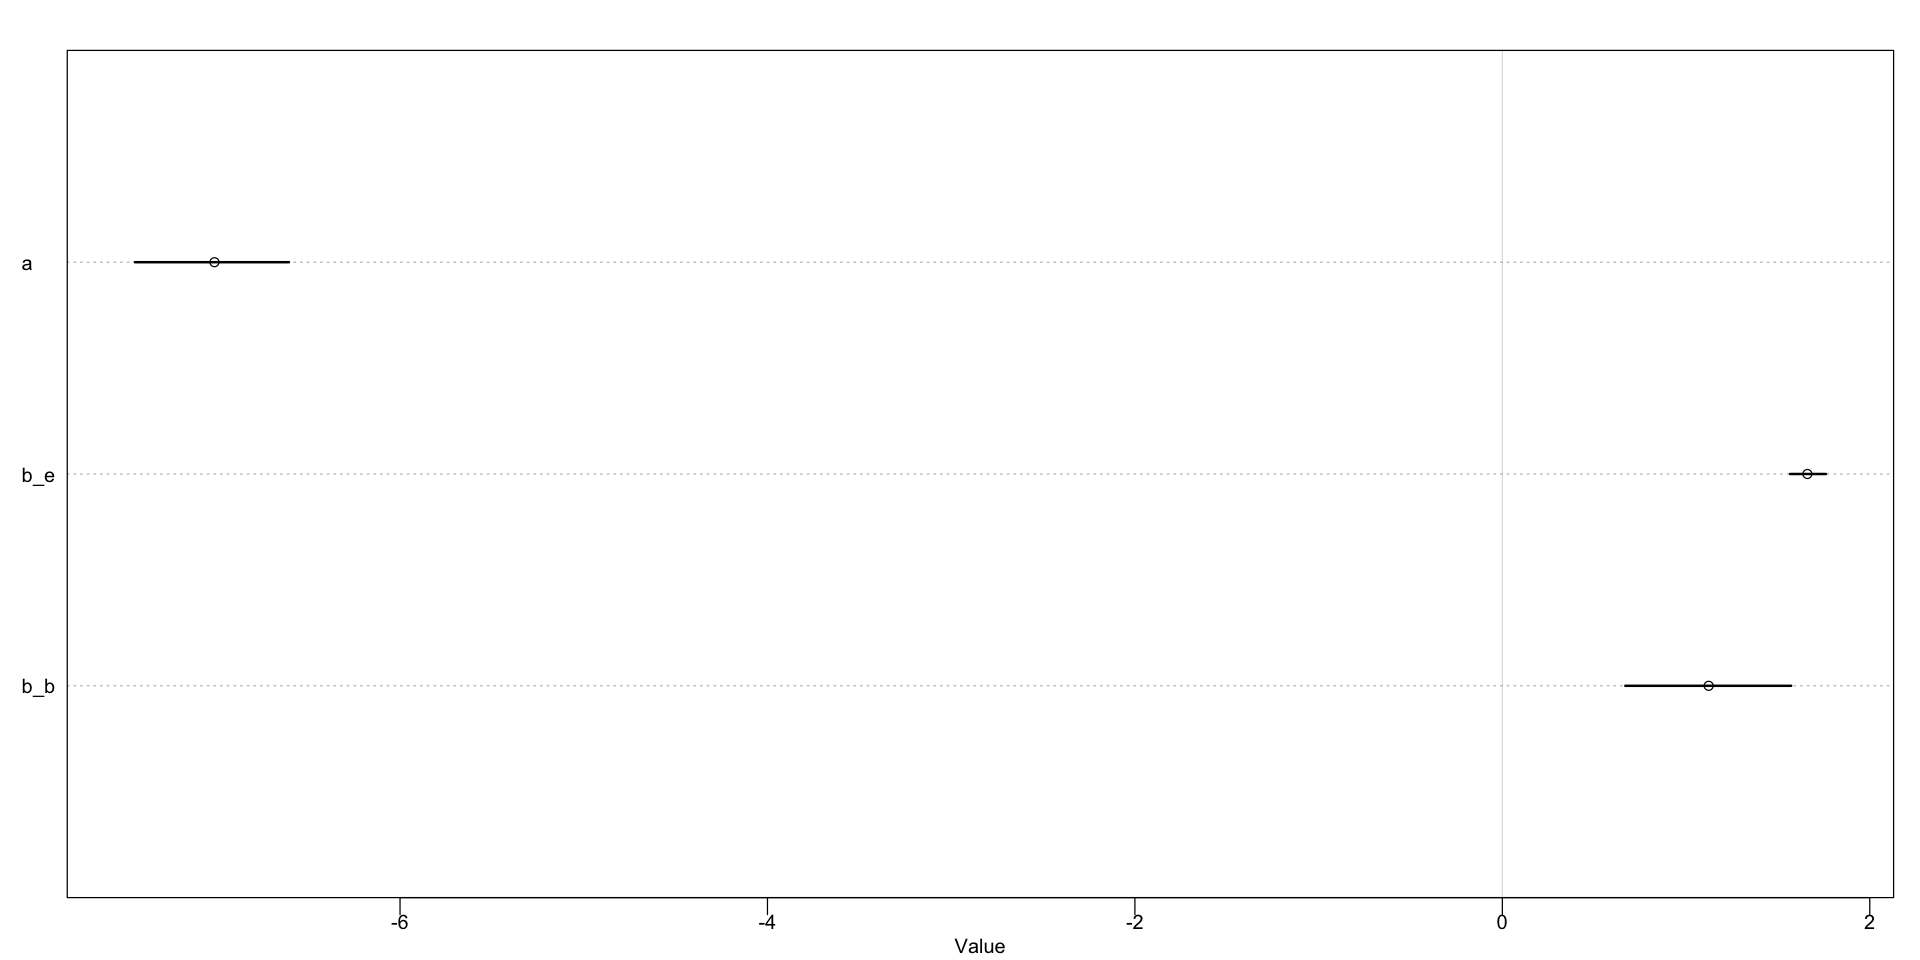

In [23]:
par(bg = 'white')
precis(primate_social_learning_model_2)
plot(precis(primate_social_learning_model_2))

Just like any regression coefficient, this means that a 1-unit increase in log of research effort is associated with a 1.65 ish unit increase in log lambda. Alternatively, a 1-unit increase in log research effort is associated with an $e^{1.65} \approx 5.2$ increase in observed social learning.

In [16]:
exp(1.65)

[1] 5.20698

#### c) Draw a DAG to represent how you think the variables `social_learning`, `brain`, and `research_effort` interact. Justify the DAG with the measures associations in the two models above (and any other models you used).

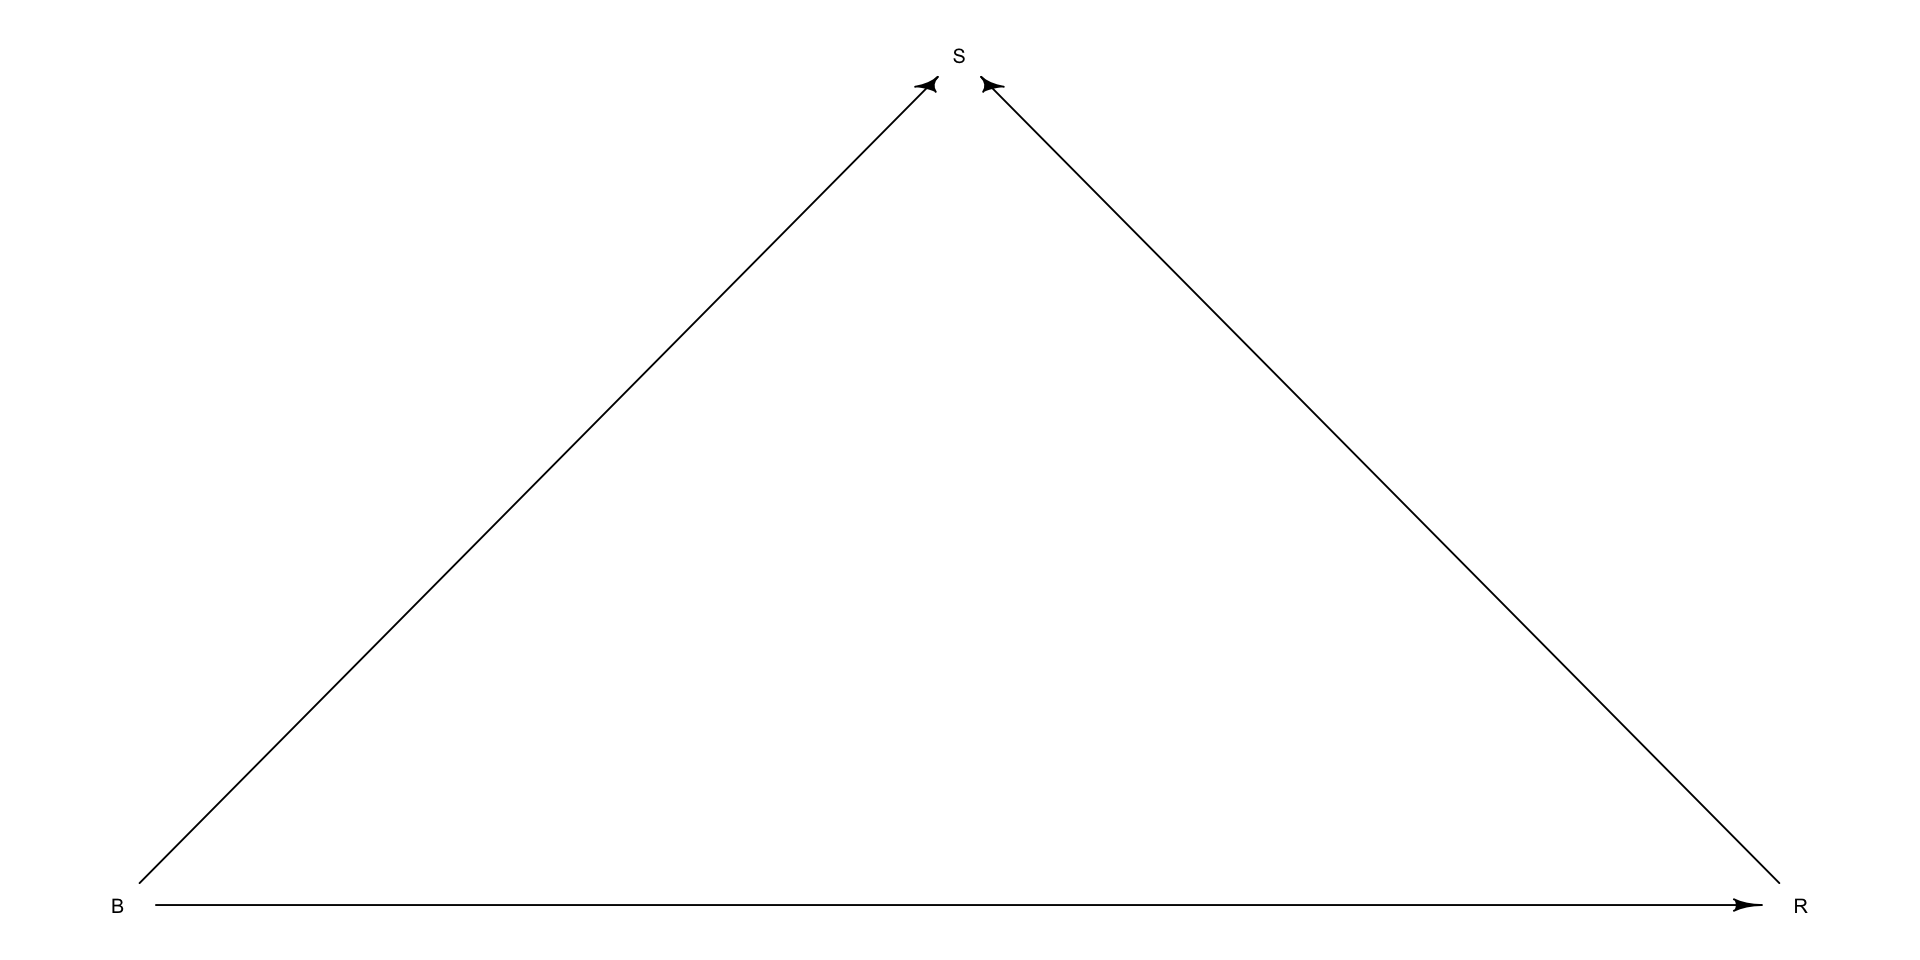

In [20]:
par(bg = "white")
dag <- dagitty('dag{
    S[pos="0,0"]
    B[pos="-0.5,0.5"]
    R[pos="0.5,0.5"]
    B -> S <- R; B -> R;
}')
drawdag(dag)

In [21]:
impliedConditionalIndependencies(dag)

This implies that there should be no independencies, which is in fact what we see if we look at the parameters in the second model (conditioning on both the brain size and researcher effort):

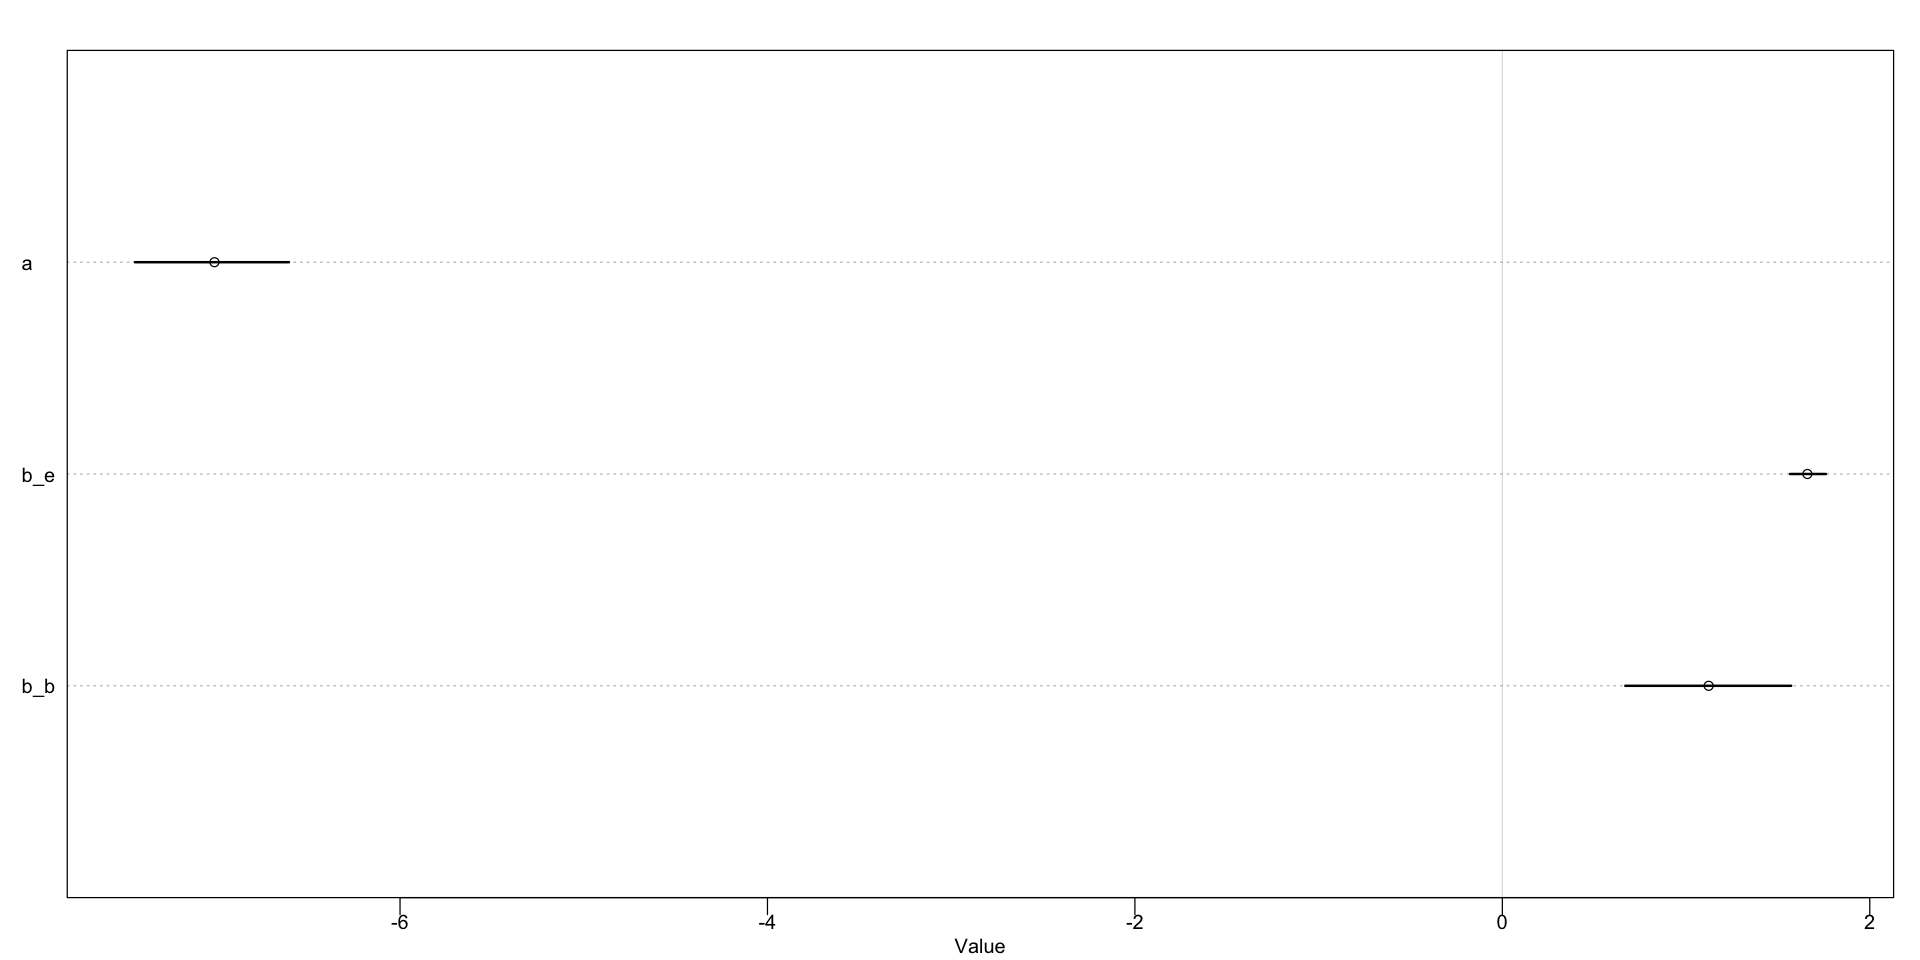

In [24]:
par(bg = 'white')
plot(precis(primate_social_learning_model_2))

This means that our measured associations are consistent with the DAG above.